<a href="https://colab.research.google.com/github/guydav/deep-learning-projects/blob/master/notebooks/GP_Optimization_ABC_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!kill -9 -1

## Notebook Setup

In [1]:
import sys

!git clone https://github.com/guydav/deep-learning-projects.git
!pip install -q -r deep-learning-projects/requirements.txt
!wandb login 9676e3cc95066e4865586082971f2653245f09b4
sys.path.extend(('./deep-learning-projects', './src/tqdm'))

Cloning into 'deep-learning-projects'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 171 (delta 86), reused 125 (delta 49), pack-reused 0
Receiving objects: 100% (171/171), 6.12 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (86/86), done.
tcmalloc: large alloc 1073750016 bytes == 0x626c4000 @  0x7f6d0b5db2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Branch 'colab' set up to track remote branch 'colab' from 'origin'.
Switched to a new branch 'colab'
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
torchvisi

## Mount and sync data

In [2]:
!add-apt-repository -y ppa:alessandro-strada/google-drive-ocamlfuse-beta
!apt-get update
!apt-get install google-drive-ocamlfuse
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!google-drive-ocamlfuse -cc

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [83.2 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/alessandro-strada/google-drive-ocamlfuse-beta/ubuntu bionic InRelease [15.4 kB]
Get:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/alessandro-strada/google-drive-ocamlfuse-beta/ubuntu bionic/main amd64 Packages [2,017 B]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [300 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [135 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:12 https://developer.dow

In [3]:
!ls -la 'drive/Colab/GP_Optimization_ABC'

total 8
drwxr-xr-x 2 root root 4096 Dec 17 18:51 .
drwxr-xr-x 2 root root 4096 Nov 29 14:39 ..


In [4]:
import os
os.chdir('./deep-learning-projects')
!git pull
os.chdir('..')

remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 23 (delta 12), reused 23 (delta 12), pack-reused 0
Unpacking objects: 100% (23/23), done.
From https://github.com/guydav/deep-learning-projects
   7685cf6..e56ce77  master     -> origin/master
Updating 7685cf6..e56ce77
Fast-forward
 projects/dendrogram/tests_and_plots.py |   6 ++
 projects/gp_opt_abc/__init__.py        |   1 +
 projects/gp_opt_abc/abc_bayes_opt.py   | 142 +++++++++++++++++++++++++++++++++
 projects/vae_abc/abc_mcmc.py           |  51 +++++++++---
 4 files changed, 191 insertions(+), 9 deletions(-)
 create mode 100644 projects/gp_opt_abc/__init__.py
 create mode 100644 projects/gp_opt_abc/abc_bayes_opt.py


In [4]:
import projects
from projects.vae_abc import *
from projects.gp_opt_abc import *

import torch
import torch.optim as optim
from sklearn.neighbors import KernelDensity
import pymc3 as pm
import tabulate
import timeit
timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""


Processing...
Done!


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


# Step one: GP Optimization
Star with running through the Pyro Bayesian optimization tutorial, and then adapt it in-place to perform optimization over ABC hyperparameter values and settings.

Said tutorial is here: http://pyro.ai/examples/bo.html

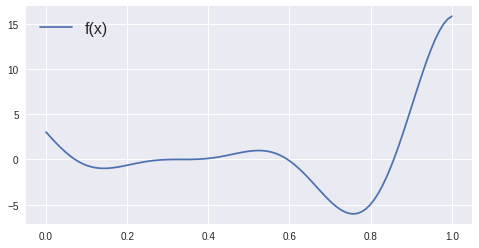

In [5]:
def f(x):
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

x = torch.linspace(0, 1)
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(), f(x).numpy(), label='f(x)')
plt.legend(loc='best', fontsize=16)
plt.show()

In [6]:
# TODO: is there anything to do about sensitivity to initial data?
x_0 = torch.unsqueeze(torch.tensor([0.0, 0.33, 0.66, 1.0]).float(), -1)
opt = ABCBayesianOptimizer(f, x_0 , 1,
                           lambda: torch.rand((1,)),
                           constraints.interval(0, 1), verbose=True)

opt.optimize(20)

Evaluating initial values
Creating GP
After initial fitting, best f(tensor([0.6600])) = -2.6973655223846436


./src/tqdm/tqdm/_tqdm_notebook.py:88: TqdmExperimentalWarning: Detect Google Colab 0.0.1a2 and thus load dummy ipywidgets package. Note that UI is different from that in Jupyter. See https://github.com/tqdm/tqdm/pull/640
  " See https://github.com/tqdm/tqdm/pull/640".format(colab.__version__), TqdmExperimentalWarning)


At iteration 1, proposed tensor([[0.5231]]) => tensor([0.9862])
At iteration 2, proposed tensor([[0.6370]]) => tensor([-1.5983])
At iteration 3, proposed tensor([[0.6717]]) => tensor([-3.2775])
Found new best -- old: f(tensor([0.6600])) = -2.6973655223846436, new: f(tensor([[0.6717]])) = tensor([-3.2775])
At iteration 4, proposed tensor([[0.7169]]) => tensor([-5.2640])
Found new best -- old: f(tensor([[0.6717]])) = tensor([-3.2775]), new: f(tensor([[0.7169]])) = tensor([-5.2640])
At iteration 5, proposed tensor([[0.7585]]) => tensor([-6.0199])
Found new best -- old: f(tensor([[0.7169]])) = tensor([-5.2640]), new: f(tensor([[0.7585]])) = tensor([-6.0199])
At iteration 6, proposed tensor([[0.7808]]) => tensor([-5.7062])
At iteration 7, proposed tensor([[0.1838]]) => tensor([-0.7847])
At iteration 8, proposed tensor([[0.7529]]) => tensor([-6.0107])
At iteration 9, proposed tensor([[0.7551]]) => tensor([-6.0182])
At iteration 10, proposed tensor([[0.7563]]) => tensor([-6.0202])
Found new b

(tensor([[0.7572]]), tensor([-6.0207]))

Excellent. We're replicating the result of the tutorial on the toy problem. Let's move onto ABC.

# Transplant some code from the VAE-ABC project
I'm also currently moving it over to GitHub, and ideally will import it from there

0


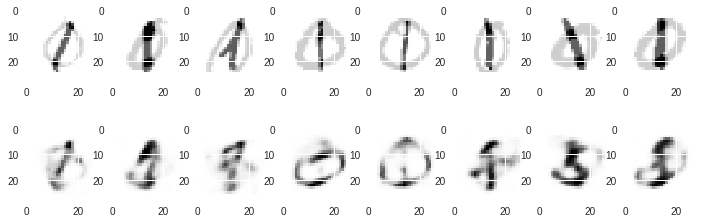

In [7]:
vae = VAE('base_vae').to(device)
vae.load_model(20)
# vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# train_and_test(vae, vae_optimizer, 20, train_loader, test_loader)
dm = SklearnDigitMixer((0, 1), (0.3, 0.7))
im = dm(8)
plot_reconstruction(vae, im)

Let's start with the simplest toy problem - the 0-1 mixture with only those two digits:

In [8]:
results = abc(default_digits, train_images, uniform_two_param_sampler, 
              vae, metric)
print()
print(results[:5])



[(2.9110691091853598, array([0.32407738, 0.67592262])), (2.9139380357414253, array([0.22054559, 0.77945441])), (2.922833104115088, array([0.31811432, 0.68188568])), (2.933957716284545, array([0.37412257, 0.62587743])), (2.9341447689088005, array([0.40009648, 0.59990352]))]


# First problem: learning ABC prior parameters
* How many iterations per evaluation in the Bayesian optimization stage?
* How do you score - best? top-k average?

In [10]:
torch.manual_seed(33)

def abc_prior_bayes_opt_wrapper(dirichlet_params, n_iter=100, top_k=5):
    prior = torch.distributions.Dirichlet(dirichlet_params)
    def prior_sampler(seed):
        return prior.sample().cpu()
    
    results = abc(default_digits, train_images, prior_sampler, 
              vae, metric, n_iter=n_iter)
    
    score = np.mean([tup[0] for tup in results[:top_k]])
    return torch.tensor(score)


naive_prior = torch.distributions.Uniform(1, 20)

abc_opt = ABCBayesianOptimizer(abc_prior_bayes_opt_wrapper, 
                               naive_prior.sample((5, 2)), 2,
                               lambda: naive_prior.sample((1, 2)),
                               constraints.interval(1, 20), 
                               abc_params=dict(n_iter=20, top_k=20),
                               verbose=True)

abc_opt.optimize(40)

Evaluating initial values



Creating GP
After initial fitting, best f(tensor([4.6805, 7.3835])) = 3.0677390098571777


At iteration 1, proposed tensor([[20., 20.]]) => tensor([3.1224])


At iteration 2, proposed tensor([[1.0000, 1.0000]]) => tensor([3.6026])


At iteration 3, proposed tensor([[ 1., 20.]]) => tensor([4.4894])


At iteration 4, proposed tensor([[19.9999, 20.0000]]) => tensor([3.1601])


At iteration 5, proposed tensor([[13.0086, 20.0000]]) => tensor([3.0225])
Found new best -- old: f(tensor([4.6805, 7.3835])) = 3.0677390098571777, new: f(tensor([[13.0086, 20.0000]])) = tensor([3.0225])


At iteration 6, proposed tensor([[ 9.2960, 13.8271]]) => tensor([3.0365])


At iteration 7, proposed tensor([[1.0200, 9.0250]]) => tensor([3.9469])


At iteration 8, proposed tensor([[ 7.6781, 10.4781]]) => tensor([3.0565])


At iteration 9, proposed tensor([[11.5127, 16.1068]]) => tensor([3.0484])


At iteration 10, proposed tensor([[10.1324, 14.5610]]) => tensor([3.0458])


At iteration 11, proposed tensor([[ 8.6985, 12.8574]]) => tensor([2.9987])
Found new best -- old: f(tensor([[13.0086, 20.0000]])) = tensor([3.0225]), new: f(tensor([[ 8.6985, 12.8574]])) = tensor([2.9987])


At iteration 12, proposed tensor([[20.0000, 13.8887]]) => tensor([3.3475])


At iteration 13, proposed tensor([[ 8.5923, 20.0000]]) => tensor([2.9677])
Found new best -- old: f(tensor([[ 8.6985, 12.8574]])) = tensor([2.9987]), new: f(tensor([[ 8.5923, 20.0000]])) = tensor([2.9677])


At iteration 14, proposed tensor([[5.7020, 1.0002]]) => tensor([4.2726])


At iteration 15, proposed tensor([[ 7.3665, 16.9783]]) => tensor([2.9913])


At iteration 16, proposed tensor([[16.4836, 17.1562]]) => tensor([3.1650])


At iteration 17, proposed tensor([[10.1860, 19.1769]]) => tensor([2.9738])


At iteration 18, proposed tensor([[ 6.8866, 13.9419]]) => tensor([2.9977])


At iteration 19, proposed tensor([[7.5257, 7.5405]]) => tensor([3.1443])


At iteration 20, proposed tensor([[ 5.7819, 10.5849]]) => tensor([2.9780])


At iteration 21, proposed tensor([[ 8.9755, 18.1715]]) => tensor([2.9772])


At iteration 22, proposed tensor([[10.2230, 19.9999]]) => tensor([2.9934])


At iteration 23, proposed tensor([[ 7.8421, 19.9999]]) => tensor([2.9866])


At iteration 24, proposed tensor([[ 6.4120, 12.3518]]) => tensor([3.0613])


At iteration 25, proposed tensor([[ 8.1133, 18.4350]]) => tensor([2.9827])


At iteration 26, proposed tensor([[ 7.5744, 15.7805]]) => tensor([2.9832])


At iteration 27, proposed tensor([[ 9.8123, 19.9999]]) => tensor([3.0159])


At iteration 28, proposed tensor([[ 7.1978, 18.0882]]) => tensor([2.9782])


At iteration 29, proposed tensor([[16.1731, 19.9996]]) => tensor([3.0942])


At iteration 30, proposed tensor([[5.8027, 9.2760]]) => tensor([3.0999])


At iteration 31, proposed tensor([[ 8.6753, 17.9382]]) => tensor([3.0058])


At iteration 32, proposed tensor([[ 6.8963, 15.8267]]) => tensor([2.9920])


At iteration 33, proposed tensor([[ 8.1157, 19.0520]]) => tensor([2.9668])
Found new best -- old: f(tensor([[ 8.5923, 20.0000]])) = tensor([2.9677]), new: f(tensor([[ 8.1157, 19.0520]])) = tensor([2.9668])


At iteration 34, proposed tensor([[ 8.3712, 19.0775]]) => tensor([3.0280])


At iteration 35, proposed tensor([[ 7.3238, 15.3739]]) => tensor([2.9795])


At iteration 36, proposed tensor([[ 6.8147, 17.0045]]) => tensor([3.0096])


At iteration 37, proposed tensor([[ 8.7181, 19.9996]]) => tensor([2.9735])


At iteration 38, proposed tensor([[ 8.7111, 19.9996]]) => tensor([3.0041])


At iteration 39, proposed tensor([[11.0341, 19.9996]]) => tensor([2.9710])


At iteration 40, proposed tensor([[ 8.3035, 16.5227]]) => tensor([2.9761])



(tensor([[ 8.1157, 19.0520]]), tensor([2.9668]))

Let's try using the best result from the GP to run 100 iterations and see how we do

In [11]:
gp_param_prior = torch.distributions.Dirichlet(abc_opt.best_x)
def gp_param_prior_sampler(seed):
    return gp_param_prior.sample().cpu()


gp_param_results = abc(default_digits, train_images, gp_param_prior_sampler, 
                       vae, metric)


print()
print(gp_param_results[:5])


compare_results((0.3, 0.7), results, gp_param_results)



[(2.8599466416627, tensor([[0.2937, 0.7063]])), (2.8718341584348144, tensor([[0.2592, 0.7408]])), (2.8741468471953078, tensor([[0.2746, 0.7254]])), (2.8875713097938704, tensor([[0.3293, 0.6707]])), (2.894288107582585, tensor([[0.3243, 0.6757]]))]
╒═════════╤═════════════╤═════════════════╤════════════════╤════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC score │   ABC digit MAD │   ABC_GP score │   ABC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪═════════════╪═════════════════╪════════════════╪════════════════════╪══════════════╪═════════════════╡
│       1 │     2.91107 │       0.0481548 │        2.85995 │          0.0126116 │    0.0511225 │       0.0355431 │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│      10 │     2.93456 │       0.105466  │        2.89179 │          0.0681866 │    0.0427705 │       0.0372797 │
├─────────┼─────────────┼─────────────────┼────────────────┼─

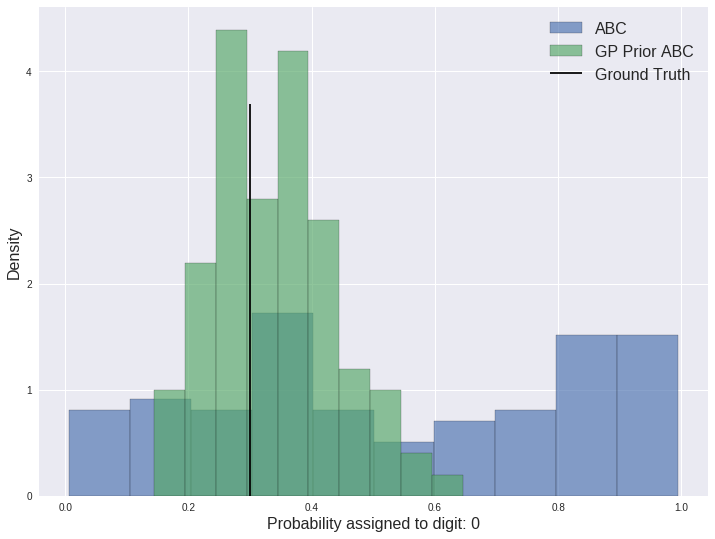

In [0]:
single_digit_result_histogram([results, gp_param_results], ['ABC', 'GP Prior ABC'], top_k=100)



[(2.868227615456268, array([0.27187682, 0.72812318])), (2.9002248444444083, array([0.33871797, 0.66128203])), (2.901353783954684, array([0.29829931, 0.70170069])), (2.9037136915282082, array([0.34174987, 0.65825013])), (2.907561221231129, array([0.24751356, 0.75248644]))]
╒═════════╤═════════════╤═════════════════╤════════════════╤════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC score │   ABC digit MAD │   ABC_GP score │   ABC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪═════════════╪═════════════════╪════════════════╪════════════════════╪══════════════╪═════════════════╡
│       1 │     2.86823 │       0.0562464 │        2.88845 │          0.165334  │  -0.0202192  │     -0.109087   │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│      10 │     2.90515 │       0.0569282 │        2.91308 │          0.0640283 │  -0.00793325 │     -0.00710008 │
├─────────┼─────────────┼──────────

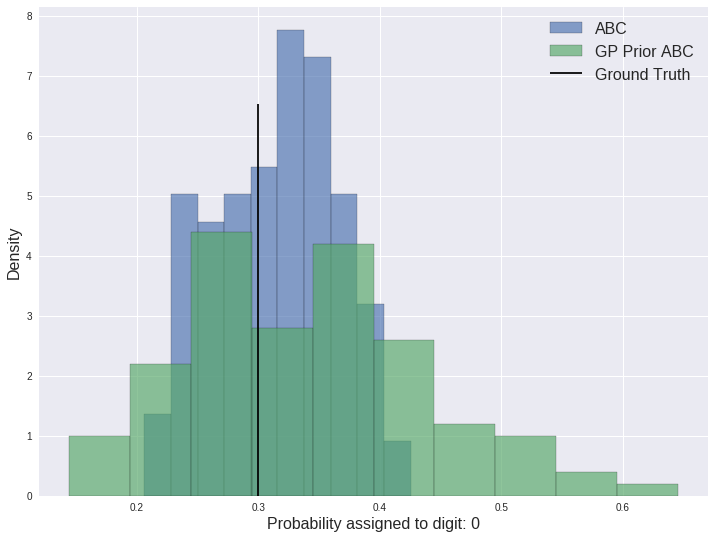

In [0]:
larger_sample_results = abc(default_digits, train_images, uniform_two_param_sampler, 
              vae, metric, n_iter=1000)
print()
print(larger_sample_results[:5])

compare_results((0.3, 0.7), larger_sample_results, gp_param_results)
single_digit_result_histogram([larger_sample_results, gp_param_results], ['ABC', 'GP Prior ABC'], top_k=100)

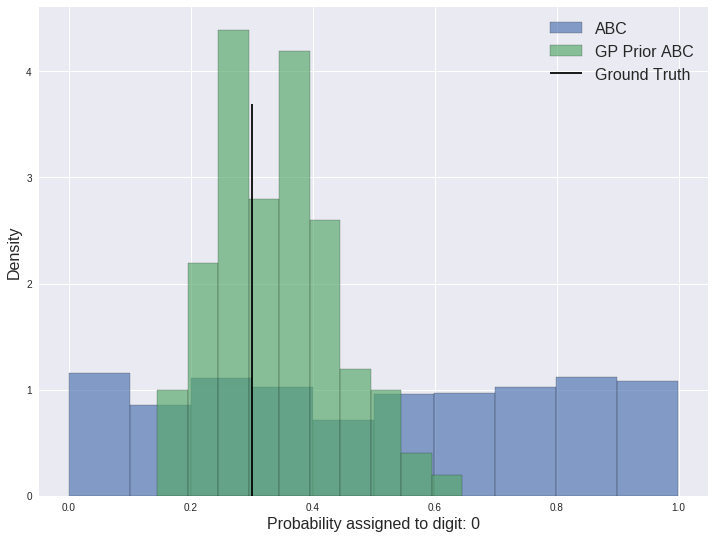

In [0]:
single_digit_result_histogram([larger_sample_results, gp_param_results], ['ABC', 'GP Prior ABC'], top_k=1000)

## This is mildly promising.

On the 2-d problem, the top-10 and top-100 outperform 100 random samples, but not 1000 random samples. What about a harder problem?

In [0]:
def uniform_four_param_sampler(seed):
    return np.random.dirichlet((1, 1, 1, 1))

default_four_digits = (0, 1, 2, 3)

four_digit_results = abc(default_four_digits, train_images, uniform_four_param_sampler, 
                         vae, metric, n_iter=1000)

print(four_digit_results[:5])


[(2.65753349014533, array([0.21256848, 0.53771232, 0.1211621 , 0.1285571 ])), (2.6611228658794817, array([0.29373849, 0.44338447, 0.16610452, 0.09677253])), (2.6628371095425325, array([0.28224463, 0.57897606, 0.0898196 , 0.04895971])), (2.6691089568733806, array([0.22927969, 0.54627222, 0.05525963, 0.16918846])), (2.6707043772908245, array([0.2316586 , 0.61445194, 0.04856635, 0.10532311]))]


In [0]:
torch.manual_seed(33)
dim = 4
n_initial_samples = 10

def abc_prior_bayes_opt_wrapper(dirichlet_params, n_iter=100, top_k=5):
    prior = torch.distributions.Dirichlet(dirichlet_params)
    def prior_sampler(seed):
        return prior.sample().cpu()
    
    results = abc(default_four_digits, train_images, prior_sampler, 
              vae, metric, n_iter=n_iter)
    
    score = np.mean([tup[0] for tup in results[:top_k]])
    return torch.tensor(score)


naive_prior = torch.distributions.Uniform(1, 20)

abc_opt_4_digits = ABCBayesianOptimizer(abc_prior_bayes_opt_wrapper, 
                               naive_prior.sample((n_initial_samples, dim)), dim,
                               lambda: naive_prior.sample((1, dim)),
                               constraints.interval(1, 20), 
                               abc_params=dict(n_iter=100, top_k=100),
                               verbose=True)

abc_opt_4_digits.optimize(40)

Evaluating initial values



Creating GP
After initial fitting, best f(tensor([17.9214, 18.4081, 14.1234, 16.6371])) = 2.799215793609619


At iteration 1, proposed tensor([[19.9999,  1.0002, 20.0000,  1.0001]]) => tensor([3.5599])


At iteration 2, proposed tensor([[ 1.0000,  1.0001,  1.0000, 20.0000]]) => tensor([4.5858])


At iteration 3, proposed tensor([[20.0000, 20.0000,  1.0000, 19.9999]]) => tensor([2.9088])


At iteration 4, proposed tensor([[20., 20.,  1.,  1.]]) => tensor([3.0363])


At iteration 5, proposed tensor([[19.9998,  1.0000,  1.0000,  1.0000]]) => tensor([4.4035])


At iteration 6, proposed tensor([[20.0000,  1.0103, 20.0000, 20.0000]]) => tensor([3.2021])


At iteration 7, proposed tensor([[ 9.8987, 19.9997,  1.0344, 10.8024]]) => tensor([2.7862])
Found new best -- old: f(tensor([17.9214, 18.4081, 14.1234, 16.6371])) = 2.799215793609619, new: f(tensor([[ 9.8987, 19.9997,  1.0344, 10.8024]])) = tensor([2.7862])


At iteration 8, proposed tensor([[20.0000, 19.9997,  8.1502, 10.4013]]) => tensor([2.7690])
Found new best -- old: f(tensor([[ 9.8987, 19.9997,  1.0344, 10.8024]])) = tensor([2.7862]), new: f(tensor([[20.0000, 19.9997,  8.1502, 10.4013]])) = tensor([2.7690])


At iteration 9, proposed tensor([[13.2854, 14.3969, 10.2182, 12.1529]]) => tensor([2.8139])


At iteration 10, proposed tensor([[ 5.5858, 20.0000,  1.0004,  1.0000]]) => tensor([2.9436])


At iteration 11, proposed tensor([[20.0000, 20.0000, 19.9997,  1.0000]]) => tensor([2.9148])


At iteration 12, proposed tensor([[20.0000, 20.0000, 20.0000, 19.9997]]) => tensor([2.8330])


At iteration 13, proposed tensor([[19.9998, 13.6002, 19.9989, 12.2663]]) => tensor([2.9055])


At iteration 14, proposed tensor([[12.4608, 20.0000,  6.7505,  7.2011]]) => tensor([2.7180])
Found new best -- old: f(tensor([[20.0000, 19.9997,  8.1502, 10.4013]])) = tensor([2.7690]), new: f(tensor([[12.4608, 20.0000,  6.7505,  7.2011]])) = tensor([2.7180])


At iteration 15, proposed tensor([[ 1.0003, 20.0000, 20.0000,  1.0000]]) => tensor([3.4324])


At iteration 16, proposed tensor([[ 9.8837, 17.2027,  5.7585,  7.6012]]) => tensor([2.7224])


At iteration 17, proposed tensor([[20.0000, 19.9999, 10.4378, 19.9999]]) => tensor([2.8060])


At iteration 18, proposed tensor([[14.2454, 20.0000,  4.0844,  9.1154]]) => tensor([2.7476])


At iteration 19, proposed tensor([[14.2176, 19.8931, 10.0218,  5.3123]]) => tensor([2.7508])


At iteration 20, proposed tensor([[ 9.7618, 19.9978,  6.8657,  8.7680]]) => tensor([2.7214])


At iteration 21, proposed tensor([[ 9.8895, 16.6582,  6.2918,  7.4429]]) => tensor([2.7273])


At iteration 22, proposed tensor([[10.6421, 18.2557,  5.6859,  6.9476]]) => tensor([2.7151])
Found new best -- old: f(tensor([[12.4608, 20.0000,  6.7505,  7.2011]])) = tensor([2.7180]), new: f(tensor([[10.6421, 18.2557,  5.6859,  6.9476]])) = tensor([2.7151])


At iteration 23, proposed tensor([[19.9999, 14.4163, 14.0612, 19.9996]]) => tensor([2.8715])


At iteration 24, proposed tensor([[12.5108, 19.9956,  7.9523,  9.6954]]) => tensor([2.7264])


At iteration 25, proposed tensor([[10.6940, 19.9957,  5.3018,  7.0125]]) => tensor([2.7121])
Found new best -- old: f(tensor([[10.6421, 18.2557,  5.6859,  6.9476]])) = tensor([2.7151]), new: f(tensor([[10.6940, 19.9957,  5.3018,  7.0125]])) = tensor([2.7121])


At iteration 26, proposed tensor([[10.0888, 16.4398,  6.8675,  8.2205]]) => tensor([2.7389])


At iteration 27, proposed tensor([[19.9997, 20.0000, 15.5832, 10.9319]]) => tensor([2.7949])


At iteration 28, proposed tensor([[16.2769, 20.0000, 17.9494,  9.7791]]) => tensor([2.8098])


At iteration 29, proposed tensor([[12.0750, 19.9969,  5.3274,  7.2493]]) => tensor([2.7238])


At iteration 30, proposed tensor([[13.2452, 19.9944,  6.6384,  9.7899]]) => tensor([2.7243])


At iteration 31, proposed tensor([[ 9.3407, 19.9947,  5.9421,  7.6567]]) => tensor([2.7152])


At iteration 32, proposed tensor([[11.8964, 19.9742,  5.7317,  6.9079]]) => tensor([2.7181])


At iteration 33, proposed tensor([[ 8.9571, 19.9994,  5.8057,  7.8149]]) => tensor([2.7157])


At iteration 34, proposed tensor([[11.6762, 19.9988,  7.3149,  9.0858]]) => tensor([2.7240])


At iteration 35, proposed tensor([[11.6145, 19.9988,  5.0711,  7.0281]]) => tensor([2.7182])


At iteration 36, proposed tensor([[11.7377, 19.9988,  6.8603,  6.6743]]) => tensor([2.7148])


At iteration 37, proposed tensor([[11.2055, 17.0183,  7.5043,  7.4215]]) => tensor([2.7318])


At iteration 38, proposed tensor([[ 9.9729, 17.6959,  5.7759,  8.3627]]) => tensor([2.7236])


At iteration 39, proposed tensor([[11.0624, 19.2850,  4.4505,  7.1006]]) => tensor([2.7238])


At iteration 40, proposed tensor([[ 9.0631, 19.9977,  5.9510,  7.9692]]) => tensor([2.7149])



(tensor([[10.6940, 19.9957,  5.3018,  7.0125]]), tensor([2.7121]))



[(2.626021160360737, tensor([[0.2465, 0.4147, 0.1358, 0.2029]])), (2.6269468528422726, tensor([[0.2320, 0.4983, 0.1386, 0.1311]])), (2.63277579378398, tensor([[0.2097, 0.5332, 0.1347, 0.1224]])), (2.635545457617216, tensor([[0.2527, 0.5137, 0.0892, 0.1444]])), (2.63892735270707, tensor([[0.2309, 0.5542, 0.0853, 0.1296]]))]
╒═════════╤═════════════╤═════════════════╤════════════════╤════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC score │   ABC digit MAD │   ABC_GP score │   ABC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪═════════════╪═════════════════╪════════════════╪════════════════════╪══════════════╪═════════════════╡
│       1 │     2.65753 │        0.499438 │        2.62602 │           0.677511 │    0.0315123 │      -0.178073  │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│      10 │     2.67106 │        0.466737 │        2.63634 │           0.554802 │    0.0347125 │  

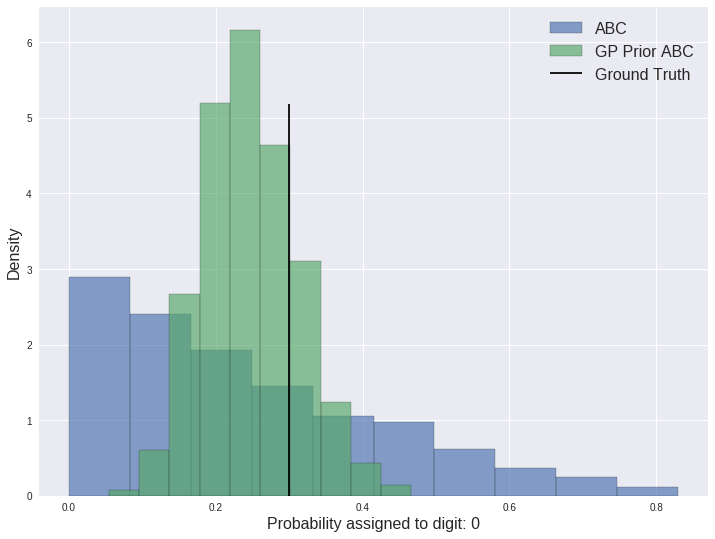

In [0]:
gp_param_prior = torch.distributions.Dirichlet(abc_opt_4_digits.best_x)
def gp_param_prior_sampler(seed):
    return gp_param_prior.sample().cpu()


four_digit_gp_param_results = abc(default_four_digits, train_images, gp_param_prior_sampler, 
                                  vae, metric, n_iter=1000)


print()
print(four_digit_gp_param_results[:5])

compare_results((0.3, 0.7, 0, 0), four_digit_results, four_digit_gp_param_results)
single_digit_result_histogram([four_digit_results, four_digit_gp_param_results], ['ABC', 'GP Prior ABC'], top_k=1000)

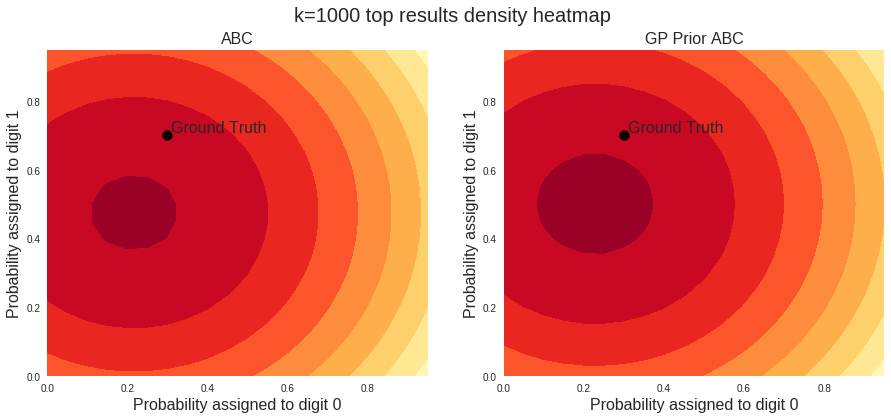

In [0]:
two_digit_result_density((four_digit_results, four_digit_gp_param_results), 
                         ('ABC', 'GP Prior ABC'),
                         top_k=1000, suptitle='k=1000 top results density heatmap')

In [0]:
larger_four_digit_results = abc(default_four_digits, train_images, uniform_four_param_sampler, 
                         vae, metric, n_iter=10000)

compare_results((0.3, 0.7, 0, 0), larger_four_digit_results, four_digit_gp_param_results)


╒═════════╤═════════════╤═════════════════╤════════════════╤════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC score │   ABC digit MAD │   ABC_GP score │   ABC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪═════════════╪═════════════════╪════════════════╪════════════════════╪══════════════╪═════════════════╡
│       1 │     2.62216 │        0.529251 │        2.62602 │           0.677511 │  -0.00385902 │    -0.14826     │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│      10 │     2.64112 │        0.510306 │        2.63634 │           0.554802 │   0.00477147 │    -0.0444956   │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│     100 │     2.67144 │        0.542538 │        2.65577 │           0.541947 │   0.0156685  │     0.000590911 │
├─────────┼─────────────┼─────────────────┼────────────────┼───────────────────

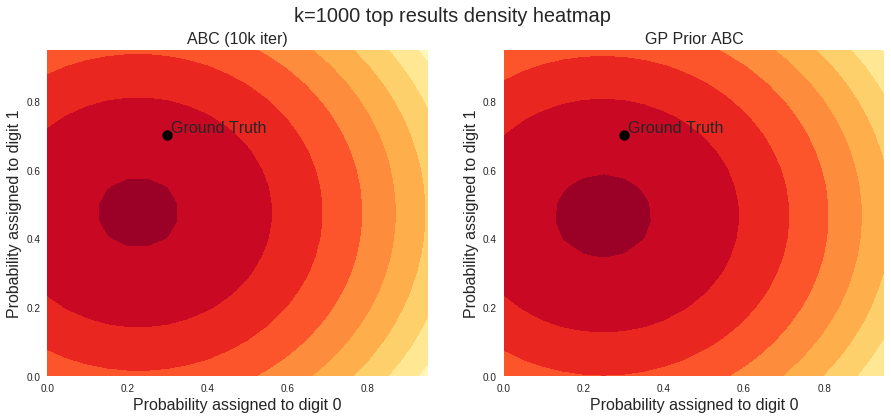

In [0]:
two_digit_result_density((larger_four_digit_results, four_digit_gp_param_results), 
                         ('ABC (10k iter)', 'GP Prior ABC'),
                         top_k=1000, suptitle='k=1000 top results density heatmap')

On the harder, we incrementally order an order of magnitude more samples from the naive approach. Cool!

# Let's try a second parameter learning problem: learning ARD weights

This requires re-defining a metric, which isn't too hard, and then learning the correct weights.

First trying to do this without learning the prior, and we can them combine it with learning the prior.

This is a much harder problem, since the latent space is 40-d, rather than 4-d, so I'll give it a reasonable prior to help it search a little bit better. 

In [0]:
def abc_ard_bayes_opt_wrapper(ard_params, n_iter=100, top_k=10,
                              digits=default_digits,
                              prior_dirichlet_params=(1, 1),
                              ground_truth=(0.3, 0.7)):
#     prior = torch.distributions.Dirichlet(torch.from_numpy(prior_dirichlet_params))
#     def prior_sampler(seed):
#         return prior.sample().cpu()

    def prior_sampler(seed):
        return np.random.dirichlet(prior_dirichlet_params)
    
    def ard_metric(params, generated, train):
        return np.mean(cdist(generated, train, 'seuclidean', V=np.squeeze(ard_params.double().numpy())))
    
    results = abc(digits, train_images, prior_sampler, 
              vae, ard_metric, n_iter=n_iter)
    
    # In this case, distance-based scoring makes little sense, since it can be 
    # optimized by setting the weights as high as possible
    # It also makes no sense for top_k to be equal to n_iter, since we want to 
    # see if the distance metric is effective at choosing the best items
    if top_k >= n_iter:
        print('Warning - you should use top_k << n_iter in this example')
    
    # However, this only works in a toy example where we know what the ground-truth
    # answer is. We'd have to come up with a different scoring method if we do not. 
    mean_mad_score = np.mean([np.sum(np.abs(tup[1] - ground_truth)) for tup in results[:top_k]])
    return torch.tensor(mean_mad_score)


torch.manual_seed(33)
dim = 40
n_initial_samples = 40


naive_prior = torch.distributions.Uniform(1e-1, 10)

abc_opt_ard_two_digits = ABCBayesianOptimizer(abc_ard_bayes_opt_wrapper, 
                               naive_prior.sample((n_initial_samples, dim)), dim,
                               lambda: naive_prior.sample((1, dim)),
                               constraints.interval(1e-1, 10), 
                               abc_params=dict(n_iter=100, top_k=10, prior_dirichlet_params=(3, 7)),
                               verbose=True)

abc_opt_ard_two_digits.optimize(40)

Evaluating initial values



Creating GP
After initial fitting, best f(tensor([8.1416, 4.4723, 1.7262, 4.1061, 2.6166, 6.5544, 5.3316, 4.3429, 6.8801,
        1.8456, 6.5449, 3.1562, 2.9924, 1.0429, 5.6086, 6.0730, 4.4260, 4.0366,
        2.8742, 5.9682, 4.0288, 4.6180, 3.6026, 9.4366, 2.2120, 4.8909, 2.1859,
        1.9559, 5.5554, 4.4453, 6.1436, 2.6327, 7.4775, 5.0552, 8.4899, 1.4348,
        6.6674, 5.8451, 6.9235, 6.0829])) = 0.036317139863967896


At iteration 1, proposed tensor([[3.9321, 2.0612, 9.6711, 1.3220, 7.8145, 4.2090, 2.3991, 2.9232, 4.2398,
         7.6885, 2.5110, 4.3585, 8.9381, 0.1206, 8.6752, 4.9235, 6.9817, 9.8623,
         1.0056, 7.2613, 2.2770, 7.7972, 2.7370, 7.4418, 1.3143, 3.1678, 2.8245,
         2.8535, 3.0913, 8.3690, 0.6616, 5.8214, 5.0248, 2.9932, 1.5476, 1.9127,
         0.7519, 5.5213, 6.2144, 7.5698]]) => tensor([0.1527])


At iteration 2, proposed tensor([[9.5151, 7.4064, 8.8429, 3.9087, 5.5352, 1.0338, 9.1318, 4.6892, 6.4164,
         1.3732, 8.8247, 7.0032, 1.9138, 8.8560, 0.5101, 3.9020, 2.0200, 2.8675,
         4.8784, 6.7192, 6.0482, 9.0891, 6.5048, 3.9419, 9.1705, 7.1044, 8.5303,
         0.6634, 1.6166, 9.3366, 9.5713, 1.1713, 7.6142, 7.1607, 1.3374, 6.4197,
         1.8470, 7.9543, 2.1421, 1.8670]]) => tensor([0.0582])


At iteration 3, proposed tensor([[3.3378, 4.8053, 0.2349, 3.9526, 7.3972, 7.2676, 2.4732, 5.9079, 4.0381,
         9.6851, 4.2409, 7.0266, 5.6101, 9.0483, 1.8839, 4.2709, 9.1026, 1.8209,
         3.8406, 0.2891, 2.9501, 2.0107, 1.0070, 9.8185, 1.0803, 9.2780, 7.9465,
         6.6553, 0.7691, 8.5879, 2.1412, 0.9042, 4.2738, 0.7939, 3.2251, 3.7994,
         5.2593, 5.4335, 2.1122, 8.7604]]) => tensor([0.1268])


At iteration 4, proposed tensor([[2.8744, 3.9727, 6.8403, 1.2276, 2.8521, 7.0086, 4.4652, 1.6273, 8.5754,
         6.0638, 9.6465, 4.8354, 1.6372, 6.6511, 9.1744, 5.4523, 3.1307, 8.2955,
         1.3598, 6.1802, 1.9216, 0.4132, 5.2466, 6.8537, 8.5606, 8.4522, 8.1254,
         4.3967, 0.8705, 2.2988, 8.7664, 5.5972, 7.1633, 1.7912, 8.9531, 3.3791,
         6.4738, 5.3636, 1.7167, 1.8046]]) => tensor([0.0789])


At iteration 5, proposed tensor([[0.6500, 2.4767, 9.8779, 1.0274, 2.4856, 2.7452, 4.4568, 5.8348, 4.9496,
         2.7048, 5.8903, 6.0471, 2.5165, 7.1741, 6.8073, 1.1194, 7.0557, 5.7035,
         3.4479, 4.0781, 8.7629, 8.0826, 1.7136, 4.9310, 3.4065, 6.6190, 4.4642,
         0.1604, 6.0091, 6.9262, 6.3897, 9.7522, 8.0644, 1.1785, 1.3118, 2.2598,
         9.8488, 6.2764, 1.5146, 4.8647]]) => tensor([0.0666])


At iteration 6, proposed tensor([[5.1958, 9.2633, 9.7527, 9.5645, 2.6174, 5.3088, 9.4149, 7.2148, 8.2170,
         4.2022, 5.6931, 3.4484, 4.9866, 3.7303, 0.8676, 8.4041, 1.3924, 8.2871,
         8.4924, 6.4300, 1.7211, 3.9030, 7.7754, 0.4550, 9.6018, 1.6348, 8.8389,
         0.9807, 6.0470, 0.3098, 3.2692, 2.8128, 1.8867, 0.2318, 9.2912, 1.2275,
         4.7735, 1.7529, 6.4921, 6.3736]]) => tensor([0.0679])


At iteration 7, proposed tensor([[4.5635, 8.0656, 8.3542, 4.6448, 5.8096, 1.7490, 3.1589, 0.9587, 0.3624,
         3.0618, 9.8884, 0.5924, 6.5815, 8.0054, 0.6761, 0.7767, 5.5667, 9.9957,
         5.4904, 7.7168, 6.6260, 0.7180, 0.7666, 9.4073, 8.3913, 2.6872, 9.9693,
         2.4293, 4.4228, 2.3735, 0.4091, 6.5390, 4.8138, 6.7529, 3.4684, 8.0223,
         5.8542, 3.9558, 2.4001, 8.5529]]) => tensor([0.0409])


At iteration 8, proposed tensor([[4.1840, 9.5522, 8.6131, 2.0414, 4.7092, 1.8644, 8.9491, 0.8279, 8.0251,
         1.7923, 7.7388, 1.3204, 7.5884, 2.1555, 7.8630, 9.9120, 9.2682, 3.1193,
         4.4206, 1.7007, 8.9852, 6.4925, 4.1306, 3.1220, 0.2940, 9.2898, 5.7222,
         0.3513, 4.6081, 0.3721, 5.6185, 8.8100, 7.7119, 0.8263, 4.9572, 1.4572,
         9.4670, 4.8810, 1.2149, 5.4487]]) => tensor([0.0849])


At iteration 9, proposed tensor([[0.6942, 6.2808, 5.4324, 9.5238, 7.6974, 3.4563, 1.1032, 5.3812, 0.5291,
         0.1570, 2.2637, 0.1689, 9.1307, 9.1110, 0.8782, 9.1871, 6.5544, 0.1873,
         9.4944, 7.0535, 9.0859, 7.8177, 7.8594, 9.9334, 8.7532, 9.2633, 5.6538,
         1.1436, 6.2900, 6.1913, 0.9073, 8.8947, 4.4487, 7.1768, 7.6038, 5.3388,
         6.2247, 9.2873, 9.3971, 9.7105]]) => tensor([0.0718])


At iteration 10, proposed tensor([[5.5700, 5.1257, 6.9100, 5.2039, 6.9031, 0.8977, 0.2390, 2.7854, 2.5328,
         8.5843, 3.1920, 6.0055, 0.2757, 8.7404, 2.0877, 5.5365, 5.0226, 9.1263,
         0.8759, 3.6845, 9.6014, 7.2138, 2.6400, 5.9304, 5.1064, 5.5116, 2.9930,
         3.7373, 0.1571, 7.5434, 4.1743, 4.8293, 8.6207, 7.3981, 0.6608, 9.2224,
         3.0039, 3.0669, 2.9708, 1.6002]]) => tensor([0.0692])


At iteration 11, proposed tensor([[6.8405, 9.5677, 0.8409, 1.5004, 5.7448, 5.9851, 0.8619, 1.6401, 6.2757,
         2.0023, 7.4790, 7.5253, 1.4990, 5.3929, 3.2541, 6.1651, 7.8560, 7.4197,
         8.9904, 9.5207, 7.8331, 4.0252, 9.0399, 5.1286, 8.6128, 6.0182, 1.6722,
         9.6255, 1.4417, 1.0303, 9.1594, 6.4172, 4.8484, 2.1289, 5.4989, 1.5840,
         2.5748, 5.9388, 6.7519, 6.3630]]) => tensor([0.0847])


At iteration 12, proposed tensor([[1.9393, 2.3495, 1.1154, 6.6769, 1.1382, 2.0664, 2.2636, 0.1346, 8.5288,
         1.0597, 6.2077, 1.6078, 0.1796, 1.7532, 0.6388, 4.5591, 8.4652, 4.4511,
         1.7565, 1.8761, 2.8082, 5.9314, 5.1661, 0.5936, 6.1420, 6.4311, 9.7214,
         1.6879, 1.8390, 8.6661, 9.6155, 4.8429, 1.1260, 3.1942, 0.7985, 5.4038,
         2.1449, 6.4286, 6.6611, 7.3880]]) => tensor([0.1262])


At iteration 13, proposed tensor([[4.1955, 3.5689, 2.6795, 9.0401, 5.3438, 0.4183, 1.8644, 6.1957, 7.5508,
         0.6848, 0.2298, 9.4632, 6.8325, 2.1552, 6.1691, 2.6563, 9.1155, 1.5449,
         4.8757, 4.3585, 8.7829, 0.5618, 9.0206, 3.9182, 9.4111, 7.2452, 8.3014,
         9.6260, 0.7240, 4.1434, 9.2050, 6.0037, 1.4870, 5.2730, 4.1813, 5.4277,
         1.3774, 6.4185, 5.8715, 7.3405]]) => tensor([0.0445])


At iteration 14, proposed tensor([[7.6563, 1.0905, 9.2144, 7.0195, 9.2362, 4.1332, 9.2827, 2.9490, 1.5055,
         8.2344, 2.1331, 9.7554, 9.2846, 1.1244, 7.7791, 6.1716, 0.4421, 3.0399,
         6.2008, 6.7078, 7.5977, 3.2728, 3.5061, 2.8186, 1.3146, 6.9874, 6.0062,
         0.1671, 6.7681, 8.7852, 7.0719, 9.6636, 8.6942, 8.1267, 3.7098, 2.8539,
         4.6496, 6.7254, 0.9103, 5.7389]]) => tensor([0.0615])


At iteration 15, proposed tensor([[9.8667, 3.5933, 8.3765, 6.1246, 8.3895, 1.8316, 9.1073, 0.3671, 0.1597,
         0.1288, 7.5179, 2.9371, 7.4168, 9.2262, 5.2005, 0.3516, 8.0105, 3.1004,
         4.4195, 5.2420, 3.9274, 5.9981, 6.9038, 3.2962, 5.6125, 0.5595, 5.0413,
         9.0309, 7.6241, 3.8281, 6.5571, 9.1572, 7.3717, 3.9034, 7.0403, 6.1941,
         7.4018, 9.4376, 8.2216, 8.0144]]) => tensor([0.1145])


At iteration 16, proposed tensor([[3.6001, 0.9949, 1.6169, 1.8764, 6.5764, 9.6354, 4.4316, 5.6911, 8.2554,
         8.0999, 3.2588, 3.3887, 3.2256, 9.0250, 2.4201, 6.5883, 3.7909, 5.8812,
         4.0044, 5.8124, 0.6789, 6.5656, 3.9300, 4.2399, 2.9945, 4.7946, 4.5297,
         5.4564, 4.7659, 2.5571, 9.5787, 7.2137, 5.1756, 5.0875, 1.4896, 4.0600,
         0.8414, 1.8229, 6.6647, 9.9266]]) => tensor([0.0591])


At iteration 17, proposed tensor([[0.5976, 3.7318, 9.3463, 8.0806, 5.0738, 6.6161, 1.1611, 6.8859, 7.5473,
         8.5273, 2.7402, 9.9206, 9.9614, 9.8171, 1.4502, 1.6785, 6.8376, 0.3555,
         1.2269, 2.7997, 8.7102, 1.2754, 3.7506, 6.5497, 3.4255, 5.9421, 8.1528,
         3.4909, 9.6849, 1.6051, 1.2383, 8.4287, 2.8233, 8.7123, 6.9455, 5.0024,
         5.9687, 4.6224, 5.8334, 3.4873]]) => tensor([0.0648])


At iteration 18, proposed tensor([[4.3431, 1.9452, 5.6857, 4.4504, 6.8379, 5.9059, 0.1250, 5.9012, 1.0243,
         4.0189, 9.8258, 6.0934, 0.4347, 2.3156, 6.7632, 8.5627, 6.3645, 8.7185,
         1.9078, 9.4364, 9.7032, 6.0378, 2.1259, 7.1618, 7.6155, 2.2662, 5.0081,
         5.9179, 0.8785, 7.5025, 2.6699, 4.4124, 0.7031, 3.0226, 0.6048, 6.0622,
         8.6308, 8.7276, 5.8701, 3.1780]]) => tensor([0.1156])


At iteration 19, proposed tensor([[0.2327, 7.5094, 8.2251, 3.1535, 1.8048, 8.9471, 4.9929, 5.3957, 3.9430,
         9.0270, 7.9725, 1.6816, 7.5994, 3.2196, 3.7552, 9.9408, 6.0910, 5.8647,
         6.2812, 8.9416, 3.2509, 6.4714, 8.6389, 9.9344, 8.7468, 4.4409, 8.9249,
         1.9607, 8.7926, 3.0682, 9.5839, 5.9724, 2.6566, 8.0625, 5.0831, 0.4336,
         4.9727, 8.2965, 8.6084, 1.7237]]) => tensor([0.0483])


At iteration 20, proposed tensor([[1.5002, 8.2913, 9.0191, 5.0626, 8.0312, 4.1709, 5.9741, 7.5299, 6.4001,
         1.7817, 0.5738, 6.8365, 8.8643, 6.5932, 9.1710, 8.6229, 5.7130, 5.4504,
         8.5820, 5.9210, 8.1290, 9.5399, 7.3364, 3.0617, 4.9849, 9.6488, 0.4901,
         9.1475, 4.9054, 7.6332, 7.3017, 3.9342, 2.6731, 1.8507, 3.3205, 0.5035,
         2.9983, 6.1599, 6.0893, 7.7991]]) => tensor([0.0719])


At iteration 21, proposed tensor([[9.9074, 7.3526, 3.0430, 8.9508, 9.2451, 5.5417, 4.1271, 6.0593, 0.2131,
         9.6550, 3.3380, 2.5668, 8.6569, 4.9951, 6.4868, 0.7888, 4.2498, 6.8907,
         9.0082, 2.2019, 4.4858, 1.4233, 5.1977, 5.7133, 1.3524, 1.3635, 5.8470,
         0.5620, 7.8290, 1.6637, 6.8363, 0.6840, 1.8228, 2.0644, 9.3896, 8.8084,
         3.9540, 2.9506, 7.7658, 2.5951]]) => tensor([0.0723])


At iteration 22, proposed tensor([[2.4035, 2.3300, 4.3760, 3.0588, 1.7311, 0.1980, 4.7565, 9.6946, 2.5684,
         3.9845, 2.9154, 4.2876, 9.1190, 9.7698, 1.8486, 4.6656, 4.1207, 7.3203,
         4.2761, 2.4587, 3.3625, 8.9154, 4.5155, 1.0483, 9.8994, 6.2628, 0.8810,
         2.4407, 5.3847, 5.7667, 3.8536, 4.9191, 7.2665, 9.2318, 7.9699, 8.9544,
         8.8334, 5.6790, 2.1030, 9.5113]]) => tensor([0.0676])


At iteration 23, proposed tensor([[1.8018, 1.5268, 9.0945, 5.3305, 1.5610, 7.1395, 4.9729, 2.6032, 4.2806,
         4.8118, 8.1425, 4.1520, 8.4591, 3.1102, 1.1996, 5.0236, 1.0642, 8.0387,
         5.9333, 6.8676, 1.0152, 7.7235, 1.0314, 3.0195, 4.0228, 4.2349, 8.5777,
         9.7584, 0.3121, 7.3648, 4.1302, 3.9435, 4.9010, 9.2026, 1.4058, 1.0786,
         8.2190, 7.6195, 5.8702, 8.0797]]) => tensor([0.0862])


At iteration 24, proposed tensor([[7.4350, 6.5899, 7.5629, 9.5563, 2.2213, 8.2587, 5.3277, 7.0895, 1.3251,
         8.3186, 3.3428, 2.6190, 7.9649, 0.7502, 9.2262, 5.3220, 6.3759, 6.1765,
         4.0868, 8.1836, 6.5188, 2.7771, 5.6796, 2.1116, 2.6253, 1.9294, 7.4442,
         4.9281, 3.1745, 7.3864, 1.9951, 4.3869, 3.4134, 1.4752, 0.1759, 7.3078,
         6.3172, 1.7733, 6.6900, 2.6370]]) => tensor([0.0562])


At iteration 25, proposed tensor([[9.0838, 3.5774, 5.6508, 1.2497, 7.8187, 7.0869, 5.4662, 3.9156, 5.9438,
         8.4613, 6.1380, 2.2033, 5.5639, 5.2917, 3.2867, 4.8397, 2.3124, 8.9413,
         6.8098, 3.2562, 5.6642, 2.0165, 2.8863, 0.5902, 4.9037, 8.4614, 5.0820,
         8.6571, 0.4598, 8.3675, 5.0573, 8.4108, 2.2849, 8.6026, 3.4173, 4.6693,
         3.5793, 4.0776, 0.8329, 7.8862]]) => tensor([0.0704])


At iteration 26, proposed tensor([[5.3117, 6.8309, 9.7993, 3.3525, 6.8865, 8.9558, 3.2783, 2.9964, 7.9348,
         3.4895, 2.1046, 9.4742, 3.7940, 0.9220, 6.7519, 9.7811, 0.6448, 0.1070,
         9.0120, 3.4371, 5.2327, 4.3694, 4.8281, 5.7793, 6.5651, 9.8149, 9.1152,
         5.1492, 3.1530, 8.3384, 8.6584, 1.4181, 1.6499, 7.6352, 8.5925, 2.3776,
         1.1821, 1.0707, 6.6725, 0.1819]]) => tensor([0.0715])


At iteration 27, proposed tensor([[1.6230, 9.8271, 5.5193, 8.7252, 6.8136, 9.2876, 3.6207, 7.4221, 8.5917,
         6.5300, 3.1160, 1.9007, 5.8679, 2.7476, 1.6026, 9.0553, 3.2964, 1.2725,
         0.3928, 2.3273, 2.2948, 8.1753, 6.3468, 8.5485, 6.2879, 3.1345, 3.0563,
         1.3742, 4.0430, 6.5028, 3.2330, 0.5346, 0.7341, 8.0694, 9.1230, 0.6441,
         1.0912, 7.7052, 8.7402, 3.1734]]) => tensor([0.0671])


At iteration 28, proposed tensor([[0.6798, 5.4618, 7.5824, 4.3249, 0.7620, 5.3457, 0.7024, 0.4095, 3.8632,
         4.9561, 8.2974, 3.4379, 0.8400, 1.4711, 1.6665, 4.1870, 8.0800, 6.4946,
         4.9925, 8.6558, 6.1022, 9.4013, 5.6992, 1.6259, 8.7434, 9.9022, 5.5368,
         5.9118, 5.8141, 0.3215, 2.6791, 6.3476, 4.8714, 6.5185, 1.8503, 1.1603,
         6.5608, 0.4967, 8.4272, 8.0711]]) => tensor([0.0812])


At iteration 29, proposed tensor([[1.6195, 0.1578, 6.5054, 4.9481, 4.1864, 3.9453, 5.0283, 7.8280, 5.6992,
         2.5168, 3.0589, 0.8831, 8.0534, 4.3424, 6.8314, 5.9161, 7.3477, 9.6573,
         3.5167, 6.0691, 9.7240, 9.7712, 4.1926, 8.8213, 5.7402, 8.3112, 2.4973,
         7.4642, 8.3831, 8.8239, 3.7475, 1.6538, 9.3018, 8.9477, 1.1746, 2.9053,
         6.5008, 0.4478, 6.2458, 8.8788]]) => tensor([0.0828])


At iteration 30, proposed tensor([[2.9875, 4.2049, 7.4493, 5.3632, 9.4880, 9.7152, 3.6048, 9.8647, 3.8980,
         9.6934, 8.2935, 8.6174, 5.9295, 6.5655, 8.4857, 9.7824, 2.3662, 4.7818,
         0.9327, 8.4615, 0.1465, 2.4036, 9.1891, 3.2723, 2.2052, 7.4708, 4.3173,
         1.9437, 9.6035, 1.0174, 1.4167, 7.9060, 4.7027, 9.9051, 4.7188, 4.2755,
         8.0732, 7.2915, 4.2135, 3.2778]]) => tensor([0.1059])


At iteration 31, proposed tensor([[4.4464, 8.1308, 7.0810, 5.4120, 6.8732, 0.3492, 2.5546, 9.9354, 4.1316,
         9.0629, 8.6349, 9.2239, 1.4332, 8.6798, 0.6446, 4.0970, 6.4363, 2.7563,
         2.3199, 1.4574, 2.0863, 1.4142, 1.7132, 9.8364, 5.9695, 8.1113, 8.1384,
         8.8214, 0.5847, 2.9349, 5.2089, 0.1695, 2.1840, 2.2881, 4.5755, 4.8006,
         1.9157, 6.9789, 7.0267, 4.1699]]) => tensor([0.0588])


At iteration 32, proposed tensor([[7.6517, 0.6164, 9.3866, 4.8556, 4.6784, 3.7556, 7.4484, 8.6626, 9.2857,
         0.5313, 0.1962, 6.4831, 4.5400, 4.2050, 5.2325, 2.6194, 4.2072, 8.4704,
         1.5047, 2.7811, 7.3570, 4.6515, 0.4257, 5.0104, 2.5478, 0.8479, 8.6749,
         1.4366, 4.7055, 6.6852, 7.0858, 5.6292, 4.2635, 4.3322, 0.3284, 0.9200,
         9.9803, 5.8943, 6.9282, 9.9157]]) => tensor([0.0677])


At iteration 33, proposed tensor([[4.0686, 1.8369, 1.7497, 6.7086, 5.7593, 6.9643, 9.7657, 1.1216, 9.6542,
         4.2050, 7.0123, 3.1383, 9.1544, 7.8977, 9.4678, 0.6588, 4.4206, 9.9931,
         5.0341, 6.7716, 1.4311, 5.0947, 8.4323, 5.8281, 5.9923, 9.4756, 9.0881,
         6.2096, 1.5488, 4.9551, 0.5190, 1.5042, 5.5455, 6.3647, 8.2575, 8.0897,
         2.6226, 0.5280, 3.0179, 0.4195]]) => tensor([0.0725])


At iteration 34, proposed tensor([[2.3504, 6.1627, 7.7843, 5.6241, 6.4360, 3.9309, 3.3756, 7.2921, 6.3095,
         7.6260, 0.2409, 7.0428, 2.5685, 8.0600, 5.2903, 4.9390, 4.0618, 6.2466,
         7.7281, 2.4955, 9.4860, 8.7009, 9.3577, 1.4343, 5.7128, 1.5749, 1.9144,
         4.3589, 8.6500, 9.7490, 0.5640, 5.1791, 4.5434, 3.6341, 5.0596, 4.6227,
         7.2028, 9.1787, 5.6450, 5.1543]]) => tensor([0.0865])


At iteration 35, proposed tensor([[7.2433, 4.4963, 6.1171, 5.1357, 3.3245, 7.2490, 4.9643, 3.2300, 8.6096,
         9.8145, 6.0447, 2.6513, 1.0736, 9.8273, 3.0754, 2.7396, 2.5669, 2.8023,
         6.4255, 9.7869, 6.6002, 4.7786, 7.6345, 1.4870, 6.4060, 8.8024, 1.9540,
         8.4841, 9.4484, 3.7175, 2.7847, 0.3015, 8.6408, 5.0108, 2.4378, 1.5967,
         5.9003, 4.6043, 1.5158, 7.3546]]) => tensor([0.0860])


At iteration 36, proposed tensor([[8.2247, 4.7073, 1.1954, 4.2271, 4.3882, 9.0311, 0.9694, 2.8638, 9.1844,
         9.0412, 7.8751, 8.4824, 2.4995, 5.0868, 6.4436, 7.1040, 1.7183, 0.7857,
         0.4680, 0.7993, 6.7909, 8.0909, 4.8719, 2.0135, 2.0663, 7.7728, 8.6855,
         2.1086, 9.0543, 1.7103, 6.6519, 8.6661, 7.6373, 0.8788, 8.8708, 9.3476,
         1.6904, 4.6556, 3.9892, 5.3006]]) => tensor([0.0964])


At iteration 37, proposed tensor([[1.0026, 6.2043, 6.4139, 8.5962, 3.3294, 5.2087, 1.5625, 3.6380, 3.3249,
         6.6289, 2.3674, 1.9947, 5.7852, 1.1268, 6.3532, 3.9324, 8.3832, 3.2007,
         2.3811, 4.2927, 7.0494, 7.5965, 5.4298, 0.6509, 8.6608, 3.1843, 3.9756,
         1.7427, 3.2985, 8.9820, 3.1177, 3.3967, 4.1938, 8.0811, 9.5763, 9.2763,
         3.2931, 4.3504, 1.3908, 5.2057]]) => tensor([0.0353])
Found new best -- old: f(tensor([8.1416, 4.4723, 1.7262, 4.1061, 2.6166, 6.5544, 5.3316, 4.3429, 6.8801,
        1.8456, 6.5449, 3.1562, 2.9924, 1.0429, 5.6086, 6.0730, 4.4260, 4.0366,
        2.8742, 5.9682, 4.0288, 4.6180, 3.6026, 9.4366, 2.2120, 4.8909, 2.1859,
        1.9559, 5.5554, 4.4453, 6.1436, 2.6327, 7.4775, 5.0552, 8.4899, 1.4348,
        6.6674, 5.8451, 6.9235, 6.0829])) = 0.036317139863967896, new: f(tensor([[1.0026, 6.2043, 6.4139, 8.5962, 3.3294, 5.2087, 1.5625, 3.6380, 3.3249,
         6.6289, 2.3674, 1.9947, 5.7852, 1.1268, 6.3532, 3.9324, 8.3832, 3.2007,
       

At iteration 38, proposed tensor([[2.9174, 0.9684, 0.5484, 0.2817, 7.4449, 3.3407, 0.5838, 2.5571, 7.0138,
         3.3461, 9.0969, 0.9104, 3.9756, 6.0714, 7.3760, 3.6349, 5.0120, 4.4973,
         6.7830, 9.3189, 2.4022, 6.4765, 9.9917, 9.3974, 2.0308, 7.5602, 9.2695,
         9.5892, 7.4555, 5.1576, 2.5559, 1.7154, 0.5867, 4.1609, 6.3197, 9.6973,
         6.0068, 3.4440, 6.2780, 9.5964]]) => tensor([0.0585])


At iteration 39, proposed tensor([[8.6977, 8.9041, 3.8838, 8.1505, 8.0510, 5.5760, 1.3182, 1.8918, 0.5610,
         2.2974, 2.9261, 3.4534, 4.9993, 0.4697, 2.1165, 6.3385, 0.5343, 3.5855,
         9.4616, 8.7098, 2.7016, 5.8978, 7.0252, 6.6293, 4.7939, 6.4781, 0.1844,
         7.3595, 4.5241, 8.3673, 7.9063, 4.7848, 8.1882, 3.6120, 3.5201, 2.2780,
         8.2247, 0.3180, 7.8687, 2.5964]]) => tensor([0.1010])


At iteration 40, proposed tensor([[7.1004, 4.8577, 5.9480, 9.4503, 2.1661, 5.4075, 9.8876, 1.9948, 1.1940,
         3.3155, 4.5625, 4.8378, 2.3456, 2.9564, 9.1991, 3.4091, 0.1817, 6.5061,
         9.9584, 7.8655, 8.3250, 0.2115, 8.2327, 7.1439, 4.8544, 2.5662, 7.0027,
         7.5720, 4.5412, 8.3553, 9.6554, 4.2264, 8.8582, 4.6990, 5.0087, 4.0055,
         7.5672, 0.7003, 7.4936, 5.5401]]) => tensor([0.0662])



(tensor([[1.0026, 6.2043, 6.4139, 8.5962, 3.3294, 5.2087, 1.5625, 3.6380, 3.3249,
          6.6289, 2.3674, 1.9947, 5.7852, 1.1268, 6.3532, 3.9324, 8.3832, 3.2007,
          2.3811, 4.2927, 7.0494, 7.5965, 5.4298, 0.6509, 8.6608, 3.1843, 3.9756,
          1.7427, 3.2985, 8.9820, 3.1177, 3.3967, 4.1938, 8.0811, 9.5763, 9.2763,
          3.2931, 4.3504, 1.3908, 5.2057]]), tensor([0.0353]))

To test the ARD parameters, we will initialize an ABC model with a naive prior with them, and see how they compare:

In [0]:
ard_params = abc_opt_ard_two_digits.best_x

def ard_metric(params, generated, train):
    return np.mean(cdist(generated, train, 'seuclidean', V=np.squeeze(ard_params.double().numpy())))

gp_ard_results = abc(default_digits, train_images, uniform_two_param_sampler, 
          vae, ard_metric, n_iter=10000)

In [0]:
compare_results((0.3, 0.7), larger_sample_results, gp_ard_results)

╒═════════╤═════════════╤═════════════════╤════════════════╤════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC score │   ABC digit MAD │   ABC_GP score │   ABC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪═════════════╪═════════════════╪════════════════╪════════════════════╪══════════════╪═════════════════╡
│       1 │     2.86823 │       0.0562464 │        1.57698 │          0.0179308 │      1.29124 │      0.0383156  │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│      10 │     2.90515 │       0.0569282 │        1.58279 │          0.0523616 │      1.32236 │      0.00456653 │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│     100 │     2.94452 │       0.0866017 │        1.60098 │          0.0683398 │      1.34354 │      0.0182619  │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────

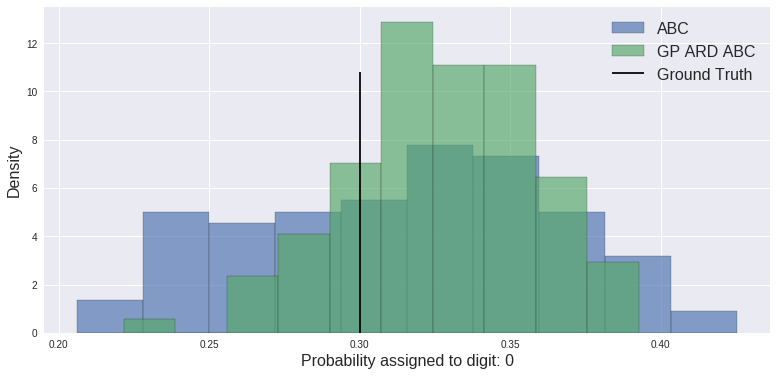

In [0]:
single_digit_result_histogram([larger_sample_results, gp_ard_results], ['ABC', 'GP ARD ABC'], top_k=100)

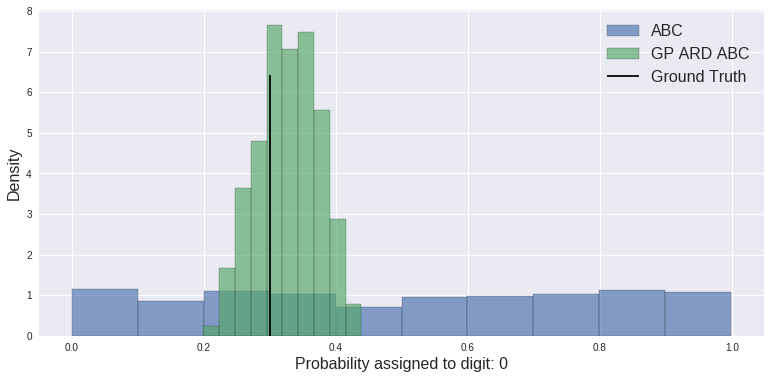

In [0]:
single_digit_result_histogram([larger_sample_results, gp_ard_results], ['ABC', 'GP ARD ABC'], top_k=1000)

The results are pretty interesting - the top result isn't quite as accurate, but the top 10, 100, and especially 1000 are better. 

Let's try training the GP further and seeing what that does:

In [0]:
abc_opt_ard_two_digits.optimize(100)

At iteration 1, proposed tensor([[5.6859, 3.9776, 3.6041, 5.1133, 6.4633, 6.0463, 6.1411, 1.5871, 1.6747,
         1.7888, 0.9807, 4.8380, 8.6143, 0.1235, 8.3177, 9.9250, 7.1081, 8.2834,
         8.2141, 0.1652, 9.7612, 1.1495, 7.9124, 9.2993, 0.7872, 0.5381, 1.8865,
         6.9472, 9.0345, 7.0181, 2.8986, 0.1490, 8.0151, 4.2972, 2.2106, 7.6383,
         9.2656, 0.4932, 6.3844, 6.0891]]) => tensor([0.1089])


At iteration 2, proposed tensor([[6.5440, 5.6224, 9.5734, 0.7791, 9.1421, 1.8027, 6.4183, 7.6874, 9.0193,
         2.1709, 5.9102, 0.6754, 5.1875, 2.9895, 5.1294, 3.7515, 9.6972, 8.1331,
         5.4102, 5.2023, 2.3696, 4.0092, 8.8279, 0.2759, 5.0285, 4.3814, 7.4237,
         2.8450, 7.0269, 6.9817, 7.5621, 8.1995, 2.4125, 2.3281, 5.9610, 2.5772,
         6.7616, 7.5314, 4.9864, 8.4876]]) => tensor([0.1063])


At iteration 3, proposed tensor([[7.2917, 9.1988, 6.6075, 9.6039, 2.1846, 5.2096, 9.1719, 6.7915, 3.6290,
         8.9795, 1.2243, 1.9651, 9.4067, 9.8330, 6.7964, 9.5220, 5.2075, 4.8915,
         4.1169, 4.3046, 7.0848, 8.3859, 9.3245, 6.4869, 1.1361, 1.8722, 5.4830,
         5.0006, 4.2496, 5.7215, 1.2092, 7.4717, 4.5289, 3.2238, 8.2872, 4.0108,
         2.1505, 9.5231, 8.8588, 4.3375]]) => tensor([0.0739])


At iteration 4, proposed tensor([[6.3767, 1.7255, 7.3201, 1.6884, 9.8514, 0.8414, 3.7850, 5.5960, 3.0823,
         9.0129, 8.1906, 6.2276, 7.3334, 8.5212, 7.8016, 4.3215, 3.1897, 2.3356,
         0.6668, 8.8783, 4.9301, 4.9543, 6.6272, 3.8231, 9.1302, 8.4271, 2.4682,
         7.1264, 0.6890, 7.7143, 9.6347, 9.3059, 6.5800, 9.0155, 0.1536, 2.8762,
         7.0055, 0.8081, 1.2443, 3.6732]]) => tensor([0.0693])


At iteration 5, proposed tensor([[5.7680, 8.1853, 5.3170, 1.7698, 0.1324, 9.3278, 5.3694, 7.7130, 3.9304,
         1.0153, 6.5375, 5.5703, 4.5000, 3.0331, 8.8129, 4.8628, 6.7714, 9.1475,
         0.1727, 7.5929, 3.5030, 0.8410, 5.4376, 2.9236, 1.9133, 6.9209, 5.6509,
         3.2015, 9.7436, 2.0394, 7.1841, 3.0542, 0.4701, 9.9934, 2.2235, 4.4862,
         5.0965, 5.4396, 7.8569, 5.2496]]) => tensor([0.0634])


At iteration 6, proposed tensor([[8.8654, 8.9550, 3.0990, 5.8094, 4.8551, 6.6985, 1.2214, 1.0612, 3.8284,
         4.8511, 1.6107, 4.3818, 7.1719, 2.6016, 8.0738, 2.1003, 6.5980, 4.3483,
         5.1285, 9.2470, 2.6160, 1.9834, 4.7111, 4.2781, 6.2911, 7.5944, 7.1643,
         0.1710, 7.2449, 4.8179, 9.4512, 6.3264, 2.9370, 3.9770, 5.8468, 9.8613,
         5.7337, 3.2287, 2.0932, 3.1063]]) => tensor([0.0631])


At iteration 7, proposed tensor([[1.7533, 2.6392, 0.4770, 2.4421, 9.2896, 0.4072, 1.6118, 6.8793, 7.1806,
         2.5460, 0.3788, 4.4574, 8.2062, 8.5071, 1.3597, 8.8570, 1.9135, 4.0689,
         1.5489, 9.0178, 7.1178, 8.6008, 2.2858, 5.5329, 2.3033, 9.6299, 1.7268,
         8.7197, 5.3059, 8.4999, 1.9083, 6.7338, 5.5704, 9.3666, 7.9977, 7.4905,
         2.3034, 8.9315, 8.3911, 6.7318]]) => tensor([0.0794])


At iteration 8, proposed tensor([[8.0128, 1.2653, 1.0419, 8.1934, 0.8165, 8.0309, 5.2813, 1.1092, 0.5623,
         0.1869, 1.3849, 6.9082, 7.1180, 0.4527, 1.1018, 8.4771, 8.0644, 8.2391,
         3.6358, 3.4806, 5.7133, 8.7671, 1.5893, 9.2810, 0.5126, 5.5520, 8.5447,
         7.1013, 1.6420, 8.3665, 5.0724, 3.7486, 6.5957, 9.6075, 3.2683, 5.7393,
         2.6926, 4.6850, 2.7094, 2.3361]]) => tensor([0.0782])


At iteration 9, proposed tensor([[4.5998, 4.0880, 9.5626, 7.7877, 1.3374, 7.9655, 8.0951, 6.4477, 3.3943,
         3.6364, 5.6586, 1.3658, 9.9093, 6.8424, 9.1031, 1.6227, 5.9703, 9.5471,
         8.5555, 3.7160, 2.0088, 2.7990, 1.9397, 5.1012, 9.5684, 6.9892, 3.9853,
         8.5389, 2.6667, 9.6941, 4.8149, 3.0330, 2.1545, 2.6191, 2.7594, 3.8963,
         3.6793, 4.2202, 2.9425, 1.8470]]) => tensor([0.0423])


At iteration 10, proposed tensor([[7.6733, 0.2900, 8.3193, 9.8904, 8.2837, 9.1265, 1.8412, 8.3557, 5.9687,
         2.9687, 4.5264, 4.2195, 6.9751, 6.2689, 7.3407, 0.2002, 1.2071, 3.4763,
         9.1327, 0.4261, 0.7415, 4.9349, 9.3696, 7.0295, 3.8260, 3.4691, 4.6049,
         8.9523, 8.3245, 7.7631, 3.2260, 6.8629, 2.2450, 1.3142, 6.2223, 7.0138,
         1.8612, 6.4671, 8.3224, 2.3813]]) => tensor([0.0692])


At iteration 11, proposed tensor([[2.4248, 7.0244, 9.6345, 7.3719, 7.3180, 4.1216, 8.2107, 4.0682, 5.6191,
         2.0738, 6.1812, 8.0284, 1.7193, 7.2667, 2.0767, 5.0192, 1.0261, 3.8972,
         5.5566, 8.4378, 1.6703, 9.3960, 0.2902, 0.4028, 7.0876, 7.8133, 2.3573,
         2.8854, 8.2287, 8.5651, 5.6741, 5.1149, 3.9677, 9.2141, 6.4882, 8.6021,
         8.7318, 2.9367, 4.2149, 6.1045]]) => tensor([0.0632])


At iteration 12, proposed tensor([[1.8513, 7.7691, 5.7291, 3.0951, 3.7002, 0.8904, 9.3438, 8.4081, 1.6662,
         6.5613, 8.0219, 2.9455, 5.7273, 9.7196, 4.8144, 8.2815, 4.4330, 4.6150,
         8.8188, 3.4277, 9.0987, 9.1433, 5.8784, 9.6761, 8.3766, 5.6189, 9.4762,
         3.1435, 1.7665, 1.0351, 7.2144, 7.8390, 5.5766, 1.3498, 1.9742, 5.5111,
         0.8825, 4.5183, 4.5606, 5.5265]]) => tensor([0.0819])


At iteration 13, proposed tensor([[3.4698, 4.2494, 1.2436, 3.6980, 6.1564, 5.9692, 7.2174, 4.5622, 1.3889,
         1.2262, 9.9347, 5.8335, 5.5060, 2.1508, 1.3038, 4.6011, 0.6062, 9.5788,
         6.9946, 2.7549, 7.1136, 2.9557, 1.6560, 2.7873, 9.2596, 2.3588, 5.9552,
         0.4561, 1.1355, 8.6532, 4.8590, 8.9706, 0.7001, 2.1425, 5.0731, 6.8393,
         2.4206, 6.9091, 3.6143, 7.7634]]) => tensor([0.1000])


At iteration 14, proposed tensor([[2.3197, 1.5622, 8.6500, 4.4091, 7.8380, 3.0116, 4.1341, 0.7988, 2.2590,
         9.1755, 3.1466, 6.2612, 1.8656, 0.9832, 2.3530, 2.8036, 6.0969, 7.5069,
         9.2341, 3.3193, 1.8493, 0.1252, 8.4088, 1.5291, 4.9199, 7.4442, 8.8742,
         7.2608, 9.2657, 5.6251, 2.7347, 1.1249, 4.5338, 6.7399, 2.2743, 3.1286,
         5.2446, 0.6633, 0.3182, 4.1923]]) => tensor([0.0681])


At iteration 15, proposed tensor([[5.7306, 8.1524, 2.3999, 9.5495, 2.7410, 9.4107, 3.0197, 8.7613, 1.4661,
         6.5780, 4.1792, 6.2763, 9.0170, 0.6630, 3.0253, 7.6875, 7.3900, 4.7976,
         6.8285, 6.2826, 1.3095, 2.5302, 2.5602, 1.5218, 7.7071, 9.6719, 2.6717,
         8.3794, 1.0740, 8.5049, 2.1316, 7.6895, 4.6590, 0.8715, 8.8733, 6.6953,
         7.0698, 2.7174, 7.7348, 7.1118]]) => tensor([0.0922])


At iteration 16, proposed tensor([[7.9829, 8.1999, 7.8873, 7.1279, 9.1230, 1.1537, 3.1056, 4.9461, 6.5654,
         1.5991, 5.5620, 1.8589, 9.9133, 8.6602, 2.8009, 8.3773, 5.3914, 4.3489,
         6.5019, 1.1348, 1.5881, 4.7903, 7.9485, 5.1856, 7.2503, 8.4271, 0.8473,
         5.2866, 7.8447, 8.5024, 1.4291, 7.9210, 9.0697, 1.7603, 7.5142, 7.7722,
         1.6264, 5.8511, 7.9591, 0.3590]]) => tensor([0.0487])


At iteration 17, proposed tensor([[1.3867, 0.6025, 9.8963, 3.0664, 4.1986, 2.5330, 8.3390, 9.7714, 1.7201,
         7.8950, 0.6264, 2.7041, 7.9929, 9.4518, 7.4877, 1.4255, 8.7119, 4.2637,
         5.8075, 3.2433, 5.7100, 4.3320, 3.1878, 2.4213, 5.5540, 3.1438, 8.3876,
         5.2878, 2.1318, 5.9620, 7.5016, 6.3031, 5.5222, 8.0314, 7.9311, 9.0794,
         9.0141, 6.7605, 2.2042, 6.1390]]) => tensor([0.0573])


At iteration 18, proposed tensor([[0.4967, 6.9449, 3.3987, 9.3743, 6.0394, 5.7595, 2.2433, 4.7463, 6.5689,
         0.2680, 4.7501, 2.3896, 9.7919, 8.0974, 2.2716, 6.3889, 4.1969, 9.4536,
         7.6122, 0.1193, 7.0185, 7.0489, 0.5705, 6.4397, 2.0895, 2.0795, 1.8993,
         5.5386, 1.3484, 2.0972, 1.5606, 0.1147, 5.6542, 5.3905, 7.6883, 7.9489,
         1.0602, 7.7477, 4.0339, 7.6701]]) => tensor([0.1129])


At iteration 19, proposed tensor([[0.2289, 1.3479, 6.4211, 4.2728, 6.5110, 3.7403, 3.5474, 4.0669, 3.5685,
         2.7451, 0.3234, 2.9958, 9.6030, 0.1072, 2.3206, 3.1975, 3.2210, 3.7543,
         4.1056, 7.6555, 6.0048, 3.3979, 3.1114, 8.1370, 1.9538, 6.1779, 8.1172,
         2.6348, 7.5838, 8.3264, 5.6689, 7.2045, 6.4204, 6.9757, 6.0254, 7.6943,
         7.7926, 2.6957, 6.9865, 1.4765]]) => tensor([0.1052])


At iteration 20, proposed tensor([[0.9631, 2.0502, 3.3523, 5.2155, 8.5245, 4.7341, 0.9861, 2.3649, 2.1140,
         1.9442, 6.1177, 5.0060, 2.3064, 9.2344, 9.5415, 8.2484, 5.8664, 9.7051,
         1.4139, 6.3754, 4.0316, 0.9655, 6.6434, 4.2619, 7.9595, 5.4355, 1.5629,
         9.6374, 8.7954, 5.5115, 9.2823, 9.9374, 4.1238, 1.9327, 1.5206, 2.6193,
         4.1138, 1.7957, 2.6211, 6.4911]]) => tensor([0.0522])


At iteration 21, proposed tensor([[8.1654, 6.1213, 8.1596, 3.8648, 4.2942, 8.4757, 2.4805, 4.4651, 7.3234,
         7.6207, 7.9536, 4.8365, 0.9063, 1.7176, 2.2442, 7.3524, 0.4571, 0.9615,
         9.5922, 4.6002, 3.3111, 7.4846, 0.7870, 3.6614, 9.4008, 3.9332, 9.2330,
         1.0806, 8.2863, 1.6800, 7.9916, 3.8610, 9.1309, 3.8054, 5.4782, 5.5762,
         0.2812, 5.1904, 8.6289, 5.4245]]) => tensor([0.0445])


At iteration 22, proposed tensor([[1.1683, 2.2313, 7.1236, 6.6884, 4.8745, 3.1485, 1.7586, 8.4278, 1.0302,
         4.3146, 2.8549, 6.7182, 3.2184, 4.5127, 0.9881, 8.3168, 7.3325, 4.6004,
         5.0541, 4.6552, 1.3040, 0.8119, 5.7462, 0.8293, 5.9545, 4.4056, 6.6694,
         5.5144, 4.9020, 6.2445, 3.1021, 2.2888, 8.1212, 2.3707, 6.1686, 6.0810,
         9.8464, 7.6714, 9.8273, 1.4721]]) => tensor([0.0556])


At iteration 23, proposed tensor([[5.0978, 7.8816, 5.6625, 4.2321, 2.4879, 5.8302, 8.8289, 6.2670, 0.2762,
         0.5026, 5.0697, 0.8363, 3.2872, 7.2371, 3.8508, 5.7237, 0.4812, 8.8253,
         8.8743, 3.8907, 7.7816, 3.0064, 2.2277, 7.1847, 8.2741, 4.4482, 4.2699,
         2.7397, 0.1769, 8.3318, 3.6844, 9.5033, 0.3460, 0.6846, 6.7707, 1.9605,
         6.5918, 0.9003, 5.7549, 7.5693]]) => tensor([0.0731])


At iteration 24, proposed tensor([[9.1275, 0.9649, 6.0013, 8.8036, 7.4228, 8.7974, 7.3986, 6.5610, 2.8633,
         3.6590, 8.6715, 6.8505, 3.1853, 2.1233, 3.1677, 5.0263, 9.9391, 1.4084,
         8.1877, 3.9375, 1.9826, 5.9811, 8.4798, 0.4209, 3.5452, 6.8303, 0.9996,
         8.3358, 2.0993, 4.4702, 1.3208, 0.7546, 7.6006, 8.2797, 2.0991, 5.1833,
         3.4753, 8.0637, 0.3027, 4.7011]]) => tensor([0.0572])


At iteration 25, proposed tensor([[3.3670, 7.9708, 1.5335, 4.9129, 9.4109, 2.2042, 0.4758, 6.6282, 7.7717,
         4.0408, 1.7057, 6.3554, 4.2994, 0.8504, 0.6557, 4.5303, 1.5611, 8.7304,
         1.5533, 2.4866, 3.5638, 4.0346, 2.2036, 7.7209, 6.8378, 4.1113, 6.5642,
         5.7648, 4.5771, 3.7283, 6.3968, 2.5697, 4.8852, 8.6495, 8.3175, 2.7833,
         8.4480, 5.4134, 3.8841, 9.0646]]) => tensor([0.0490])


At iteration 26, proposed tensor([[5.7282, 8.0842, 4.7110, 9.3171, 2.6802, 2.2102, 5.2315, 7.7255, 7.5902,
         3.9548, 4.8119, 0.4710, 4.1299, 3.7723, 3.8341, 0.6613, 2.8865, 4.6147,
         7.5428, 1.7623, 8.9447, 2.7978, 4.3528, 0.6894, 7.1967, 0.4831, 3.9066,
         7.3354, 7.2559, 8.6158, 7.2779, 0.3197, 9.9481, 4.1520, 2.2361, 8.8372,
         1.7038, 3.9191, 3.5454, 6.5026]]) => tensor([0.0589])


At iteration 27, proposed tensor([[2.6540, 6.5794, 2.0117, 2.4508, 7.3209, 8.3648, 8.6622, 5.3844, 6.7217,
         5.9165, 5.8097, 1.8193, 8.2643, 5.6813, 5.4066, 2.1930, 4.2452, 9.6678,
         7.6743, 4.2493, 5.2026, 4.6879, 0.6291, 3.2307, 9.3254, 7.6256, 4.9833,
         0.1495, 0.1078, 8.5483, 2.3559, 2.5410, 3.6149, 1.6360, 1.9000, 3.4457,
         8.7861, 1.9136, 7.4080, 6.9359]]) => tensor([0.0780])


At iteration 28, proposed tensor([[3.7459, 6.0451, 0.2579, 1.9745, 5.7108, 3.5269, 3.6188, 1.2988, 1.9547,
         2.7413, 8.4259, 5.0698, 1.8686, 8.1975, 8.1077, 5.2022, 9.3993, 5.5059,
         1.3181, 6.9615, 6.7422, 3.2106, 1.8439, 8.5568, 1.3708, 8.6606, 6.2433,
         3.1399, 3.8880, 0.4576, 7.6809, 9.1829, 9.8289, 1.6819, 9.2455, 5.6587,
         4.5248, 3.5561, 6.4261, 8.1328]]) => tensor([0.0980])


At iteration 29, proposed tensor([[7.4655, 7.1461, 8.6602, 5.0366, 8.4923, 3.0216, 0.5969, 8.0500, 5.5342,
         9.6486, 8.4132, 0.8854, 2.9816, 3.0533, 7.0839, 4.9450, 9.7127, 7.8799,
         3.8884, 6.4042, 6.6211, 7.0061, 5.5733, 1.5446, 5.1457, 6.4136, 2.8880,
         4.3942, 2.6862, 9.5378, 0.5450, 0.7676, 4.5339, 0.3477, 9.4326, 4.3771,
         5.6447, 8.7654, 6.5914, 5.0909]]) => tensor([0.0657])


At iteration 30, proposed tensor([[4.5611, 2.3684, 7.2952, 0.6637, 6.6766, 9.9600, 9.2698, 8.8745, 5.0005,
         1.4663, 9.3270, 0.2887, 7.4802, 5.4722, 4.9711, 0.4526, 6.1184, 5.1219,
         8.4599, 7.3702, 1.6422, 1.4454, 4.4209, 5.3615, 1.7502, 9.7101, 2.3799,
         2.4121, 2.1226, 0.6460, 3.6681, 8.1895, 7.1246, 8.2676, 6.2281, 2.6515,
         9.7660, 9.9664, 7.7745, 5.7217]]) => tensor([0.0766])


At iteration 31, proposed tensor([[6.8816, 8.7676, 5.2947, 1.6756, 2.0734, 7.8283, 4.5222, 8.1790, 2.4611,
         1.9055, 9.6649, 9.7188, 7.1532, 7.5914, 9.4313, 1.2545, 9.3421, 3.6062,
         9.6753, 0.3084, 6.2083, 6.1690, 9.2172, 7.1625, 0.2723, 3.5743, 8.3140,
         5.8219, 8.0966, 4.5262, 6.4280, 7.2624, 9.7689, 4.1069, 1.0592, 7.3101,
         4.2369, 1.9629, 0.9719, 7.6922]]) => tensor([0.1080])


At iteration 32, proposed tensor([[4.0848, 7.7186, 3.3499, 3.7735, 4.0278, 0.7085, 8.5042, 4.4031, 9.7635,
         6.5207, 1.9893, 3.1718, 0.9988, 8.2918, 9.4561, 9.4697, 9.3114, 9.8638,
         1.0359, 7.2447, 5.1907, 5.6845, 9.7309, 2.3371, 5.0329, 6.5520, 0.8886,
         1.4135, 3.8645, 3.6398, 5.5546, 6.5086, 9.6521, 8.4070, 6.0496, 9.5083,
         9.3172, 6.3006, 2.5276, 0.6623]]) => tensor([0.0591])


At iteration 33, proposed tensor([[9.3322, 0.7908, 4.5323, 4.8553, 9.3977, 8.5416, 7.2212, 2.9873, 0.9773,
         6.5459, 5.4747, 3.2817, 6.8856, 1.4536, 9.8504, 8.1103, 4.4429, 7.4226,
         7.9014, 6.5422, 1.7506, 5.4094, 1.3041, 2.5472, 0.8511, 8.9117, 2.7427,
         2.0516, 3.9556, 6.5342, 2.0835, 8.8179, 4.7287, 1.8567, 9.9849, 4.5794,
         4.1050, 0.6345, 4.5099, 9.5342]]) => tensor([0.0501])


At iteration 34, proposed tensor([[4.8912, 4.2958, 3.0613, 2.9061, 7.0933, 8.7940, 8.2593, 5.4994, 5.6058,
         8.6374, 5.9512, 3.3465, 3.3318, 7.8362, 7.6929, 2.2838, 3.5369, 3.4247,
         9.0874, 2.4894, 2.9215, 8.9805, 0.1224, 1.6081, 8.1323, 5.1103, 5.9519,
         8.9322, 2.7325, 9.3621, 1.3666, 4.1317, 8.2243, 8.6443, 6.6072, 1.5371,
         2.9866, 2.4815, 2.4688, 7.5893]]) => tensor([0.0560])


At iteration 35, proposed tensor([[6.7548, 1.3166, 5.3077, 1.8385, 7.4154, 2.6171, 4.9632, 6.7196, 9.4234,
         0.8141, 3.2064, 2.3277, 7.9286, 7.1972, 7.9974, 5.4087, 4.0435, 9.9462,
         7.4276, 8.9644, 0.9319, 4.0236, 7.2829, 3.5784, 3.2239, 2.2348, 4.6957,
         8.0140, 6.1578, 2.8940, 3.7919, 6.2557, 7.4848, 4.1988, 6.8565, 5.1209,
         2.4199, 5.3418, 3.8672, 9.7821]]) => tensor([0.0619])


At iteration 36, proposed tensor([[7.7659, 1.7185, 3.8294, 7.4915, 9.0964, 2.4617, 3.6508, 2.1654, 5.7741,
         0.3959, 7.2301, 1.6708, 5.2285, 1.7125, 0.2302, 8.0132, 8.4671, 9.7186,
         0.4033, 8.2385, 4.9148, 5.0064, 2.4639, 7.7718, 4.5333, 1.4060, 0.7956,
         2.6946, 5.0651, 1.4131, 8.9663, 1.3169, 1.8474, 5.5441, 8.1148, 1.0714,
         3.3125, 1.7519, 0.6916, 3.1804]]) => tensor([0.0714])


At iteration 37, proposed tensor([[6.3973, 0.4948, 8.7441, 0.8663, 4.7858, 9.3297, 9.8958, 0.4189, 9.1616,
         3.5440, 5.1612, 0.8471, 0.5825, 6.4993, 6.1719, 0.3983, 1.1236, 1.2498,
         5.2010, 3.2235, 9.3896, 2.4862, 8.9830, 5.5404, 5.5568, 3.8876, 3.3616,
         5.9978, 6.4255, 8.1013, 3.4565, 0.5442, 2.0724, 2.5015, 2.8721, 3.0155,
         7.7022, 2.4996, 5.1750, 4.7931]]) => tensor([0.0864])


At iteration 38, proposed tensor([[9.5215, 3.3709, 7.8236, 5.5704, 3.3288, 3.9085, 3.9194, 3.2971, 9.2717,
         3.0472, 9.5882, 9.2099, 8.8932, 4.5222, 6.3529, 7.7055, 3.6696, 1.0437,
         6.5547, 1.5252, 2.0130, 3.6546, 2.4402, 8.2180, 3.9532, 5.4922, 1.6977,
         0.1788, 2.2848, 3.5884, 3.0986, 5.9534, 8.6609, 9.2046, 3.4108, 9.4882,
         9.2140, 8.6324, 7.6861, 4.4753]]) => tensor([0.0534])


At iteration 39, proposed tensor([[0.3123, 8.7031, 0.2199, 8.1680, 6.5641, 8.7100, 6.9114, 9.8850, 0.2451,
         3.9914, 8.8558, 9.6747, 1.6911, 6.9211, 4.9862, 6.5347, 3.5372, 6.2983,
         6.0860, 0.6347, 0.3827, 5.7120, 3.7669, 7.9146, 0.7571, 7.6211, 6.8393,
         4.1876, 3.4533, 1.1775, 0.8367, 5.1075, 3.8937, 9.0818, 5.4964, 3.4528,
         3.9547, 8.5528, 3.0861, 5.1375]]) => tensor([0.0423])


At iteration 40, proposed tensor([[5.4830, 6.1948, 4.6812, 6.5396, 6.7594, 7.9800, 2.9523, 0.5983, 2.9672,
         9.5830, 8.3039, 0.1089, 7.5124, 6.6537, 4.4772, 4.2265, 4.5674, 9.7369,
         2.7979, 7.1173, 9.8884, 1.5625, 6.9703, 9.6090, 7.6058, 9.4564, 4.6628,
         1.3991, 6.0921, 3.9855, 1.8106, 0.6667, 7.6484, 5.6883, 0.1915, 5.3655,
         4.2172, 3.1687, 1.1754, 4.8829]]) => tensor([0.0856])


At iteration 41, proposed tensor([[5.7876, 4.2003, 9.7637, 8.1396, 5.8327, 7.2061, 1.4061, 7.0106, 6.2992,
         1.1680, 7.7535, 3.9359, 9.5821, 2.8903, 3.2748, 9.4386, 2.6698, 7.5822,
         1.2631, 7.7500, 9.5180, 9.9074, 3.9506, 2.3332, 7.8975, 5.0231, 7.6254,
         2.8698, 1.9584, 4.8964, 8.9920, 4.0819, 5.7409, 8.1712, 8.2116, 0.2202,
         0.6093, 2.6382, 3.0558, 7.4465]]) => tensor([0.0942])


At iteration 42, proposed tensor([[3.9540, 7.4563, 3.3416, 5.2634, 1.4169, 5.7466, 8.5058, 0.1770, 8.2652,
         0.4846, 1.8182, 7.9410, 7.5769, 2.6310, 1.2720, 0.5763, 5.1264, 1.9290,
         8.7526, 7.4614, 4.6103, 3.3098, 6.1134, 6.5481, 5.1620, 1.7711, 8.2978,
         4.6926, 3.4047, 7.9253, 0.3081, 1.0410, 9.0584, 0.6650, 0.3887, 1.3831,
         2.1116, 0.8796, 5.8034, 8.0774]]) => tensor([0.0673])


At iteration 43, proposed tensor([[7.1560, 2.5171, 2.1374, 6.3303, 5.0343, 0.3329, 2.4427, 5.6887, 6.8698,
         1.6377, 7.5547, 3.2305, 6.2583, 6.5518, 4.0140, 4.7869, 5.8460, 7.6605,
         8.4711, 7.1022, 5.0647, 4.4910, 8.5413, 0.6951, 0.8592, 7.2816, 2.0048,
         4.1115, 9.4329, 2.8294, 9.3994, 5.0905, 6.9763, 4.5289, 8.1213, 7.9552,
         4.6129, 9.3881, 7.1802, 9.3048]]) => tensor([0.0688])


At iteration 44, proposed tensor([[8.7160, 2.9419, 6.3575, 1.5128, 4.2476, 7.2459, 3.3126, 4.7204, 3.9899,
         3.0608, 4.5761, 1.0226, 5.3290, 6.8422, 8.2605, 3.6954, 2.7423, 5.4960,
         2.3722, 0.8861, 1.3548, 0.3789, 7.9811, 5.6065, 3.5935, 2.2558, 8.9288,
         8.4595, 9.6793, 4.5835, 5.1749, 4.8915, 9.0220, 2.0303, 6.8259, 9.8866,
         4.2426, 1.7894, 9.8739, 9.2371]]) => tensor([0.0868])


At iteration 45, proposed tensor([[9.2915, 7.4288, 4.3288, 5.7450, 8.5087, 9.6959, 4.5330, 6.0989, 9.9906,
         3.8366, 8.0494, 8.1026, 2.9986, 9.0677, 2.3816, 4.5332, 5.9115, 4.0406,
         9.9071, 4.4534, 3.5594, 9.4909, 8.4907, 0.9870, 9.3147, 7.2095, 6.4145,
         7.9827, 8.8162, 9.4110, 6.1152, 4.0295, 5.7933, 8.8510, 4.4230, 4.5029,
         1.5966, 9.6979, 2.2266, 8.0629]]) => tensor([0.0621])


At iteration 46, proposed tensor([[6.4634, 2.8613, 6.4728, 2.3211, 1.5252, 3.5625, 7.4738, 0.1293, 9.9632,
         7.0526, 9.2318, 7.7754, 1.6398, 5.7006, 6.7502, 1.1528, 3.3218, 6.6727,
         3.4826, 9.6486, 1.2414, 4.5753, 4.5131, 6.5110, 3.8120, 0.5528, 2.1415,
         1.1424, 4.2055, 0.2652, 0.4268, 4.8661, 9.3002, 7.8948, 5.1893, 8.6268,
         3.2232, 4.0043, 8.8335, 1.9369]]) => tensor([0.1048])


At iteration 47, proposed tensor([[8.1417, 4.0901, 7.9197, 8.9721, 6.1796, 8.4763, 4.0634, 9.6058, 0.4165,
         8.7570, 7.1472, 5.7764, 0.7202, 7.9777, 2.2271, 3.7984, 6.7576, 1.6952,
         9.8606, 5.8573, 0.8209, 0.3201, 6.9448, 8.0731, 9.4430, 2.8017, 7.5731,
         3.8087, 5.3870, 2.8528, 4.9333, 1.5492, 9.6690, 4.5490, 5.0233, 8.1650,
         5.6153, 9.1790, 8.7311, 2.5289]]) => tensor([0.0541])


At iteration 48, proposed tensor([[3.4654, 9.4994, 3.3930, 3.7337, 5.1004, 4.6012, 4.0135, 9.9862, 1.8424,
         1.9955, 0.9474, 8.2765, 8.2210, 3.6888, 3.3973, 7.2017, 5.6622, 1.6682,
         5.6331, 8.8001, 9.6872, 7.7177, 1.3658, 9.1669, 5.0452, 3.1628, 4.9414,
         8.8453, 0.8852, 3.1695, 1.4039, 1.2660, 2.9887, 5.8558, 5.0862, 2.2069,
         4.8604, 6.1020, 4.3428, 3.2345]]) => tensor([0.0635])


At iteration 49, proposed tensor([[6.8900, 9.6667, 8.3080, 7.6884, 6.4095, 8.5121, 5.6547, 5.0140, 9.4481,
         2.2398, 3.6659, 4.5793, 0.1932, 9.1914, 1.3845, 4.9371, 8.9606, 5.0020,
         7.8597, 9.4773, 7.5651, 3.1895, 1.3226, 5.9665, 4.3406, 0.3758, 6.8574,
         9.1894, 8.4260, 2.7667, 9.0957, 2.2914, 3.3711, 9.6441, 5.1874, 9.6033,
         7.3950, 0.2160, 2.2837, 2.7018]]) => tensor([0.0990])


At iteration 50, proposed tensor([[7.4391, 3.2392, 8.0660, 5.6174, 8.9605, 2.5224, 4.7927, 6.7493, 4.3630,
         0.9660, 3.0632, 4.7844, 4.3859, 7.2738, 2.3819, 0.3155, 2.8834, 2.4313,
         6.4344, 9.5689, 6.5671, 1.6557, 9.1735, 0.2358, 7.8369, 8.3859, 6.8376,
         3.7186, 6.2703, 1.1947, 9.8400, 6.8228, 8.5148, 3.0262, 9.9988, 4.3209,
         2.5027, 6.5825, 9.6073, 8.8440]]) => tensor([0.0833])


At iteration 51, proposed tensor([[7.6379, 4.3491, 2.7243, 1.6794, 4.6458, 2.8006, 8.6435, 8.6707, 1.4106,
         8.7948, 2.4565, 3.0580, 0.9567, 9.0685, 7.4591, 0.8237, 8.4248, 1.8590,
         0.9894, 4.2052, 8.9650, 3.2577, 8.3347, 6.4284, 1.5316, 5.9489, 2.4697,
         8.9074, 1.0680, 0.6447, 0.6760, 8.1206, 9.7327, 2.5771, 9.8620, 3.0428,
         2.6131, 0.3393, 0.1992, 8.1076]]) => tensor([0.0897])


At iteration 52, proposed tensor([[5.8517, 3.1665, 3.8849, 6.1350, 5.9616, 1.5580, 4.1025, 8.2233, 6.1666,
         8.1078, 5.4481, 2.8049, 6.6137, 4.6882, 6.6937, 7.0230, 8.4849, 5.3768,
         6.8254, 2.5245, 7.7593, 2.7995, 5.2892, 8.9957, 1.0922, 5.5315, 6.1628,
         5.7323, 8.1121, 7.6666, 1.1313, 2.3758, 5.4299, 6.4521, 4.4554, 0.7568,
         2.5772, 5.3062, 3.3742, 9.0271]]) => tensor([0.0522])


At iteration 53, proposed tensor([[6.6565, 3.8091, 1.9570, 1.3846, 4.3829, 8.6323, 5.5730, 0.6380, 1.3757,
         3.9101, 4.8656, 6.5353, 4.6052, 2.9461, 7.3953, 6.8785, 6.4084, 6.3774,
         8.9444, 9.7024, 5.9813, 7.4157, 1.7272, 8.4372, 2.5554, 3.8367, 0.7113,
         9.3312, 7.5940, 3.6620, 0.7959, 3.7846, 3.3445, 9.0705, 9.6778, 8.7818,
         7.3189, 2.1061, 8.9822, 3.1845]]) => tensor([0.0720])


At iteration 54, proposed tensor([[6.6762, 4.9687, 0.6590, 5.6962, 6.0488, 3.6293, 8.0738, 2.3743, 9.4070,
         2.3528, 6.2996, 5.9701, 7.0557, 6.7213, 3.0989, 2.8493, 5.1395, 1.5727,
         0.5878, 3.8715, 5.8072, 8.8041, 4.5092, 5.9111, 7.7425, 0.4172, 5.1084,
         6.2706, 6.1804, 5.1960, 6.1169, 7.4719, 7.7594, 8.2164, 2.3340, 3.5384,
         0.2195, 8.7158, 3.5184, 5.0778]]) => tensor([0.0774])


At iteration 55, proposed tensor([[6.6652, 6.9438, 7.4649, 4.8044, 4.1362, 9.5086, 5.9572, 4.0325, 4.9353,
         1.7857, 8.8103, 6.9799, 9.8823, 4.6321, 8.2547, 5.7576, 7.9360, 4.5813,
         3.8386, 5.6735, 5.1742, 9.2665, 4.9639, 0.6399, 5.3753, 0.9416, 3.2764,
         6.8387, 2.0989, 1.7123, 7.4710, 5.4085, 3.6670, 4.0074, 1.6109, 9.2298,
         1.4653, 0.9269, 6.7810, 8.4665]]) => tensor([0.0849])


At iteration 56, proposed tensor([[2.6238, 6.9090, 7.9462, 0.6850, 5.9856, 7.6146, 8.9412, 8.5850, 3.8816,
         5.4433, 8.2260, 2.5570, 8.6209, 7.8603, 0.9064, 4.6826, 6.3001, 5.1379,
         6.6306, 4.6717, 6.9504, 7.2257, 3.6316, 4.2465, 6.3709, 3.0858, 4.6915,
         0.3903, 9.5635, 4.8681, 6.5607, 8.2094, 1.7012, 4.9383, 1.3767, 8.9931,
         6.2635, 2.9999, 7.6386, 3.9804]]) => tensor([0.0624])


At iteration 57, proposed tensor([[2.8011, 5.7263, 3.8081, 7.0187, 8.7754, 2.1915, 5.4998, 6.7781, 4.4194,
         5.5991, 3.6916, 0.9689, 8.8892, 5.8678, 2.9363, 1.2099, 7.9381, 4.8510,
         8.9182, 9.7190, 3.8106, 2.3399, 1.1428, 0.2599, 0.5118, 5.5954, 9.1427,
         7.4402, 8.6734, 7.3381, 4.9418, 8.4705, 0.6426, 3.7612, 1.8704, 7.7804,
         7.3705, 2.8250, 5.7874, 3.6372]]) => tensor([0.0519])


At iteration 58, proposed tensor([[1.8799, 1.4147, 9.7624, 8.9489, 4.7976, 4.9047, 6.7080, 1.7063, 6.1758,
         4.9309, 1.1907, 3.5363, 0.3883, 9.5694, 0.4421, 1.2528, 4.7650, 5.4543,
         5.9522, 9.0098, 4.8994, 5.3374, 1.4242, 8.1040, 9.1592, 7.6415, 0.3610,
         3.2230, 7.3149, 8.8181, 9.3441, 7.5660, 7.4342, 3.0035, 3.3833, 1.3807,
         2.7674, 5.5671, 0.6492, 7.8347]]) => tensor([0.0740])


At iteration 59, proposed tensor([[1.1586, 8.5934, 9.8402, 1.4956, 4.7385, 3.4821, 4.2905, 4.0120, 7.3332,
         2.9790, 1.6987, 9.1703, 4.1917, 8.5943, 6.1284, 2.7121, 5.3413, 7.2441,
         6.1566, 3.3552, 5.6401, 4.2403, 4.5813, 3.0089, 9.1604, 0.3162, 7.3450,
         6.4225, 5.7247, 7.8073, 6.4359, 6.3536, 2.4662, 3.7090, 4.3848, 3.5779,
         4.7223, 0.5277, 1.4217, 9.0027]]) => tensor([0.0662])


At iteration 60, proposed tensor([[2.9052, 5.5205, 5.0774, 3.7756, 6.7588, 5.2428, 7.3177, 4.5274, 6.9217,
         0.9219, 3.5432, 8.9711, 4.6031, 1.2489, 6.4546, 2.8995, 3.0415, 8.1498,
         9.0859, 9.8724, 4.6801, 7.8438, 1.5105, 4.5377, 7.7258, 4.5290, 4.3917,
         6.6778, 0.9770, 8.3865, 9.6131, 8.1511, 5.8066, 0.6451, 6.3979, 5.1578,
         6.0249, 5.9692, 9.3966, 4.9779]]) => tensor([0.0759])


At iteration 61, proposed tensor([[1.2494, 5.7022, 2.8489, 6.3421, 1.3930, 8.4962, 0.6734, 5.4598, 7.7507,
         6.6406, 4.7521, 8.3983, 9.0475, 0.4668, 5.9557, 3.6545, 9.7225, 3.2791,
         6.2356, 4.4151, 0.8584, 7.1800, 4.3312, 9.1630, 7.6517, 4.0040, 4.1665,
         1.0389, 3.8016, 0.6334, 3.6262, 1.4411, 5.6003, 7.0324, 1.8101, 4.3290,
         2.6458, 3.6881, 4.9931, 2.7976]]) => tensor([0.0486])


At iteration 62, proposed tensor([[9.7266, 1.4139, 4.6021, 5.6950, 0.4532, 7.4753, 3.8091, 5.1361, 6.8429,
         3.0654, 1.7909, 2.0496, 4.7121, 2.7408, 5.6855, 9.4332, 8.2731, 8.5458,
         6.1327, 6.2500, 9.4226, 8.7719, 3.0357, 6.4535, 4.7980, 8.1229, 2.1662,
         5.9862, 8.8596, 1.2862, 1.7906, 8.0929, 3.3017, 1.9649, 6.3908, 6.8129,
         1.6078, 6.4785, 6.1145, 8.8938]]) => tensor([0.0448])


At iteration 63, proposed tensor([[9.8391, 2.6734, 0.1460, 1.2843, 3.2564, 2.3527, 2.9275, 4.9219, 3.5801,
         7.6010, 1.7715, 1.9771, 3.0949, 4.4015, 7.3915, 9.1555, 6.1679, 2.8771,
         4.6051, 9.2319, 6.2586, 0.5001, 2.9242, 1.3736, 0.1320, 8.2769, 9.3573,
         8.2326, 2.2539, 1.7570, 0.1683, 4.4686, 9.0909, 3.3972, 3.3853, 0.3163,
         0.1834, 7.8139, 7.1218, 4.4925]]) => tensor([0.0547])


At iteration 64, proposed tensor([[8.4026, 7.9231, 2.8827, 9.8576, 9.2220, 3.7756, 4.8838, 8.1547, 4.7824,
         8.1759, 1.4004, 0.4390, 7.9520, 7.1215, 6.3316, 1.8931, 3.5991, 4.5361,
         8.0658, 2.6298, 8.0028, 0.2775, 1.4260, 8.5166, 1.6530, 3.7244, 9.2366,
         6.0582, 9.6107, 5.4712, 0.8914, 7.6222, 2.1894, 0.8659, 9.7805, 5.9210,
         0.3351, 4.5107, 6.4751, 3.1224]]) => tensor([0.0511])


At iteration 65, proposed tensor([[3.1075, 9.5565, 4.3016, 3.4732, 2.9052, 7.9220, 9.4361, 6.7578, 6.9492,
         8.0788, 3.2480, 5.3304, 7.8659, 4.0777, 5.9012, 1.3203, 3.1404, 3.5335,
         5.5581, 4.9445, 9.2048, 9.7128, 6.1467, 9.0129, 2.4144, 1.0393, 2.6352,
         1.2756, 4.3390, 5.3014, 5.2957, 9.7342, 2.1483, 3.0637, 7.2707, 0.3601,
         1.3255, 3.5833, 4.8957, 0.8031]]) => tensor([0.0813])


At iteration 66, proposed tensor([[2.9150, 0.4964, 9.2415, 4.5203, 7.0749, 0.4825, 5.7225, 6.2494, 5.2318,
         4.0515, 4.8793, 6.7233, 8.3206, 6.2404, 8.9313, 8.1305, 2.4650, 7.5447,
         3.4720, 7.7462, 8.8804, 0.4521, 1.4074, 6.9112, 3.0702, 6.5142, 9.0161,
         7.7378, 7.2905, 4.1832, 9.1684, 5.4116, 8.9608, 5.6785, 3.0610, 9.5370,
         0.3465, 3.4923, 8.4965, 2.1552]]) => tensor([0.0932])


At iteration 67, proposed tensor([[0.2023, 3.1488, 9.9944, 1.3045, 5.9597, 2.5155, 3.4301, 6.9119, 5.2861,
         3.3280, 5.1631, 1.6300, 0.4369, 6.8844, 6.6091, 2.1616, 0.5895, 1.7129,
         1.6677, 2.5666, 5.6887, 8.0048, 2.3432, 9.0178, 0.4789, 0.8169, 4.3046,
         9.8873, 3.0449, 3.9418, 3.1870, 9.3636, 5.9215, 9.4237, 8.0789, 4.1479,
         2.1487, 3.9958, 2.6158, 4.2603]]) => tensor([0.0568])


At iteration 68, proposed tensor([[4.2401, 4.5449, 2.8335, 0.2184, 9.2508, 7.6011, 6.4876, 6.2569, 0.6359,
         9.4224, 7.0556, 2.6411, 9.5771, 5.1670, 9.0106, 9.2133, 6.1145, 9.3383,
         1.8874, 3.7649, 8.4118, 0.3018, 1.7545, 4.8062, 8.8253, 8.6509, 2.4564,
         4.8936, 4.5032, 7.4777, 0.7497, 2.3792, 4.8397, 9.9887, 5.1621, 2.6414,
         7.1854, 5.3882, 4.5497, 7.9551]]) => tensor([0.1019])


At iteration 69, proposed tensor([[1.3228, 7.9327, 6.7216, 2.8768, 4.1762, 7.2914, 3.4243, 0.4299, 1.4671,
         4.7503, 5.4394, 3.1013, 1.6875, 0.2619, 7.2727, 2.2002, 7.2343, 8.4838,
         6.2394, 6.5935, 7.3028, 2.0832, 4.8716, 8.1268, 2.1379, 0.7149, 4.1021,
         6.1524, 9.8914, 3.5816, 5.2384, 3.3188, 2.3576, 5.4927, 9.4883, 2.6531,
         1.5237, 9.3206, 8.7685, 9.6613]]) => tensor([0.0574])


At iteration 70, proposed tensor([[9.1813, 3.4597, 5.2815, 4.9372, 4.2970, 1.0292, 0.8601, 5.6836, 9.4925,
         0.8864, 5.1243, 7.6317, 3.0326, 5.1842, 0.2254, 9.5510, 8.3322, 6.9245,
         5.4795, 8.0150, 9.5941, 6.6044, 8.6110, 6.4184, 8.6567, 4.2830, 6.2185,
         5.3379, 0.3722, 8.1106, 1.8372, 4.3691, 9.3117, 2.6413, 9.4703, 3.9456,
         0.4428, 1.9632, 8.8494, 5.4870]]) => tensor([0.0475])


At iteration 71, proposed tensor([[2.3784, 9.0341, 8.9097, 4.2149, 3.2322, 7.4902, 0.6450, 3.5547, 5.8869,
         4.8752, 6.3897, 2.7912, 2.4707, 4.0334, 1.0120, 6.5253, 8.3024, 1.0535,
         3.0042, 7.1454, 7.3056, 8.1420, 8.3072, 8.9252, 8.1833, 0.7566, 6.2640,
         6.6629, 0.6202, 7.2394, 6.0346, 1.2619, 4.2637, 6.2157, 4.5768, 1.0808,
         9.3309, 1.8813, 3.3316, 1.2003]]) => tensor([0.0579])


At iteration 72, proposed tensor([[8.4609, 7.4128, 3.3975, 1.7822, 4.3199, 9.5653, 7.1893, 1.1084, 6.4823,
         4.8574, 9.7422, 8.0254, 8.8464, 9.0122, 6.2968, 8.1090, 7.9173, 3.8368,
         5.3341, 8.3227, 5.5567, 6.0827, 9.6660, 4.9558, 9.9784, 4.9865, 1.1653,
         2.1285, 8.2279, 3.3853, 0.8648, 3.6593, 6.5844, 3.2342, 4.6621, 1.3479,
         0.3826, 1.6200, 6.1654, 0.4390]]) => tensor([0.0650])


At iteration 73, proposed tensor([[4.5069, 8.7278, 2.5912, 5.5835, 4.8762, 2.8436, 8.6776, 4.7499, 5.4241,
         8.3830, 8.7410, 1.4541, 9.3748, 5.5812, 0.8447, 5.1831, 0.2703, 2.7592,
         5.3378, 7.5258, 0.4834, 4.0292, 2.8450, 9.4671, 3.2127, 8.1248, 0.1659,
         6.4954, 0.3255, 4.6482, 2.1308, 7.4229, 3.5632, 1.2171, 6.0081, 2.1125,
         6.1581, 4.6155, 7.8554, 7.8163]]) => tensor([0.0725])


At iteration 74, proposed tensor([[5.6949, 1.2066, 8.8835, 7.6689, 2.5689, 8.7731, 1.4228, 9.5922, 8.9199,
         1.4979, 7.1857, 2.0670, 2.0779, 5.3519, 8.4408, 7.4545, 6.2257, 2.2288,
         8.4718, 6.4068, 4.4804, 4.7859, 7.3211, 5.7616, 9.4291, 2.6445, 6.3569,
         3.1772, 2.3641, 0.2310, 8.0306, 6.6918, 6.5420, 2.1643, 8.5252, 8.0840,
         5.0563, 1.7901, 8.2966, 6.0410]]) => tensor([0.0660])


At iteration 75, proposed tensor([[7.4864, 0.8198, 2.4422, 8.7687, 2.0464, 9.7232, 0.1266, 9.5497, 6.9375,
         5.0287, 0.4349, 0.3951, 0.3598, 3.4454, 5.8717, 0.7399, 9.3170, 2.5412,
         0.1278, 9.7357, 3.5648, 0.8175, 5.5351, 8.4664, 1.3528, 6.0549, 2.2846,
         7.2755, 7.3379, 4.8839, 2.6186, 6.2572, 9.3137, 1.4331, 6.5834, 6.2191,
         9.7703, 2.2671, 3.5964, 2.3180]]) => tensor([0.0923])


At iteration 76, proposed tensor([[5.2078, 7.6040, 8.9696, 0.9216, 4.4277, 7.6455, 3.2908, 0.3616, 9.7369,
         9.0212, 3.3483, 1.5558, 1.2669, 7.4510, 0.6735, 6.2616, 2.2464, 8.4201,
         2.9902, 3.4034, 8.6313, 9.8883, 1.0808, 4.7375, 1.2666, 6.3666, 9.4446,
         5.6025, 2.7754, 8.6984, 3.4421, 7.8569, 2.1335, 5.4203, 8.6265, 3.6470,
         2.6894, 7.1189, 0.9562, 8.7011]]) => tensor([0.0730])


At iteration 77, proposed tensor([[4.5123, 2.5895, 5.8613, 0.1796, 5.5348, 2.4892, 7.6789, 1.1670, 4.0022,
         3.1073, 3.4067, 6.3290, 2.4413, 4.4032, 2.5600, 2.9094, 7.2584, 6.5805,
         9.1585, 8.9307, 2.9603, 8.6177, 1.8468, 3.0087, 4.8838, 8.6633, 9.3967,
         8.8632, 4.0115, 6.8303, 0.3518, 4.5710, 6.5376, 9.4112, 5.9411, 3.1141,
         3.4580, 8.4870, 2.0678, 7.7767]]) => tensor([0.1219])


At iteration 78, proposed tensor([[0.9427, 8.0108, 8.1374, 7.7917, 1.7235, 5.2148, 5.8985, 2.8129, 0.9011,
         4.8652, 0.6446, 6.1891, 5.1379, 5.4024, 3.7179, 1.9058, 1.8968, 1.9351,
         4.5481, 3.6224, 6.1078, 9.9830, 6.5089, 1.4701, 2.8063, 1.9567, 6.0110,
         8.2171, 0.6298, 1.7586, 1.9315, 2.4769, 9.8027, 9.6137, 1.4711, 9.7201,
         9.2972, 5.0650, 7.5438, 2.5105]]) => tensor([0.0618])


At iteration 79, proposed tensor([[0.3607, 7.8873, 4.9511, 0.8059, 2.0795, 3.9214, 7.9877, 9.1993, 8.7260,
         3.5409, 9.6950, 1.8339, 6.9192, 0.7564, 6.4886, 8.9811, 1.0547, 1.5317,
         9.2707, 2.3129, 3.3417, 2.2979, 4.5175, 3.8492, 7.3590, 9.9844, 4.7984,
         4.1868, 0.1636, 1.5245, 0.9362, 2.7775, 0.4981, 9.2998, 8.6931, 6.6592,
         7.3110, 3.3560, 4.6091, 2.3617]]) => tensor([0.0466])


At iteration 80, proposed tensor([[0.5124, 4.9861, 9.5442, 4.0913, 1.3055, 5.9551, 2.7194, 2.3975, 7.7458,
         5.9966, 0.8129, 8.2352, 7.2811, 2.3894, 8.3645, 5.5511, 6.3216, 2.0221,
         3.0839, 5.5140, 6.6859, 6.7155, 1.8613, 3.8930, 6.8154, 3.7828, 8.5142,
         0.4870, 8.5748, 7.7779, 5.2822, 6.9927, 1.7913, 5.0763, 8.9498, 2.1990,
         9.8384, 8.9307, 0.4098, 2.1262]]) => tensor([0.0484])


At iteration 81, proposed tensor([[9.2667, 4.8390, 4.6910, 5.8955, 5.8192, 6.6665, 5.4730, 4.9166, 6.5484,
         0.3689, 9.6113, 4.7026, 1.6017, 4.2228, 0.8745, 1.9135, 7.6310, 9.9491,
         7.9573, 6.5230, 8.7665, 4.3656, 6.8089, 9.6445, 1.6156, 3.5008, 9.2159,
         1.1887, 4.1321, 8.2372, 9.5442, 2.2086, 1.7367, 4.4745, 2.2689, 3.4305,
         3.9718, 7.7146, 0.5826, 1.8616]]) => tensor([0.0807])


At iteration 82, proposed tensor([[3.3041, 4.2911, 7.8815, 4.1686, 7.1723, 7.3203, 0.4945, 0.5467, 3.5107,
         6.5610, 4.8111, 9.6336, 4.4343, 0.9427, 6.1883, 1.3131, 1.8038, 9.8392,
         7.3955, 3.5895, 2.2823, 8.3753, 8.1492, 4.8208, 0.9010, 4.0550, 6.0420,
         4.8645, 7.0303, 8.0047, 7.8352, 4.6157, 2.8087, 3.1753, 6.7880, 4.7127,
         7.0493, 7.7637, 4.3183, 3.4812]]) => tensor([0.0968])


At iteration 83, proposed tensor([[8.9141, 0.6175, 6.0490, 3.2848, 8.4404, 0.9628, 4.9944, 7.2861, 6.3999,
         4.4079, 0.1092, 4.3546, 6.4314, 1.5712, 0.2099, 0.9649, 5.3620, 3.3942,
         4.2441, 8.3806, 1.6720, 7.6170, 9.1939, 7.1109, 1.2784, 4.0626, 2.8935,
         6.3752, 3.3661, 5.8952, 7.2277, 3.9224, 9.1141, 0.2109, 0.6673, 3.4487,
         9.1412, 6.8240, 5.4496, 0.2307]]) => tensor([0.0806])


At iteration 84, proposed tensor([[3.3143, 4.5237, 5.8309, 0.2181, 3.2500, 2.0318, 6.0082, 2.4849, 9.6779,
         6.3474, 3.2385, 6.1462, 7.4781, 1.4173, 1.8867, 8.6228, 0.5790, 9.0083,
         7.7382, 9.6120, 3.2025, 5.4265, 5.8562, 6.1808, 5.1863, 7.1683, 8.2354,
         7.3017, 5.5924, 0.8808, 0.9881, 9.1072, 5.1934, 6.4606, 1.2476, 5.4817,
         9.4900, 0.6228, 7.8526, 2.1026]]) => tensor([0.0691])


At iteration 85, proposed tensor([[5.0586, 6.3823, 9.2646, 9.0552, 1.8461, 4.5156, 7.3057, 9.1129, 7.9553,
         1.4604, 4.4817, 4.4352, 0.5628, 5.6019, 1.2822, 7.3754, 4.8177, 3.8217,
         0.5630, 1.8654, 9.1637, 4.5650, 4.3320, 1.5272, 7.9338, 3.3223, 6.6457,
         7.5531, 3.6744, 8.8390, 8.0914, 1.8116, 7.3581, 4.1227, 1.0417, 0.6228,
         6.1071, 4.6532, 3.9780, 7.4122]]) => tensor([0.1496])


At iteration 86, proposed tensor([[3.8756, 2.2050, 1.9369, 5.5453, 5.4985, 5.3386, 2.5367, 2.3332, 5.5517,
         5.6677, 1.0378, 7.0953, 4.3387, 9.2470, 6.9262, 0.7496, 7.0225, 0.4010,
         2.0720, 9.9073, 2.3346, 8.9962, 3.7985, 1.3493, 7.6992, 4.6544, 5.6870,
         2.0120, 4.9372, 7.8891, 6.1824, 3.4366, 1.3261, 3.6952, 0.3445, 5.1345,
         5.4774, 0.8457, 2.4769, 7.8206]]) => tensor([0.0777])


At iteration 87, proposed tensor([[7.1736, 0.9627, 7.4075, 2.5196, 3.7432, 0.8860, 5.8973, 6.8327, 5.1205,
         4.6384, 0.2780, 0.1019, 4.1860, 9.2880, 6.6157, 5.1801, 7.9938, 9.6690,
         2.1020, 9.1466, 8.2316, 9.5450, 8.5831, 7.0263, 4.1165, 1.5367, 7.5602,
         5.5272, 3.1009, 5.0142, 4.1306, 3.0509, 3.0654, 8.4769, 2.3333, 5.5693,
         2.8525, 2.9431, 8.2490, 4.7508]]) => tensor([0.0516])


At iteration 88, proposed tensor([[2.3252, 6.7872, 7.0620, 9.7637, 0.7243, 7.1544, 8.0123, 6.4225, 7.9463,
         2.5652, 0.3532, 1.1391, 8.6442, 8.6316, 4.4270, 9.3151, 2.2670, 2.3771,
         1.6763, 5.3593, 6.9303, 0.6447, 7.2951, 4.5512, 6.9407, 0.8561, 0.8503,
         3.2803, 2.7750, 5.6543, 4.2842, 8.9174, 1.7145, 1.7591, 9.8320, 3.4057,
         2.2545, 4.0137, 5.5680, 4.2081]]) => tensor([0.0519])


At iteration 89, proposed tensor([[9.0116, 1.5117, 2.0672, 6.1497, 6.6401, 2.5255, 5.9447, 7.3873, 9.7464,
         5.5321, 5.2370, 9.4822, 8.1889, 1.3945, 2.2694, 7.0996, 6.1785, 8.4450,
         1.2885, 4.3586, 9.2007, 9.6040, 7.6352, 9.1005, 6.8407, 7.1903, 2.7723,
         6.9508, 0.2595, 6.7922, 9.6008, 7.4099, 3.2396, 1.8315, 3.9677, 6.8949,
         8.0079, 5.0833, 2.7131, 1.5079]]) => tensor([0.0997])


At iteration 90, proposed tensor([[3.2778, 4.5264, 5.0240, 6.9686, 7.6740, 8.4799, 2.0945, 9.8501, 1.6600,
         6.9307, 1.9301, 3.0369, 1.4220, 0.4564, 5.1863, 9.8022, 1.0281, 2.0396,
         8.3822, 2.6485, 2.6533, 5.1628, 8.4049, 9.0415, 3.5383, 0.5745, 3.9851,
         5.0478, 7.2325, 9.5022, 2.4728, 8.3295, 3.6257, 7.8105, 7.8567, 3.7416,
         4.5545, 1.7663, 7.8682, 1.4115]]) => tensor([0.0769])


At iteration 91, proposed tensor([[2.3554, 3.3362, 8.7095, 9.1735, 4.8587, 9.8757, 7.2418, 1.5641, 5.1567,
         8.9926, 0.4163, 3.1817, 8.3594, 4.3326, 7.2781, 7.1853, 8.3813, 1.7007,
         5.8142, 9.7140, 3.4479, 5.5950, 9.8358, 4.6098, 4.3194, 9.5776, 8.4413,
         7.8863, 9.6893, 5.6158, 7.5450, 4.7122, 4.1507, 5.6125, 3.2781, 0.7634,
         1.0635, 5.1599, 6.9779, 3.5907]]) => tensor([0.0694])


At iteration 92, proposed tensor([[0.8024, 3.1635, 4.3786, 4.8254, 0.7621, 1.0461, 8.8775, 2.6037, 5.4148,
         0.4585, 0.8136, 3.7067, 9.2777, 1.9400, 5.8173, 2.0143, 4.5907, 5.5300,
         7.9347, 7.1843, 9.3147, 2.2589, 6.0360, 4.5057, 9.3722, 7.0250, 6.2612,
         0.8349, 6.5238, 2.5984, 7.5937, 9.3257, 8.9192, 3.1862, 3.8082, 1.2774,
         5.0143, 4.3707, 2.4621, 2.4580]]) => tensor([0.0724])


At iteration 93, proposed tensor([[8.3728, 7.3782, 8.7597, 8.4419, 4.2467, 4.3193, 9.0417, 9.3855, 9.0090,
         0.2083, 3.6883, 7.1260, 1.8257, 7.1013, 5.1452, 9.9477, 2.9472, 0.3491,
         6.9979, 3.5923, 5.4077, 0.3753, 7.4117, 5.6033, 3.8646, 8.0791, 6.0550,
         2.7575, 9.8145, 8.3692, 5.4414, 7.4688, 8.7755, 0.5101, 8.8738, 3.8077,
         4.1540, 2.3192, 1.8488, 7.9558]]) => tensor([0.0608])


At iteration 94, proposed tensor([[3.2459, 5.5424, 7.5174, 2.8055, 4.8177, 7.7207, 5.8248, 3.7476, 0.6579,
         0.4725, 3.6389, 7.2339, 3.8773, 7.3197, 0.9779, 5.4619, 2.7427, 1.4349,
         0.1442, 3.2255, 8.6122, 4.2250, 0.1236, 7.7852, 8.5321, 7.2537, 5.9577,
         1.6772, 6.3234, 4.4631, 5.0880, 0.9558, 8.2469, 7.5516, 8.5148, 5.7998,
         1.5840, 3.2550, 7.2051, 2.9102]]) => tensor([0.1350])


At iteration 95, proposed tensor([[7.3224, 9.4096, 6.6661, 9.0386, 4.4259, 1.3129, 3.3104, 5.8880, 7.1543,
         6.0497, 3.7910, 6.8227, 1.5047, 4.1525, 8.8321, 9.0602, 6.6749, 9.0113,
         5.5721, 1.7068, 8.9146, 7.0962, 9.3851, 8.4818, 6.8288, 7.0267, 2.5095,
         3.5991, 2.3290, 2.0373, 9.6650, 2.1462, 2.3881, 0.7177, 4.2779, 5.2220,
         0.1113, 5.0499, 5.6843, 8.6457]]) => tensor([0.0701])


At iteration 96, proposed tensor([[4.1892, 9.0165, 7.8230, 9.9138, 4.3837, 6.2429, 5.9845, 5.0605, 0.9758,
         0.6264, 7.3006, 4.7152, 4.7336, 6.5955, 6.8115, 2.1056, 1.8194, 3.0749,
         6.6865, 3.5770, 4.1606, 6.0848, 8.8589, 7.5211, 2.4073, 3.6732, 7.1661,
         3.8516, 3.2530, 6.7839, 5.3381, 9.8190, 1.4153, 4.5697, 4.3050, 9.8087,
         8.7237, 1.1292, 3.7868, 2.0476]]) => tensor([0.0783])


At iteration 97, proposed tensor([[3.8092, 1.3700, 8.0203, 5.9632, 1.9346, 8.5105, 5.5087, 2.8661, 6.4216,
         6.7593, 2.5217, 1.6728, 7.5273, 9.5641, 8.2292, 0.4062, 4.4611, 8.0352,
         1.2981, 9.2979, 3.5407, 5.8899, 1.9580, 8.5448, 7.3819, 4.0392, 9.6600,
         1.1318, 4.0374, 3.8336, 2.9765, 6.0473, 1.9037, 2.8615, 8.3353, 4.5505,
         6.2039, 2.0114, 7.2466, 8.7258]]) => tensor([0.0827])


At iteration 98, proposed tensor([[4.0066, 5.6845, 4.9746, 0.1160, 1.6615, 2.6873, 9.8395, 6.9120, 3.3955,
         3.2017, 3.5178, 4.7370, 3.0757, 8.7271, 0.2767, 3.1923, 4.8944, 6.3897,
         8.0812, 6.2050, 3.3539, 3.4356, 3.9393, 1.0923, 4.8621, 1.8721, 6.2347,
         3.4333, 6.2023, 2.6950, 7.5148, 2.9356, 3.1217, 9.7791, 4.9256, 4.1118,
         7.0670, 4.3425, 5.8050, 1.2008]]) => tensor([0.0914])


At iteration 99, proposed tensor([[0.1150, 0.8157, 2.1103, 5.4325, 9.3062, 8.9763, 1.4951, 5.5286, 7.7266,
         4.8757, 2.5380, 5.4736, 4.5054, 8.6523, 3.7245, 4.7183, 8.4189, 0.4782,
         9.4743, 8.5853, 4.7846, 9.1432, 3.8007, 0.6285, 5.4835, 5.2580, 4.6499,
         8.8702, 4.2519, 3.5314, 2.0937, 3.4924, 9.3303, 7.5668, 3.5695, 5.2087,
         5.2426, 2.5861, 9.4500, 4.9863]]) => tensor([0.0871])


At iteration 100, proposed tensor([[2.1080, 1.0395, 6.3749, 5.3099, 8.4759, 0.5465, 6.6455, 8.9801, 6.5739,
         0.8877, 2.0135, 0.8739, 4.4747, 2.3552, 5.8522, 0.6599, 1.7868, 8.9450,
         0.9675, 7.6706, 1.0895, 7.5970, 2.3896, 0.8094, 7.2333, 2.2647, 7.7408,
         5.1890, 3.5944, 2.9468, 8.4232, 7.8357, 4.5798, 2.2397, 1.0816, 6.6864,
         1.5163, 0.2890, 3.7574, 3.4565]]) => tensor([0.0844])


(tensor([[9.9074, 7.3526, 3.0430, 8.9508, 9.2451, 5.5417, 4.1271, 6.0593, 0.2131,
          9.6550, 3.3380, 2.5668, 8.6569, 4.9951, 6.4868, 0.7888, 4.2498, 6.8907,
          9.0082, 2.2019, 4.4858, 1.4233, 5.1977, 5.7133, 1.3524, 1.3635, 5.8470,
          0.5620, 7.8290, 1.6637, 6.8363, 0.6840, 1.8228, 2.0644, 9.3896, 8.8084,
          3.9540, 2.9506, 7.7658, 2.5951]]), tensor([0.0341]))

Since we didn't reach a better result, there's no need to even reevaluate the sample... Let's try this setting on the 4-digit problem:

In [0]:
torch.manual_seed(33)
dim = 40
n_initial_samples = 100

naive_prior = torch.distributions.Uniform(1e-1, 10)

abc_opt_ard_four_digits = ABCBayesianOptimizer(abc_ard_bayes_opt_wrapper, 
                               naive_prior.sample((n_initial_samples, dim)), dim,
                               lambda: naive_prior.sample((1, dim)),
                               constraints.interval(1e-1, 10), 
                               abc_params=dict(n_iter=100, top_k=10, 
                                               digits=default_four_digits,
                                               prior_dirichlet_params=(3, 7, 1, 1),
                                               ground_truth=(0.3, 0.7, 0, 0)),
                               verbose=True)

abc_opt_ard_four_digits.optimize(100)

Evaluating initial values



Creating GP
After initial fitting, best f(tensor([3.7250, 2.7030, 3.9223, 4.9006, 7.3857, 0.5159, 6.7970, 7.8808, 4.6711,
        4.9091, 9.7848, 3.5801, 6.2062, 4.1290, 5.6292, 9.2808, 8.2848, 6.7821,
        6.2212, 6.2307, 0.2461, 6.6777, 2.6674, 3.3128, 9.4796, 9.3615, 1.1752,
        3.2953, 5.0660, 1.0316, 9.3602, 1.1790, 6.5049, 6.2037, 7.0283, 5.2280,
        6.4574, 8.1324, 8.1423, 5.4360])) = 0.32521265745162964


At iteration 1, proposed tensor([[4.1955, 3.5689, 2.6795, 9.0401, 5.3438, 0.4183, 1.8644, 6.1957, 7.5508,
         0.6848, 0.2298, 9.4632, 6.8325, 2.1552, 6.1691, 2.6563, 9.1155, 1.5449,
         4.8757, 4.3585, 8.7829, 0.5618, 9.0206, 3.9182, 9.4111, 7.2452, 8.3014,
         9.6260, 0.7240, 4.1434, 9.2050, 6.0037, 1.4870, 5.2730, 4.1813, 5.4277,
         1.3774, 6.4185, 5.8715, 7.3405]]) => tensor([0.4114])


At iteration 2, proposed tensor([[7.6563, 1.0905, 9.2144, 7.0195, 9.2362, 4.1332, 9.2827, 2.9490, 1.5055,
         8.2344, 2.1331, 9.7554, 9.2846, 1.1244, 7.7791, 6.1716, 0.4421, 3.0399,
         6.2008, 6.7078, 7.5977, 3.2728, 3.5061, 2.8186, 1.3146, 6.9874, 6.0062,
         0.1671, 6.7681, 8.7852, 7.0719, 9.6636, 8.6942, 8.1267, 3.7098, 2.8539,
         4.6496, 6.7254, 0.9103, 5.7389]]) => tensor([0.5026])


At iteration 3, proposed tensor([[9.8667, 3.5933, 8.3765, 6.1246, 8.3895, 1.8316, 9.1073, 0.3671, 0.1597,
         0.1288, 7.5179, 2.9371, 7.4168, 9.2262, 5.2005, 0.3516, 8.0105, 3.1004,
         4.4195, 5.2420, 3.9274, 5.9981, 6.9038, 3.2962, 5.6125, 0.5595, 5.0413,
         9.0309, 7.6241, 3.8281, 6.5571, 9.1572, 7.3717, 3.9034, 7.0403, 6.1941,
         7.4018, 9.4376, 8.2216, 8.0144]]) => tensor([0.4488])


At iteration 4, proposed tensor([[3.6001, 0.9949, 1.6169, 1.8764, 6.5764, 9.6354, 4.4316, 5.6911, 8.2554,
         8.0999, 3.2588, 3.3887, 3.2256, 9.0250, 2.4201, 6.5883, 3.7909, 5.8812,
         4.0044, 5.8124, 0.6789, 6.5656, 3.9300, 4.2399, 2.9945, 4.7946, 4.5297,
         5.4564, 4.7659, 2.5571, 9.5787, 7.2137, 5.1756, 5.0875, 1.4896, 4.0600,
         0.8414, 1.8229, 6.6647, 9.9266]]) => tensor([0.4181])


At iteration 5, proposed tensor([[0.5976, 3.7318, 9.3463, 8.0806, 5.0738, 6.6161, 1.1611, 6.8859, 7.5473,
         8.5273, 2.7402, 9.9206, 9.9614, 9.8171, 1.4502, 1.6785, 6.8376, 0.3555,
         1.2269, 2.7997, 8.7102, 1.2754, 3.7506, 6.5497, 3.4255, 5.9421, 8.1528,
         3.4909, 9.6849, 1.6051, 1.2383, 8.4287, 2.8233, 8.7123, 6.9455, 5.0024,
         5.9687, 4.6224, 5.8334, 3.4873]]) => tensor([0.4888])


At iteration 6, proposed tensor([[4.3431, 1.9452, 5.6857, 4.4504, 6.8379, 5.9059, 0.1250, 5.9012, 1.0243,
         4.0189, 9.8258, 6.0934, 0.4347, 2.3156, 6.7632, 8.5627, 6.3645, 8.7185,
         1.9078, 9.4364, 9.7032, 6.0378, 2.1259, 7.1618, 7.6155, 2.2662, 5.0081,
         5.9179, 0.8785, 7.5025, 2.6699, 4.4124, 0.7031, 3.0226, 0.6048, 6.0622,
         8.6308, 8.7276, 5.8701, 3.1780]]) => tensor([0.4636])


At iteration 7, proposed tensor([[0.2327, 7.5094, 8.2251, 3.1535, 1.8048, 8.9471, 4.9929, 5.3957, 3.9430,
         9.0270, 7.9725, 1.6816, 7.5994, 3.2196, 3.7552, 9.9408, 6.0910, 5.8647,
         6.2812, 8.9416, 3.2509, 6.4714, 8.6389, 9.9344, 8.7468, 4.4409, 8.9249,
         1.9607, 8.7926, 3.0682, 9.5839, 5.9724, 2.6566, 8.0625, 5.0831, 0.4336,
         4.9727, 8.2965, 8.6084, 1.7237]]) => tensor([0.4348])


At iteration 8, proposed tensor([[1.5002, 8.2913, 9.0191, 5.0626, 8.0312, 4.1709, 5.9741, 7.5299, 6.4001,
         1.7817, 0.5738, 6.8365, 8.8643, 6.5932, 9.1710, 8.6229, 5.7130, 5.4504,
         8.5820, 5.9210, 8.1290, 9.5399, 7.3364, 3.0617, 4.9849, 9.6488, 0.4901,
         9.1475, 4.9054, 7.6332, 7.3017, 3.9342, 2.6731, 1.8507, 3.3205, 0.5035,
         2.9983, 6.1599, 6.0893, 7.7991]]) => tensor([0.3542])


At iteration 9, proposed tensor([[9.9074, 7.3526, 3.0430, 8.9508, 9.2451, 5.5417, 4.1271, 6.0593, 0.2131,
         9.6550, 3.3380, 2.5668, 8.6569, 4.9951, 6.4868, 0.7888, 4.2498, 6.8907,
         9.0082, 2.2019, 4.4858, 1.4233, 5.1977, 5.7133, 1.3524, 1.3635, 5.8470,
         0.5620, 7.8290, 1.6637, 6.8363, 0.6840, 1.8228, 2.0644, 9.3896, 8.8084,
         3.9540, 2.9506, 7.7658, 2.5951]]) => tensor([0.4782])


At iteration 10, proposed tensor([[2.4035, 2.3300, 4.3760, 3.0588, 1.7311, 0.1980, 4.7565, 9.6946, 2.5684,
         3.9845, 2.9154, 4.2876, 9.1190, 9.7698, 1.8486, 4.6656, 4.1207, 7.3203,
         4.2761, 2.4587, 3.3625, 8.9154, 4.5155, 1.0483, 9.8994, 6.2628, 0.8810,
         2.4407, 5.3847, 5.7667, 3.8536, 4.9191, 7.2665, 9.2318, 7.9699, 8.9544,
         8.8334, 5.6790, 2.1030, 9.5113]]) => tensor([0.4692])


At iteration 11, proposed tensor([[1.8018, 1.5268, 9.0945, 5.3305, 1.5610, 7.1395, 4.9729, 2.6032, 4.2806,
         4.8118, 8.1425, 4.1520, 8.4591, 3.1102, 1.1996, 5.0236, 1.0642, 8.0387,
         5.9333, 6.8676, 1.0152, 7.7235, 1.0314, 3.0195, 4.0228, 4.2349, 8.5777,
         9.7584, 0.3121, 7.3648, 4.1302, 3.9435, 4.9010, 9.2026, 1.4058, 1.0786,
         8.2190, 7.6195, 5.8702, 8.0797]]) => tensor([0.4784])


At iteration 12, proposed tensor([[7.4350, 6.5899, 7.5629, 9.5563, 2.2213, 8.2587, 5.3277, 7.0895, 1.3251,
         8.3186, 3.3428, 2.6190, 7.9649, 0.7502, 9.2262, 5.3220, 6.3759, 6.1765,
         4.0868, 8.1836, 6.5188, 2.7771, 5.6796, 2.1116, 2.6253, 1.9294, 7.4442,
         4.9281, 3.1745, 7.3864, 1.9951, 4.3869, 3.4134, 1.4752, 0.1759, 7.3078,
         6.3172, 1.7733, 6.6900, 2.6370]]) => tensor([0.5116])


At iteration 13, proposed tensor([[9.0838, 3.5774, 5.6508, 1.2497, 7.8187, 7.0869, 5.4662, 3.9156, 5.9438,
         8.4613, 6.1380, 2.2033, 5.5639, 5.2917, 3.2867, 4.8397, 2.3124, 8.9413,
         6.8098, 3.2562, 5.6642, 2.0165, 2.8863, 0.5902, 4.9037, 8.4614, 5.0820,
         8.6571, 0.4598, 8.3675, 5.0573, 8.4108, 2.2849, 8.6026, 3.4173, 4.6693,
         3.5793, 4.0776, 0.8329, 7.8862]]) => tensor([0.5152])


At iteration 14, proposed tensor([[5.3117, 6.8309, 9.7993, 3.3525, 6.8865, 8.9558, 3.2783, 2.9964, 7.9348,
         3.4895, 2.1046, 9.4742, 3.7940, 0.9220, 6.7519, 9.7811, 0.6448, 0.1070,
         9.0120, 3.4371, 5.2327, 4.3694, 4.8281, 5.7793, 6.5651, 9.8149, 9.1152,
         5.1492, 3.1530, 8.3384, 8.6584, 1.4181, 1.6499, 7.6352, 8.5925, 2.3776,
         1.1821, 1.0707, 6.6725, 0.1819]]) => tensor([0.4492])


At iteration 15, proposed tensor([[1.6230, 9.8271, 5.5193, 8.7252, 6.8136, 9.2876, 3.6207, 7.4221, 8.5917,
         6.5300, 3.1160, 1.9007, 5.8679, 2.7476, 1.6026, 9.0553, 3.2964, 1.2725,
         0.3928, 2.3273, 2.2948, 8.1753, 6.3468, 8.5485, 6.2879, 3.1345, 3.0563,
         1.3742, 4.0430, 6.5028, 3.2330, 0.5346, 0.7341, 8.0694, 9.1230, 0.6441,
         1.0912, 7.7052, 8.7402, 3.1734]]) => tensor([0.4917])


At iteration 16, proposed tensor([[0.6798, 5.4618, 7.5824, 4.3249, 0.7620, 5.3457, 0.7024, 0.4095, 3.8632,
         4.9561, 8.2974, 3.4379, 0.8400, 1.4711, 1.6665, 4.1870, 8.0800, 6.4946,
         4.9925, 8.6558, 6.1022, 9.4013, 5.6992, 1.6259, 8.7434, 9.9022, 5.5368,
         5.9118, 5.8141, 0.3215, 2.6791, 6.3476, 4.8714, 6.5185, 1.8503, 1.1603,
         6.5608, 0.4967, 8.4272, 8.0711]]) => tensor([0.4566])


At iteration 17, proposed tensor([[1.6195, 0.1578, 6.5054, 4.9481, 4.1864, 3.9453, 5.0283, 7.8280, 5.6992,
         2.5168, 3.0589, 0.8831, 8.0534, 4.3424, 6.8314, 5.9161, 7.3477, 9.6573,
         3.5167, 6.0691, 9.7240, 9.7712, 4.1926, 8.8213, 5.7402, 8.3112, 2.4973,
         7.4642, 8.3831, 8.8239, 3.7475, 1.6538, 9.3018, 8.9477, 1.1746, 2.9053,
         6.5008, 0.4478, 6.2458, 8.8788]]) => tensor([0.4850])


At iteration 18, proposed tensor([[2.9875, 4.2049, 7.4493, 5.3632, 9.4880, 9.7152, 3.6048, 9.8647, 3.8980,
         9.6934, 8.2935, 8.6174, 5.9295, 6.5655, 8.4857, 9.7824, 2.3662, 4.7818,
         0.9327, 8.4615, 0.1465, 2.4036, 9.1891, 3.2723, 2.2052, 7.4708, 4.3173,
         1.9437, 9.6035, 1.0174, 1.4167, 7.9060, 4.7027, 9.9051, 4.7188, 4.2755,
         8.0732, 7.2915, 4.2135, 3.2778]]) => tensor([0.3223])
Found new best -- old: f(tensor([3.7250, 2.7030, 3.9223, 4.9006, 7.3857, 0.5159, 6.7970, 7.8808, 4.6711,
        4.9091, 9.7848, 3.5801, 6.2062, 4.1290, 5.6292, 9.2808, 8.2848, 6.7821,
        6.2212, 6.2307, 0.2461, 6.6777, 2.6674, 3.3128, 9.4796, 9.3615, 1.1752,
        3.2953, 5.0660, 1.0316, 9.3602, 1.1790, 6.5049, 6.2037, 7.0283, 5.2280,
        6.4574, 8.1324, 8.1423, 5.4360])) = 0.32521265745162964, new: f(tensor([[2.9875, 4.2049, 7.4493, 5.3632, 9.4880, 9.7152, 3.6048, 9.8647, 3.8980,
         9.6934, 8.2935, 8.6174, 5.9295, 6.5655, 8.4857, 9.7824, 2.3662, 4.7818,
        

At iteration 19, proposed tensor([[4.4464, 8.1308, 7.0810, 5.4120, 6.8732, 0.3492, 2.5546, 9.9354, 4.1316,
         9.0629, 8.6349, 9.2239, 1.4332, 8.6798, 0.6446, 4.0970, 6.4363, 2.7563,
         2.3199, 1.4574, 2.0863, 1.4142, 1.7132, 9.8364, 5.9695, 8.1113, 8.1384,
         8.8214, 0.5847, 2.9349, 5.2089, 0.1695, 2.1840, 2.2881, 4.5755, 4.8006,
         1.9157, 6.9789, 7.0267, 4.1699]]) => tensor([0.4316])


At iteration 20, proposed tensor([[7.6517, 0.6164, 9.3866, 4.8556, 4.6784, 3.7556, 7.4484, 8.6626, 9.2857,
         0.5313, 0.1962, 6.4831, 4.5400, 4.2050, 5.2325, 2.6194, 4.2072, 8.4704,
         1.5047, 2.7811, 7.3570, 4.6515, 0.4257, 5.0104, 2.5478, 0.8479, 8.6749,
         1.4366, 4.7055, 6.6852, 7.0858, 5.6292, 4.2635, 4.3322, 0.3284, 0.9200,
         9.9803, 5.8943, 6.9282, 9.9157]]) => tensor([0.4557])


At iteration 21, proposed tensor([[4.0686, 1.8369, 1.7497, 6.7086, 5.7593, 6.9643, 9.7657, 1.1216, 9.6542,
         4.2050, 7.0123, 3.1383, 9.1544, 7.8977, 9.4678, 0.6588, 4.4206, 9.9931,
         5.0341, 6.7716, 1.4311, 5.0947, 8.4323, 5.8281, 5.9923, 9.4756, 9.0881,
         6.2096, 1.5488, 4.9551, 0.5190, 1.5042, 5.5455, 6.3647, 8.2575, 8.0897,
         2.6226, 0.5280, 3.0179, 0.4195]]) => tensor([0.4050])


At iteration 22, proposed tensor([[2.3504, 6.1627, 7.7843, 5.6241, 6.4360, 3.9309, 3.3756, 7.2921, 6.3095,
         7.6260, 0.2409, 7.0428, 2.5685, 8.0600, 5.2903, 4.9390, 4.0618, 6.2466,
         7.7281, 2.4955, 9.4860, 8.7009, 9.3577, 1.4343, 5.7128, 1.5749, 1.9144,
         4.3589, 8.6500, 9.7490, 0.5640, 5.1791, 4.5434, 3.6341, 5.0596, 4.6227,
         7.2028, 9.1787, 5.6450, 5.1543]]) => tensor([0.4039])


At iteration 23, proposed tensor([[7.2433, 4.4963, 6.1171, 5.1357, 3.3245, 7.2490, 4.9643, 3.2300, 8.6096,
         9.8145, 6.0447, 2.6513, 1.0736, 9.8273, 3.0754, 2.7396, 2.5669, 2.8023,
         6.4255, 9.7869, 6.6002, 4.7786, 7.6345, 1.4870, 6.4060, 8.8024, 1.9540,
         8.4841, 9.4484, 3.7175, 2.7847, 0.3015, 8.6408, 5.0108, 2.4378, 1.5967,
         5.9003, 4.6043, 1.5158, 7.3546]]) => tensor([0.5242])


At iteration 24, proposed tensor([[8.2247, 4.7073, 1.1954, 4.2271, 4.3882, 9.0311, 0.9694, 2.8638, 9.1844,
         9.0412, 7.8751, 8.4824, 2.4995, 5.0868, 6.4436, 7.1040, 1.7183, 0.7857,
         0.4680, 0.7993, 6.7909, 8.0909, 4.8719, 2.0135, 2.0663, 7.7728, 8.6855,
         2.1086, 9.0543, 1.7103, 6.6519, 8.6661, 7.6373, 0.8788, 8.8708, 9.3476,
         1.6904, 4.6556, 3.9892, 5.3006]]) => tensor([0.4536])


At iteration 25, proposed tensor([[1.0026, 6.2043, 6.4139, 8.5962, 3.3294, 5.2087, 1.5625, 3.6380, 3.3249,
         6.6289, 2.3674, 1.9947, 5.7852, 1.1268, 6.3532, 3.9324, 8.3832, 3.2007,
         2.3811, 4.2927, 7.0494, 7.5965, 5.4298, 0.6509, 8.6608, 3.1843, 3.9756,
         1.7427, 3.2985, 8.9820, 3.1177, 3.3967, 4.1938, 8.0811, 9.5763, 9.2763,
         3.2931, 4.3504, 1.3908, 5.2057]]) => tensor([0.4859])


At iteration 26, proposed tensor([[2.9174, 0.9684, 0.5484, 0.2817, 7.4449, 3.3407, 0.5838, 2.5571, 7.0138,
         3.3461, 9.0969, 0.9104, 3.9756, 6.0714, 7.3760, 3.6349, 5.0120, 4.4973,
         6.7830, 9.3189, 2.4022, 6.4765, 9.9917, 9.3974, 2.0308, 7.5602, 9.2695,
         9.5892, 7.4555, 5.1576, 2.5559, 1.7154, 0.5867, 4.1609, 6.3197, 9.6973,
         6.0068, 3.4440, 6.2780, 9.5964]]) => tensor([0.3712])


At iteration 27, proposed tensor([[8.6977, 8.9041, 3.8838, 8.1505, 8.0510, 5.5760, 1.3182, 1.8918, 0.5610,
         2.2974, 2.9261, 3.4534, 4.9993, 0.4697, 2.1165, 6.3385, 0.5343, 3.5855,
         9.4616, 8.7098, 2.7016, 5.8978, 7.0252, 6.6293, 4.7939, 6.4781, 0.1844,
         7.3595, 4.5241, 8.3673, 7.9063, 4.7848, 8.1882, 3.6120, 3.5201, 2.2780,
         8.2247, 0.3180, 7.8687, 2.5964]]) => tensor([0.6039])


At iteration 28, proposed tensor([[7.1004, 4.8577, 5.9480, 9.4503, 2.1661, 5.4075, 9.8876, 1.9948, 1.1940,
         3.3155, 4.5625, 4.8378, 2.3456, 2.9564, 9.1991, 3.4091, 0.1817, 6.5061,
         9.9584, 7.8655, 8.3250, 0.2115, 8.2327, 7.1439, 4.8544, 2.5662, 7.0027,
         7.5720, 4.5412, 8.3553, 9.6554, 4.2264, 8.8582, 4.6990, 5.0087, 4.0055,
         7.5672, 0.7003, 7.4936, 5.5401]]) => tensor([0.5449])


At iteration 29, proposed tensor([[6.5062, 5.6839, 6.9221, 3.5650, 3.6897, 6.9627, 5.1018, 9.6095, 2.8917,
         3.5429, 5.3115, 9.7132, 1.8291, 3.6399, 4.8873, 2.9949, 4.7159, 4.6123,
         9.0553, 3.5114, 1.9458, 4.0531, 0.6666, 1.3845, 4.7099, 1.2037, 8.2983,
         3.8090, 7.2070, 3.5196, 3.7694, 8.5637, 7.5102, 3.1334, 6.0623, 3.4232,
         2.8089, 4.8313, 1.9772, 7.5741]]) => tensor([0.4755])


At iteration 30, proposed tensor([[7.2178, 4.2933, 8.2887, 2.1258, 8.7230, 5.8234, 8.1960, 3.5792, 1.0639,
         0.4357, 5.4268, 2.1707, 4.1146, 2.9302, 0.8426, 3.5847, 2.2226, 8.3784,
         4.8065, 7.0972, 4.3305, 6.0681, 5.2018, 8.4036, 7.6822, 2.3636, 0.3430,
         2.7150, 1.8860, 3.5336, 8.0516, 1.6010, 1.1998, 9.9405, 2.4929, 2.7541,
         9.6551, 1.5370, 4.3945, 8.3757]]) => tensor([0.4146])


At iteration 31, proposed tensor([[0.3071, 8.9414, 0.5526, 0.8901, 7.2240, 7.9648, 3.8034, 7.6397, 2.8615,
         6.1638, 5.2881, 3.5032, 9.3327, 3.1373, 2.5466, 3.4815, 5.6537, 0.8290,
         4.0495, 5.3282, 3.8799, 5.2430, 0.5704, 7.8952, 0.3942, 9.4587, 2.2173,
         0.5325, 9.3221, 3.2328, 8.2494, 9.3070, 9.6750, 0.1861, 1.2494, 8.2503,
         1.4981, 7.7661, 1.5254, 6.5961]]) => tensor([0.4271])


At iteration 32, proposed tensor([[8.6525, 2.0043, 8.8328, 5.8233, 8.8746, 0.8432, 6.9783, 5.2931, 2.0784,
         6.7939, 9.0052, 3.3108, 1.0772, 9.4038, 3.3095, 0.3794, 7.9248, 5.0672,
         4.3040, 7.6094, 7.3102, 4.0271, 0.5025, 4.2119, 1.1783, 6.6286, 4.6222,
         9.7050, 4.5080, 0.5557, 3.2269, 1.8459, 4.5749, 4.3627, 9.2280, 4.6865,
         6.8897, 9.8905, 5.8423, 4.7459]]) => tensor([0.4100])


At iteration 33, proposed tensor([[6.2393, 1.9774, 1.7575, 8.6625, 2.9352, 3.7535, 3.1684, 2.9833, 1.4388,
         9.1431, 4.5553, 4.6016, 0.6177, 5.5402, 9.8551, 6.1954, 6.3534, 4.1873,
         6.4947, 0.6419, 8.3730, 9.0292, 5.9519, 3.7274, 7.5134, 2.3192, 4.2704,
         8.0044, 8.5690, 7.7260, 5.0240, 5.4336, 0.4508, 0.6468, 7.5398, 1.4685,
         5.0232, 2.1783, 8.7476, 4.5069]]) => tensor([0.4629])


At iteration 34, proposed tensor([[3.8794, 0.7315, 5.8041, 7.7964, 0.4919, 2.8258, 4.9319, 2.4902, 5.8592,
         5.5516, 4.3796, 0.8143, 3.1081, 1.5553, 7.9391, 6.4799, 0.8345, 7.7606,
         7.4556, 5.7076, 8.1896, 1.1744, 2.4634, 0.3739, 9.6083, 3.3922, 6.4913,
         7.6655, 1.2915, 2.5516, 0.4457, 4.9918, 7.1874, 3.3196, 7.1689, 9.3451,
         0.6554, 3.9212, 5.6101, 7.3053]]) => tensor([0.4363])


At iteration 35, proposed tensor([[8.4943, 9.6217, 4.2493, 1.1935, 1.6237, 0.2717, 6.0911, 3.3217, 7.4690,
         8.6011, 3.5961, 0.3669, 9.5935, 6.7067, 6.4787, 9.6113, 3.1488, 2.4231,
         9.4351, 7.4908, 5.7617, 5.5060, 4.0475, 1.8340, 7.1035, 5.8166, 4.7984,
         1.4791, 3.6293, 9.1169, 0.1604, 4.1956, 7.9712, 9.6127, 1.0973, 5.7510,
         2.9512, 7.4304, 2.8850, 3.2984]]) => tensor([0.4710])


At iteration 36, proposed tensor([[2.9422, 0.9908, 8.4688, 7.8159, 9.6636, 4.0347, 8.5113, 2.0980, 6.0689,
         4.0532, 3.1352, 7.3851, 1.3215, 3.7021, 9.8933, 4.3221, 6.7506, 9.7441,
         7.2386, 6.0326, 6.1763, 1.3632, 5.4410, 1.2276, 7.6610, 6.4822, 8.4241,
         9.0190, 8.3124, 7.8614, 8.7712, 0.8379, 4.1112, 9.9191, 7.7265, 8.1670,
         1.9039, 5.1999, 7.4405, 7.2145]]) => tensor([0.3615])


At iteration 37, proposed tensor([[6.1125, 6.7134, 1.4827, 2.5940, 2.2935, 8.8466, 4.6786, 4.7601, 4.4782,
         5.2411, 1.3715, 4.1916, 7.2197, 7.6224, 9.5229, 7.3995, 7.9609, 1.6098,
         9.3369, 6.1766, 0.5391, 0.6571, 6.7745, 6.9943, 7.4817, 8.0991, 1.4129,
         7.0969, 8.6491, 5.9963, 4.2215, 7.9770, 5.0487, 3.8321, 5.4619, 9.6064,
         9.0330, 4.1131, 6.3413, 0.9641]]) => tensor([0.4770])


At iteration 38, proposed tensor([[9.8765, 0.3615, 0.6155, 9.6597, 3.8393, 3.8566, 7.2623, 8.4349, 7.3216,
         6.7783, 9.5922, 5.5029, 1.7854, 5.0245, 8.9828, 5.0324, 9.1338, 0.9624,
         1.1295, 6.0526, 3.9799, 2.5062, 1.1649, 2.0113, 8.2349, 6.9578, 3.1350,
         0.5563, 6.4105, 1.4723, 0.9217, 6.0685, 8.6984, 5.7857, 1.1060, 9.1806,
         2.5557, 7.6760, 0.2459, 8.5192]]) => tensor([0.3978])


At iteration 39, proposed tensor([[4.5840, 9.2933, 8.6144, 0.1947, 9.9337, 4.7021, 6.8442, 0.2695, 4.2655,
         0.3519, 7.1948, 4.3495, 0.2677, 2.9869, 4.8391, 9.3398, 4.4723, 6.9825,
         9.7027, 4.0440, 4.8093, 3.5907, 2.3756, 8.9580, 9.9105, 4.9877, 4.4768,
         3.0146, 3.1498, 9.1813, 1.5917, 2.4929, 7.6118, 5.0228, 6.6433, 3.4983,
         8.2354, 7.5226, 2.1317, 8.5101]]) => tensor([0.4545])


At iteration 40, proposed tensor([[9.4431, 4.3062, 4.0867, 4.7499, 8.1721, 8.3293, 3.5848, 2.3770, 2.1237,
         4.4030, 5.9493, 3.9351, 4.4016, 3.5905, 2.9017, 5.6763, 4.6357, 2.6053,
         2.8463, 9.3157, 0.4462, 7.4602, 4.7393, 8.2377, 3.3832, 5.2432, 6.3108,
         2.0520, 2.1498, 4.9425, 6.5582, 9.5321, 8.4334, 7.3580, 2.3312, 2.5327,
         8.0717, 7.2277, 6.6096, 8.2012]]) => tensor([0.4220])


At iteration 41, proposed tensor([[0.2287, 8.6240, 5.2857, 1.8596, 7.8715, 6.3980, 4.0095, 9.3015, 7.7941,
         5.2679, 9.7314, 8.2206, 6.4165, 0.1699, 1.5272, 3.7932, 7.1454, 7.3264,
         9.4391, 0.3572, 6.0809, 3.4972, 0.4707, 8.4040, 5.5885, 5.4117, 6.2724,
         8.6364, 4.0737, 4.5322, 3.5404, 7.7688, 9.5617, 3.7721, 8.9628, 4.0404,
         1.4997, 3.0237, 6.2314, 8.3275]]) => tensor([0.4679])


At iteration 42, proposed tensor([[1.7049, 3.0803, 1.4871, 1.3034, 3.3672, 1.6060, 1.5772, 1.1845, 1.0564,
         6.2167, 4.1662, 6.7293, 2.4417, 9.7904, 5.5118, 4.0593, 7.6550, 0.5152,
         8.7968, 0.7679, 5.0872, 6.5837, 9.9067, 2.2372, 3.8637, 4.4158, 3.4720,
         0.1295, 6.8863, 0.7495, 9.0912, 0.8995, 7.7047, 3.0558, 8.3710, 1.0895,
         3.3716, 2.2731, 1.8150, 2.9881]]) => tensor([0.4763])


At iteration 43, proposed tensor([[8.9838, 7.5339, 9.2248, 7.0687, 2.0950, 2.1611, 4.8448, 0.5748, 2.7901,
         2.4312, 4.9024, 9.8104, 8.4275, 7.4789, 8.9276, 8.4166, 0.2730, 1.2221,
         7.4227, 2.0474, 2.4705, 6.9140, 0.7854, 4.1199, 6.3425, 9.6894, 4.8885,
         7.6018, 2.8190, 8.1557, 7.9386, 6.9355, 2.8039, 3.3754, 8.3823, 6.0537,
         4.1233, 8.4263, 9.7925, 3.0760]]) => tensor([0.3705])


At iteration 44, proposed tensor([[6.0626, 8.6620, 1.0658, 0.5188, 1.8781, 1.2323, 5.6360, 7.3622, 7.9516,
         8.8732, 1.8769, 3.6361, 4.9084, 8.4401, 1.6634, 5.4248, 8.3417, 8.4031,
         4.3036, 8.0817, 9.8833, 7.7104, 5.4806, 5.1778, 7.3758, 3.1332, 4.9298,
         5.4768, 3.1476, 0.8141, 5.6235, 3.7350, 8.8503, 4.7657, 5.1246, 0.7105,
         3.2502, 1.1560, 6.2767, 7.3950]]) => tensor([0.5283])


At iteration 45, proposed tensor([[7.4217, 5.8682, 2.1110, 0.6201, 7.7081, 9.2614, 0.5021, 7.7054, 9.1893,
         8.2543, 7.0585, 6.1025, 3.5444, 3.6221, 4.8235, 4.4683, 5.2454, 8.1656,
         6.9204, 4.1015, 8.8459, 7.6769, 2.4544, 7.1690, 5.4769, 5.0792, 1.4066,
         3.2346, 3.9104, 1.2175, 6.5636, 4.4323, 1.1025, 4.5544, 8.1309, 6.3761,
         7.7904, 2.2600, 1.8472, 3.6895]]) => tensor([0.5341])


At iteration 46, proposed tensor([[2.5443, 3.0556, 1.2283, 6.7743, 1.1707, 9.9968, 1.6062, 1.1538, 9.8729,
         5.4645, 8.9151, 2.1928, 6.8463, 4.0869, 5.0424, 1.9750, 0.8883, 3.8924,
         5.9525, 5.1363, 5.7775, 1.2523, 7.7593, 6.7204, 3.4334, 7.7978, 1.4786,
         5.3380, 7.3152, 6.1457, 0.3948, 1.8077, 7.0389, 8.3870, 5.8863, 9.2985,
         8.7687, 0.4840, 2.3060, 6.3180]]) => tensor([0.4905])


At iteration 47, proposed tensor([[1.9842, 1.5087, 8.2863, 6.6799, 4.7778, 5.1255, 5.0932, 7.7820, 2.0440,
         1.5860, 6.6940, 0.7186, 4.8838, 9.3498, 7.7580, 4.6520, 4.0824, 0.5198,
         0.9522, 8.4081, 3.8803, 9.2324, 4.6097, 7.1981, 7.9434, 6.1729, 0.3917,
         6.1695, 8.7866, 7.5634, 8.6800, 9.6758, 0.8373, 3.0879, 4.4501, 5.1523,
         8.6153, 9.1757, 0.6308, 0.5552]]) => tensor([0.3693])


At iteration 48, proposed tensor([[0.1889, 1.7907, 7.5754, 5.1276, 0.5702, 2.2468, 6.6839, 1.0966, 6.9044,
         0.2749, 4.7030, 4.9124, 2.8710, 0.4370, 8.2149, 0.5899, 9.1465, 9.6106,
         6.1612, 9.8244, 6.4076, 8.6330, 1.4634, 5.9828, 9.1631, 7.8257, 6.9245,
         9.1198, 6.9732, 0.4263, 3.3675, 0.6406, 2.9138, 0.4469, 4.4069, 2.5775,
         2.1022, 3.8177, 5.2870, 5.3963]]) => tensor([0.4501])


At iteration 49, proposed tensor([[5.0624, 3.0921, 9.0704, 3.3536, 9.8127, 5.9719, 8.8677, 1.5778, 3.5687,
         1.2667, 7.0204, 0.6057, 7.0905, 6.0564, 2.2924, 7.4273, 2.6112, 9.1507,
         8.6244, 3.2418, 7.1587, 5.0850, 7.4698, 2.1132, 0.3797, 3.5043, 8.8385,
         8.6298, 3.3614, 7.0512, 8.5313, 1.4014, 1.5191, 4.3633, 2.4580, 9.2542,
         2.5355, 6.6276, 2.9215, 0.6143]]) => tensor([0.4144])


At iteration 50, proposed tensor([[9.2194, 0.7130, 8.0347, 5.6172, 7.0783, 0.3027, 8.1279, 9.1276, 7.3121,
         8.9712, 4.9751, 2.7455, 0.6537, 9.1360, 9.3685, 0.1799, 1.5710, 9.0160,
         9.4802, 6.3484, 0.1686, 9.4524, 8.7875, 5.8022, 3.9630, 4.8091, 8.6964,
         7.8080, 0.8372, 6.5282, 6.5381, 6.4825, 4.9680, 7.7177, 3.2236, 6.6863,
         2.5392, 3.6066, 1.4941, 4.5552]]) => tensor([0.3349])


At iteration 51, proposed tensor([[2.2524, 9.0370, 6.9723, 3.4608, 1.5851, 4.4528, 3.1600, 9.0250, 3.1136,
         3.5219, 4.1564, 9.4132, 9.6725, 0.8243, 5.6503, 9.9145, 5.0793, 6.5088,
         1.3967, 7.7919, 8.0090, 2.4438, 4.6146, 0.3143, 6.2735, 7.2532, 1.6077,
         4.0022, 3.6154, 9.8344, 2.1708, 8.0808, 4.7229, 5.3612, 9.4088, 6.2758,
         9.0616, 8.2963, 2.2652, 1.0694]]) => tensor([0.5542])


At iteration 52, proposed tensor([[2.7927, 8.4260, 4.2999, 9.0890, 5.8948, 5.7118, 5.0420, 8.4954, 8.1136,
         3.8742, 4.2901, 9.3448, 3.1429, 3.6524, 4.0916, 2.1304, 3.2163, 6.9673,
         6.0718, 9.9372, 1.9925, 3.1890, 4.7790, 2.5123, 2.0779, 1.9458, 6.2854,
         4.2742, 5.5303, 4.5115, 6.9219, 6.3072, 3.1052, 4.4823, 7.6221, 6.1122,
         5.8327, 1.9847, 8.0033, 7.9061]]) => tensor([0.4136])


At iteration 53, proposed tensor([[5.1853, 9.8469, 1.9033, 9.0842, 6.7461, 5.3812, 9.1519, 8.3827, 7.4258,
         3.1240, 7.5850, 1.6842, 7.2139, 3.7271, 5.0370, 0.9870, 4.4598, 0.5267,
         0.7471, 5.6224, 8.7880, 8.1408, 6.4207, 7.8974, 8.6162, 5.7634, 3.5797,
         2.2304, 5.5584, 4.2794, 6.7544, 4.7741, 9.2408, 0.9355, 3.0491, 2.3069,
         3.2753, 8.9670, 3.8752, 5.6965]]) => tensor([0.5185])


At iteration 54, proposed tensor([[2.7558, 1.8367, 7.0092, 6.2454, 4.4595, 7.2545, 0.7647, 0.6864, 4.9408,
         3.9558, 3.6025, 3.6739, 1.5751, 1.8665, 2.5180, 3.6558, 7.4548, 6.9107,
         8.9049, 7.0872, 3.1101, 5.8751, 6.8534, 6.4788, 1.1335, 5.5666, 4.7394,
         0.7413, 3.3362, 0.2788, 9.7736, 1.9944, 1.2225, 4.9848, 5.3833, 9.3971,
         3.8892, 9.7004, 8.4324, 7.3903]]) => tensor([0.4248])


At iteration 55, proposed tensor([[1.9172, 4.3552, 8.2798, 7.2549, 1.3253, 6.3334, 7.3410, 7.6310, 3.1173,
         0.5620, 8.3812, 7.3867, 6.6772, 2.9128, 8.0796, 9.0278, 3.3919, 4.1730,
         2.9749, 6.7197, 3.5770, 9.7205, 9.4417, 5.0846, 2.5854, 4.4743, 4.8838,
         6.4422, 9.7604, 0.2393, 2.9693, 2.2755, 2.7428, 8.0200, 8.4605, 8.4561,
         3.6754, 8.6656, 6.5086, 5.5065]]) => tensor([0.4298])


At iteration 56, proposed tensor([[1.5442, 9.8003, 8.3582, 4.6446, 0.5912, 4.1141, 6.9030, 4.2894, 7.3422,
         2.2988, 6.0746, 2.4516, 2.0271, 4.3954, 7.9841, 8.4196, 7.1578, 2.2398,
         3.1480, 3.6658, 8.1326, 0.3434, 9.6311, 2.5333, 2.0761, 1.7165, 9.8209,
         3.3087, 5.2643, 4.9023, 3.8029, 0.6527, 7.7798, 3.0951, 1.8985, 0.3138,
         4.5580, 1.4747, 4.8994, 0.3760]]) => tensor([0.3823])


At iteration 57, proposed tensor([[4.4229, 5.6886, 8.5910, 2.5037, 0.2885, 2.7807, 2.5887, 4.5669, 2.0606,
         7.8954, 1.6898, 5.8233, 0.4648, 6.8366, 7.0285, 8.9278, 9.9631, 4.2713,
         1.2575, 5.2307, 8.1982, 8.8238, 7.6694, 5.4210, 7.9812, 7.4449, 7.7955,
         4.8002, 8.0689, 2.7525, 6.0698, 9.2859, 8.6536, 6.3726, 2.8082, 2.8410,
         7.9276, 1.7987, 2.4119, 6.4988]]) => tensor([0.5271])


At iteration 58, proposed tensor([[1.8867, 5.5759, 4.6330, 1.3125, 1.8269, 2.5497, 9.2445, 8.2518, 5.4458,
         6.7677, 4.0494, 0.6504, 8.1760, 8.2831, 2.7288, 7.5655, 0.9346, 3.0625,
         5.2667, 0.5008, 2.1592, 4.5998, 5.8595, 9.1396, 6.8055, 7.0160, 4.1360,
         7.8331, 9.5944, 0.1944, 3.5481, 4.9930, 0.8105, 6.8880, 2.6317, 0.6663,
         0.9546, 3.7119, 8.3009, 0.1641]]) => tensor([0.4175])


At iteration 59, proposed tensor([[9.8262, 4.9155, 4.9198, 2.6132, 3.5929, 2.0355, 9.5438, 2.5116, 4.8349,
         6.4676, 3.2691, 2.7439, 8.5542, 0.2546, 6.5636, 0.3709, 5.0030, 6.0004,
         3.1198, 4.0618, 3.0765, 2.6113, 6.4010, 8.6827, 0.5216, 9.8564, 2.0821,
         1.1468, 4.4510, 0.3439, 0.8998, 3.5339, 2.7222, 2.4245, 3.0501, 2.8739,
         0.2021, 9.9370, 6.8635, 0.6796]]) => tensor([0.4860])


At iteration 60, proposed tensor([[3.4763, 6.6904, 2.2734, 2.2902, 8.5781, 3.7422, 3.2290, 1.7267, 9.5505,
         9.7179, 8.4686, 5.4181, 7.5602, 8.9668, 7.3220, 5.6902, 4.0917, 9.1137,
         1.3546, 2.1805, 4.1354, 0.4199, 4.2254, 8.9075, 7.1774, 1.0648, 0.3289,
         2.8644, 3.4212, 1.8049, 4.1745, 3.1581, 4.7742, 3.9410, 2.6204, 5.4600,
         2.9197, 7.0892, 0.4032, 7.4183]]) => tensor([0.4145])


At iteration 61, proposed tensor([[8.7296, 1.9607, 7.7000, 6.3905, 9.3092, 8.0185, 4.2954, 5.1836, 1.4598,
         0.2170, 2.0024, 0.6842, 4.3812, 5.0129, 6.6022, 2.8454, 3.1514, 2.4088,
         1.3135, 2.3567, 5.7744, 3.4814, 0.6572, 0.1705, 4.9018, 4.9918, 5.3393,
         5.2020, 8.2443, 3.8765, 7.6835, 5.4105, 3.9083, 5.8808, 3.3225, 2.9618,
         2.2415, 7.1428, 8.0535, 2.9538]]) => tensor([0.4336])


At iteration 62, proposed tensor([[0.1233, 4.4955, 9.2604, 1.5674, 9.2990, 0.8857, 0.7170, 9.0059, 2.6415,
         4.1270, 3.0277, 8.8492, 9.7363, 4.7486, 8.0061, 2.4537, 2.7458, 7.5744,
         0.6450, 6.6632, 1.4286, 5.5409, 8.5414, 4.7053, 5.2601, 6.8499, 2.6091,
         3.2209, 3.2158, 6.6489, 9.5297, 1.0086, 5.9946, 1.2403, 2.8795, 3.0844,
         9.5789, 8.1664, 0.6321, 6.4004]]) => tensor([0.4737])


At iteration 63, proposed tensor([[3.5238, 1.6672, 4.4978, 1.6422, 4.8095, 0.4078, 1.8792, 0.8612, 0.3374,
         4.1505, 8.0944, 6.9772, 5.4903, 3.0045, 1.7691, 0.6550, 5.3276, 5.8960,
         1.3960, 7.1308, 0.8802, 1.7694, 3.5673, 9.3727, 9.1127, 3.6840, 3.0287,
         2.2107, 1.0616, 5.9734, 8.0969, 0.3383, 5.6733, 5.8498, 7.2783, 8.7232,
         1.2391, 8.8162, 1.7097, 8.4437]]) => tensor([0.4660])


At iteration 64, proposed tensor([[2.4119, 6.2646, 8.3146, 2.4558, 0.6270, 1.9318, 1.9731, 0.8279, 8.3513,
         2.8353, 6.2598, 2.2390, 1.8674, 8.0489, 5.8105, 5.5041, 3.8393, 0.2450,
         7.6978, 4.1421, 8.6306, 1.1893, 9.8064, 6.1414, 5.5625, 2.6765, 9.2070,
         1.4288, 7.5409, 3.9594, 5.1491, 7.3377, 0.4431, 1.5531, 9.7942, 5.4015,
         9.8286, 5.6354, 9.9839, 5.7273]]) => tensor([0.3933])


At iteration 65, proposed tensor([[6.0643, 8.9175, 1.7994, 1.3143, 5.7586, 4.1854, 1.0391, 8.2834, 9.6885,
         0.1364, 7.3597, 7.2868, 3.6427, 9.7876, 1.6164, 1.4855, 5.0054, 2.8395,
         2.9747, 0.4156, 4.1403, 9.6568, 1.8541, 5.7758, 5.0660, 5.7611, 2.5140,
         7.2419, 6.8050, 9.3682, 1.6542, 3.3356, 0.7698, 3.7600, 1.3632, 8.8732,
         9.4500, 6.7746, 7.9047, 7.9899]]) => tensor([0.4570])


At iteration 66, proposed tensor([[7.3409, 8.8920, 1.1221, 9.0483, 5.0569, 9.7647, 4.2367, 2.5154, 8.2129,
         1.0884, 3.0201, 1.8210, 8.7127, 8.0518, 6.3067, 9.6444, 0.3540, 2.5423,
         7.8060, 0.4023, 9.9321, 7.4525, 2.2647, 7.6407, 2.2618, 0.8060, 2.3889,
         7.8467, 4.1601, 5.9118, 2.1541, 3.0115, 4.4405, 0.4848, 1.4832, 8.9970,
         6.6663, 0.8169, 1.3917, 6.5662]]) => tensor([0.4658])


At iteration 67, proposed tensor([[7.0452, 2.2729, 3.0305, 0.5446, 4.1616, 7.0663, 9.0652, 3.8553, 1.5433,
         8.3195, 9.8223, 7.2208, 9.3380, 9.6644, 7.9718, 6.6338, 3.5898, 3.4647,
         6.1084, 4.9246, 2.0662, 9.8117, 2.7439, 5.2798, 1.2296, 6.6583, 8.0257,
         4.8631, 5.5803, 8.0424, 3.0466, 1.3880, 5.0539, 5.9915, 0.4654, 4.8462,
         3.2975, 5.6443, 2.0287, 5.7103]]) => tensor([0.4224])


At iteration 68, proposed tensor([[4.7087, 4.8769, 4.5996, 6.3844, 8.0302, 7.0109, 3.4526, 5.8345, 0.8055,
         4.0994, 8.3420, 9.9653, 6.6677, 0.9456, 1.6166, 8.3237, 2.5298, 7.7548,
         4.2345, 3.0655, 8.5047, 7.7201, 1.2751, 5.3529, 2.4759, 1.5242, 8.6520,
         7.1314, 8.3590, 8.0275, 7.7749, 2.5702, 2.2880, 7.8447, 0.3793, 4.2951,
         8.8667, 7.7480, 4.1713, 5.5133]]) => tensor([0.4646])


At iteration 69, proposed tensor([[2.0146, 0.6429, 3.0756, 8.2389, 0.2909, 2.9091, 7.3526, 6.2167, 5.2113,
         9.1017, 3.5933, 6.0288, 1.0376, 2.1882, 6.3671, 1.7496, 4.6860, 0.1032,
         5.0241, 9.1130, 7.1247, 6.5568, 8.2441, 3.5626, 5.6561, 1.2061, 5.6469,
         5.6290, 0.1297, 8.4795, 5.6429, 9.5804, 8.6327, 8.7595, 4.7215, 6.9738,
         8.0300, 9.9471, 1.4739, 0.1423]]) => tensor([0.3434])


At iteration 70, proposed tensor([[2.4336, 5.4162, 5.1857, 3.5522, 6.3557, 3.8382, 1.0443, 5.1760, 9.4728,
         1.8511, 8.8226, 4.9744, 9.4192, 1.1780, 2.2719, 2.5409, 0.6380, 2.3583,
         7.7118, 2.2985, 4.8263, 2.5372, 5.3272, 8.2762, 0.2154, 8.8260, 1.2195,
         0.3215, 8.4671, 2.7806, 2.4369, 8.8898, 5.8335, 3.7966, 9.1447, 4.0671,
         0.8394, 2.1436, 0.6358, 3.9863]]) => tensor([0.4812])


At iteration 71, proposed tensor([[0.8797, 5.9543, 6.6449, 9.2318, 2.9440, 2.6657, 0.8599, 5.2383, 0.6772,
         6.9264, 6.7109, 8.6021, 6.2721, 8.6092, 8.8318, 6.1383, 5.0935, 7.1463,
         2.8399, 3.7779, 3.1431, 2.7806, 2.1205, 2.1488, 6.2023, 8.8182, 7.6176,
         7.5309, 8.6155, 7.3459, 2.6704, 5.8784, 1.4764, 0.5739, 8.3522, 7.0094,
         5.5801, 4.4665, 7.9916, 0.8208]]) => tensor([0.4538])


At iteration 72, proposed tensor([[6.5218, 0.6452, 0.8512, 4.9080, 0.1651, 8.3486, 9.0680, 3.4203, 3.2932,
         7.4571, 8.8778, 6.6016, 3.2958, 1.6363, 0.2966, 4.2664, 7.3375, 2.2574,
         4.2154, 0.6342, 8.8072, 1.7774, 5.3084, 4.4475, 7.4118, 7.9555, 1.3090,
         5.4409, 1.6686, 3.6833, 4.6954, 9.7857, 8.1340, 2.1610, 5.1706, 9.3311,
         5.5530, 7.9646, 1.7883, 8.3872]]) => tensor([0.4778])


At iteration 73, proposed tensor([[5.6136, 2.4213, 5.5983, 6.7326, 9.2090, 6.7018, 9.6949, 5.6616, 6.7095,
         5.1823, 3.4901, 9.6700, 3.8554, 6.5884, 5.7655, 2.5972, 5.9491, 3.5689,
         4.1597, 5.7356, 7.5800, 8.3729, 6.9074, 4.5408, 2.5340, 2.5601, 3.7033,
         1.1447, 4.8820, 9.5859, 4.4083, 2.4827, 2.1211, 0.4462, 3.3336, 4.0144,
         5.5221, 7.6073, 2.4212, 5.6912]]) => tensor([0.4297])


At iteration 74, proposed tensor([[7.5109, 8.5792, 4.0967, 1.1833, 4.0145, 3.2501, 6.0804, 4.0396, 8.7200,
         1.8431, 0.1865, 6.5796, 3.0951, 6.3146, 9.7148, 8.3363, 6.1494, 6.7960,
         7.9836, 5.2574, 6.8542, 5.1027, 7.7316, 1.9579, 3.2722, 2.5086, 5.2041,
         1.6889, 5.9864, 9.9078, 4.2910, 2.7862, 5.5925, 4.8409, 3.3465, 6.9825,
         6.8304, 0.7701, 5.5983, 7.5106]]) => tensor([0.4731])


At iteration 75, proposed tensor([[3.0153, 4.9427, 9.5190, 3.2579, 6.9314, 7.3844, 0.5696, 3.2683, 1.4146,
         7.0908, 9.3128, 8.3189, 4.0615, 8.3415, 9.5347, 4.6531, 6.7916, 0.6142,
         6.5454, 1.6661, 5.5969, 4.7466, 2.0488, 3.8926, 9.7105, 5.7662, 8.8674,
         5.1575, 9.7595, 0.1409, 8.8959, 0.6313, 9.5767, 2.1890, 2.1737, 7.1365,
         2.6065, 7.0502, 4.1947, 8.5485]]) => tensor([0.4257])


At iteration 76, proposed tensor([[4.7414, 4.4958, 6.7236, 7.9319, 1.0839, 2.8943, 1.5542, 9.3323, 4.3112,
         3.5865, 4.5316, 3.9858, 7.2926, 9.3540, 1.5184, 4.9294, 7.7121, 6.6127,
         5.5234, 1.8299, 6.2261, 4.3176, 1.1372, 5.0457, 2.1497, 7.9453, 1.3070,
         5.2516, 8.6745, 6.2353, 6.8208, 0.7517, 9.4365, 1.9664, 5.8301, 0.1419,
         3.2782, 9.3543, 1.3677, 8.2320]]) => tensor([0.4872])


At iteration 77, proposed tensor([[7.5137, 8.5085, 5.2192, 8.0133, 6.1655, 2.1104, 7.7007, 4.6472, 2.1218,
         6.8592, 2.6958, 2.5706, 4.0510, 4.6082, 5.8815, 9.9857, 9.1765, 9.3953,
         3.5738, 4.1224, 1.7584, 1.8995, 2.9945, 1.1798, 3.3842, 3.2465, 5.9903,
         7.6486, 0.7358, 3.8941, 7.1012, 2.8415, 8.4389, 7.7080, 5.3252, 4.9419,
         3.6972, 0.4912, 7.0485, 4.4228]]) => tensor([0.4466])


At iteration 78, proposed tensor([[4.7384, 3.7897, 2.5503, 9.7703, 1.1200, 8.8011, 3.7528, 5.8862, 9.0941,
         5.0910, 5.5305, 8.8348, 9.8466, 7.2865, 4.6227, 4.4213, 5.5798, 2.6204,
         2.8489, 2.2647, 6.0296, 3.2007, 9.7485, 8.6168, 6.0146, 7.1477, 4.2705,
         5.8971, 4.6805, 5.4804, 5.8927, 5.7685, 5.0582, 0.7501, 3.1848, 5.4937,
         3.1973, 5.6381, 8.3454, 8.1291]]) => tensor([0.5262])


At iteration 79, proposed tensor([[6.1189, 1.2955, 3.7611, 2.1056, 2.0992, 8.7881, 8.9242, 5.4983, 4.2982,
         0.6486, 4.3120, 6.3133, 8.4135, 7.4272, 8.2089, 0.8797, 9.0574, 2.6867,
         4.6775, 0.5715, 8.1569, 7.0890, 1.8452, 2.1784, 2.6417, 2.8073, 8.1413,
         6.9167, 4.6177, 0.4904, 4.1446, 3.9762, 2.4852, 0.2643, 7.3454, 2.2991,
         7.0065, 4.2866, 0.2165, 6.0489]]) => tensor([0.3720])


At iteration 80, proposed tensor([[9.0774, 5.7879, 3.9160, 9.9678, 8.1817, 3.0866, 4.6582, 7.3001, 1.1854,
         4.4588, 2.9688, 3.9294, 2.6033, 4.9906, 6.6428, 3.5313, 4.4566, 7.7691,
         5.9165, 9.3039, 8.3011, 2.3306, 5.5732, 1.6176, 4.6659, 3.3591, 8.9716,
         7.0511, 9.8208, 8.4682, 3.7709, 2.0398, 1.9441, 8.4749, 7.2764, 1.6316,
         5.9521, 0.2302, 9.0400, 0.2767]]) => tensor([0.4505])


At iteration 81, proposed tensor([[8.9926, 6.4010, 5.9980, 0.2662, 6.3793, 1.6969, 9.1541, 4.0093, 0.5355,
         4.1642, 4.0625, 6.6343, 8.2610, 3.7073, 5.4925, 0.3133, 6.3421, 7.5861,
         5.0666, 5.3398, 0.8016, 4.7051, 2.8453, 6.1562, 9.6055, 1.2126, 4.2782,
         1.1433, 6.5013, 7.7110, 2.6838, 9.7267, 2.6532, 1.2163, 9.1162, 6.5404,
         4.9984, 9.0411, 1.7050, 9.2502]]) => tensor([0.5711])


At iteration 82, proposed tensor([[8.5082, 2.7569, 6.1475, 6.5675, 8.2010, 5.4167, 5.4664, 3.3839, 0.2583,
         1.2345, 6.0312, 9.7560, 7.6547, 9.6729, 3.7539, 3.9129, 8.3853, 2.0079,
         6.7385, 7.0974, 3.6693, 2.1096, 7.0213, 3.1104, 2.6491, 8.6055, 0.4123,
         1.8282, 8.3572, 6.6685, 6.6743, 1.9072, 5.6342, 4.9106, 9.8536, 8.1659,
         4.1383, 5.2303, 9.9255, 9.9065]]) => tensor([0.4496])


At iteration 83, proposed tensor([[7.8279, 1.7438, 2.4122, 3.8310, 0.4595, 3.3520, 1.4034, 6.4047, 6.0625,
         6.6343, 9.9134, 0.5982, 5.8599, 0.5123, 6.5772, 5.8225, 9.0004, 7.4821,
         1.1618, 9.3664, 3.2666, 7.7588, 5.8870, 8.8999, 8.5683, 6.4879, 6.1445,
         8.6547, 4.1648, 2.5398, 2.0885, 3.4184, 9.9792, 3.2471, 9.5306, 5.4327,
         5.9324, 3.1044, 3.7134, 3.5479]]) => tensor([0.4893])


At iteration 84, proposed tensor([[8.4534, 6.2780, 7.9573, 6.5297, 1.9521, 9.2634, 8.8908, 7.7690, 6.2501,
         1.7355, 1.4371, 1.9214, 0.4923, 3.9583, 5.8882, 7.1518, 8.8339, 2.0583,
         0.2245, 4.6872, 9.9103, 4.0550, 3.7980, 5.9955, 5.5200, 4.3571, 1.6721,
         7.0380, 0.8644, 7.1018, 9.0594, 7.4996, 3.9857, 5.4479, 3.7978, 0.7494,
         0.2850, 8.6301, 4.3954, 3.1696]]) => tensor([0.4816])


At iteration 85, proposed tensor([[9.4280, 3.8025, 7.1146, 1.9629, 4.8001, 0.7780, 0.1857, 8.1713, 0.4008,
         6.6711, 0.5107, 6.1338, 6.6676, 7.7210, 6.9463, 4.6440, 3.3336, 8.4982,
         5.2984, 8.2050, 5.1400, 8.7998, 6.2310, 0.5808, 4.6190, 8.0571, 1.7487,
         2.8284, 4.6942, 1.9415, 3.0396, 2.0581, 7.0929, 1.1843, 1.7939, 8.1837,
         9.4869, 7.7558, 5.2889, 3.2414]]) => tensor([0.5225])


At iteration 86, proposed tensor([[5.0308, 3.3842, 4.8520, 0.7757, 8.1038, 3.6258, 4.8968, 4.4075, 3.7647,
         0.3159, 4.4156, 4.4449, 6.0825, 2.6410, 0.9758, 7.0679, 2.9624, 9.3880,
         9.5723, 5.2561, 7.9474, 2.5861, 3.7013, 0.2118, 5.4577, 4.0107, 7.6699,
         7.3718, 3.7713, 3.6589, 1.1780, 5.3764, 5.9414, 4.8070, 7.2917, 8.9122,
         1.9186, 7.4945, 8.5642, 5.2519]]) => tensor([0.5475])


At iteration 87, proposed tensor([[5.0196, 3.8396, 8.3384, 1.1667, 6.3889, 7.0630, 3.3801, 1.4824, 9.6570,
         0.6190, 8.5300, 4.8380, 5.8089, 8.8687, 4.3569, 8.0475, 2.4576, 1.3220,
         1.1754, 2.5362, 1.2351, 6.3637, 6.3286, 7.7473, 8.2221, 6.8989, 9.7239,
         2.3804, 3.6860, 6.5168, 0.9973, 1.0965, 4.3821, 2.7709, 9.9779, 6.1499,
         3.0022, 9.9352, 8.4315, 2.7050]]) => tensor([0.4410])


At iteration 88, proposed tensor([[0.2052, 7.3880, 3.2902, 5.6772, 9.3931, 0.1356, 8.3094, 5.2222, 9.4641,
         3.6882, 3.5840, 2.4497, 4.3857, 6.2338, 1.1234, 3.6684, 1.4053, 8.2108,
         7.5455, 6.0648, 4.8362, 8.1902, 1.0931, 7.9343, 3.3350, 5.5486, 2.3089,
         9.5273, 0.1092, 4.0524, 0.7151, 3.4000, 3.0003, 8.0903, 4.7343, 7.7510,
         4.7582, 7.0969, 2.6004, 1.5164]]) => tensor([0.3621])


At iteration 89, proposed tensor([[5.6859, 3.9776, 3.6041, 5.1133, 6.4633, 6.0463, 6.1411, 1.5871, 1.6747,
         1.7888, 0.9807, 4.8380, 8.6143, 0.1235, 8.3177, 9.9250, 7.1081, 8.2834,
         8.2141, 0.1652, 9.7612, 1.1495, 7.9124, 9.2993, 0.7872, 0.5381, 1.8865,
         6.9472, 9.0345, 7.0181, 2.8986, 0.1490, 8.0151, 4.2972, 2.2106, 7.6383,
         9.2656, 0.4932, 6.3844, 6.0891]]) => tensor([0.4892])


At iteration 90, proposed tensor([[6.5440, 5.6224, 9.5734, 0.7791, 9.1421, 1.8027, 6.4183, 7.6874, 9.0193,
         2.1709, 5.9102, 0.6754, 5.1875, 2.9895, 5.1294, 3.7515, 9.6972, 8.1331,
         5.4102, 5.2023, 2.3696, 4.0092, 8.8279, 0.2759, 5.0285, 4.3814, 7.4237,
         2.8450, 7.0269, 6.9817, 7.5621, 8.1995, 2.4125, 2.3281, 5.9610, 2.5772,
         6.7616, 7.5314, 4.9864, 8.4876]]) => tensor([0.4901])


At iteration 91, proposed tensor([[7.2917, 9.1988, 6.6075, 9.6039, 2.1846, 5.2096, 9.1719, 6.7915, 3.6290,
         8.9795, 1.2243, 1.9651, 9.4067, 9.8330, 6.7964, 9.5220, 5.2075, 4.8915,
         4.1169, 4.3046, 7.0848, 8.3859, 9.3245, 6.4869, 1.1361, 1.8722, 5.4830,
         5.0006, 4.2496, 5.7215, 1.2092, 7.4717, 4.5289, 3.2238, 8.2872, 4.0108,
         2.1505, 9.5231, 8.8588, 4.3375]]) => tensor([0.4424])


At iteration 92, proposed tensor([[6.3767, 1.7255, 7.3201, 1.6884, 9.8514, 0.8414, 3.7850, 5.5960, 3.0823,
         9.0129, 8.1906, 6.2276, 7.3334, 8.5212, 7.8016, 4.3215, 3.1897, 2.3356,
         0.6668, 8.8783, 4.9301, 4.9543, 6.6272, 3.8231, 9.1302, 8.4271, 2.4682,
         7.1264, 0.6890, 7.7143, 9.6347, 9.3059, 6.5800, 9.0155, 0.1536, 2.8762,
         7.0055, 0.8081, 1.2443, 3.6732]]) => tensor([0.5118])


At iteration 93, proposed tensor([[5.7680, 8.1853, 5.3170, 1.7698, 0.1324, 9.3278, 5.3694, 7.7130, 3.9304,
         1.0153, 6.5375, 5.5703, 4.5000, 3.0331, 8.8129, 4.8628, 6.7714, 9.1475,
         0.1727, 7.5929, 3.5030, 0.8410, 5.4376, 2.9236, 1.9133, 6.9209, 5.6509,
         3.2015, 9.7436, 2.0394, 7.1841, 3.0542, 0.4701, 9.9934, 2.2235, 4.4862,
         5.0965, 5.4396, 7.8569, 5.2496]]) => tensor([0.5220])


At iteration 94, proposed tensor([[8.8654, 8.9550, 3.0990, 5.8094, 4.8551, 6.6985, 1.2214, 1.0612, 3.8284,
         4.8511, 1.6107, 4.3818, 7.1719, 2.6016, 8.0738, 2.1003, 6.5980, 4.3483,
         5.1285, 9.2470, 2.6160, 1.9834, 4.7111, 4.2781, 6.2911, 7.5944, 7.1643,
         0.1710, 7.2449, 4.8179, 9.4512, 6.3264, 2.9370, 3.9770, 5.8468, 9.8613,
         5.7337, 3.2287, 2.0932, 3.1063]]) => tensor([0.5124])


At iteration 95, proposed tensor([[1.7533, 2.6392, 0.4770, 2.4421, 9.2896, 0.4072, 1.6118, 6.8793, 7.1806,
         2.5460, 0.3788, 4.4574, 8.2062, 8.5071, 1.3597, 8.8570, 1.9135, 4.0689,
         1.5489, 9.0178, 7.1178, 8.6008, 2.2858, 5.5329, 2.3033, 9.6299, 1.7268,
         8.7197, 5.3059, 8.4999, 1.9083, 6.7338, 5.5704, 9.3666, 7.9977, 7.4905,
         2.3034, 8.9315, 8.3911, 6.7318]]) => tensor([0.5214])


At iteration 96, proposed tensor([[8.0128, 1.2653, 1.0419, 8.1934, 0.8165, 8.0309, 5.2813, 1.1092, 0.5623,
         0.1869, 1.3849, 6.9082, 7.1180, 0.4527, 1.1018, 8.4771, 8.0644, 8.2391,
         3.6358, 3.4806, 5.7133, 8.7671, 1.5893, 9.2810, 0.5126, 5.5520, 8.5447,
         7.1013, 1.6420, 8.3665, 5.0724, 3.7486, 6.5957, 9.6075, 3.2683, 5.7393,
         2.6926, 4.6850, 2.7094, 2.3361]]) => tensor([0.4575])


At iteration 97, proposed tensor([[4.5998, 4.0880, 9.5626, 7.7877, 1.3374, 7.9655, 8.0951, 6.4477, 3.3943,
         3.6364, 5.6586, 1.3658, 9.9093, 6.8424, 9.1031, 1.6227, 5.9703, 9.5471,
         8.5555, 3.7160, 2.0088, 2.7990, 1.9397, 5.1012, 9.5684, 6.9892, 3.9853,
         8.5389, 2.6667, 9.6941, 4.8149, 3.0330, 2.1545, 2.6191, 2.7594, 3.8963,
         3.6793, 4.2202, 2.9425, 1.8470]]) => tensor([0.3553])


At iteration 98, proposed tensor([[7.6733, 0.2900, 8.3193, 9.8904, 8.2837, 9.1265, 1.8412, 8.3557, 5.9687,
         2.9687, 4.5264, 4.2195, 6.9751, 6.2689, 7.3407, 0.2002, 1.2071, 3.4763,
         9.1327, 0.4261, 0.7415, 4.9349, 9.3696, 7.0295, 3.8260, 3.4691, 4.6049,
         8.9523, 8.3245, 7.7631, 3.2260, 6.8629, 2.2450, 1.3142, 6.2223, 7.0138,
         1.8612, 6.4671, 8.3224, 2.3813]]) => tensor([0.4159])


At iteration 99, proposed tensor([[2.4248, 7.0244, 9.6345, 7.3719, 7.3180, 4.1216, 8.2107, 4.0682, 5.6191,
         2.0738, 6.1812, 8.0284, 1.7193, 7.2667, 2.0767, 5.0192, 1.0261, 3.8972,
         5.5566, 8.4378, 1.6703, 9.3960, 0.2902, 0.4028, 7.0876, 7.8133, 2.3573,
         2.8854, 8.2287, 8.5651, 5.6741, 5.1149, 3.9677, 9.2141, 6.4882, 8.6021,
         8.7318, 2.9367, 4.2149, 6.1045]]) => tensor([0.4748])


At iteration 100, proposed tensor([[1.8513, 7.7691, 5.7291, 3.0951, 3.7002, 0.8904, 9.3438, 8.4081, 1.6662,
         6.5613, 8.0219, 2.9455, 5.7273, 9.7196, 4.8144, 8.2815, 4.4330, 4.6150,
         8.8188, 3.4277, 9.0987, 9.1433, 5.8784, 9.6761, 8.3766, 5.6189, 9.4762,
         3.1435, 1.7665, 1.0351, 7.2144, 7.8390, 5.5766, 1.3498, 1.9742, 5.5111,
         0.8825, 4.5183, 4.5606, 5.5265]]) => tensor([0.4546])



(tensor([[2.9875, 4.2049, 7.4493, 5.3632, 9.4880, 9.7152, 3.6048, 9.8647, 3.8980,
          9.6934, 8.2935, 8.6174, 5.9295, 6.5655, 8.4857, 9.7824, 2.3662, 4.7818,
          0.9327, 8.4615, 0.1465, 2.4036, 9.1891, 3.2723, 2.2052, 7.4708, 4.3173,
          1.9437, 9.6035, 1.0174, 1.4167, 7.9060, 4.7027, 9.9051, 4.7188, 4.2755,
          8.0732, 7.2915, 4.2135, 3.2778]]), tensor([0.3223]))

As before, evaluate the best result:

In [0]:
four_digit_ard_params = abc_opt_ard_four_digits.best_x
four_digit_ard_params = np.squeeze(four_digit_ard_params.double().numpy())

def ard_metric(params, generated, train):
    return np.mean(cdist(generated, train, 'seuclidean', V=four_digit_ard_params))

four_digit_gp_ard_results = abc(default_four_digits, train_images, uniform_four_param_sampler, 
          vae, ard_metric, n_iter=1000)

In [0]:
compare_results((0.3, 0.7, 0, 0), larger_four_digit_results, four_digit_gp_ard_results)

╒═════════╤═════════════╤═════════════════╤════════════════╤════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC score │   ABC digit MAD │   ABC_GP score │   ABC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪═════════════╪═════════════════╪════════════════╪════════════════════╪══════════════╪═════════════════╡
│       1 │     2.62216 │        0.529251 │        1.42348 │           0.4243   │      1.19868 │       0.104952  │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│      10 │     2.64112 │        0.510306 │        1.43641 │           0.397541 │      1.20471 │       0.112765  │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│     100 │     2.67144 │        0.542538 │        1.47493 │           0.513255 │      1.19651 │       0.0292827 │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────

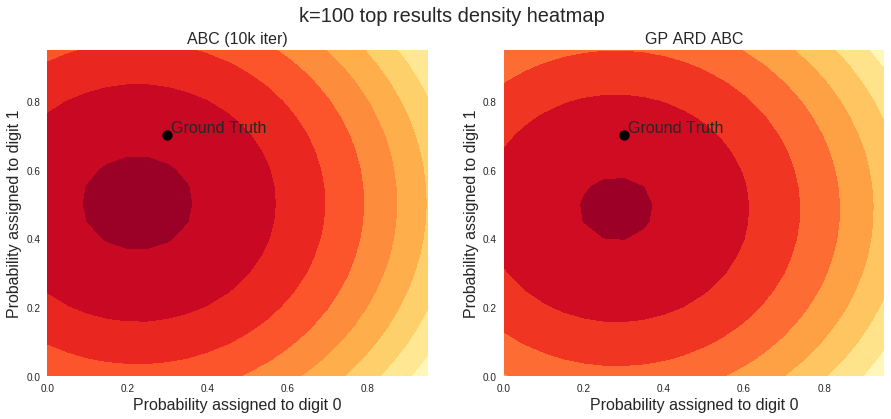

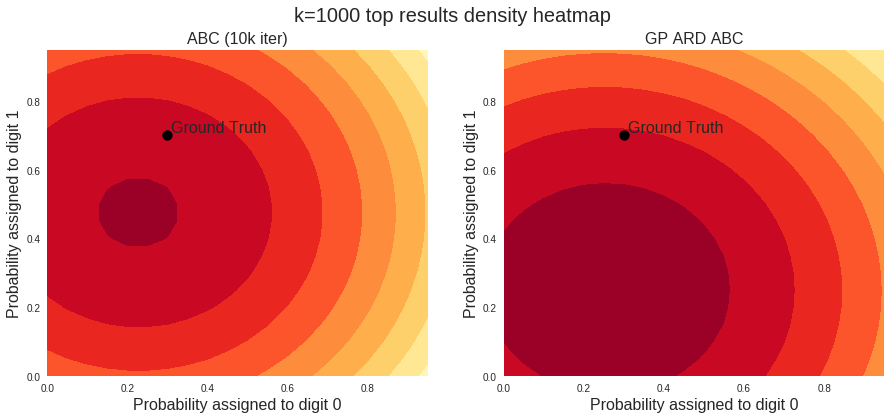

In [0]:
two_digit_result_density((larger_four_digit_results, four_digit_gp_ard_results), 
                         ('ABC (10k iter)', 'GP ARD ABC'),
                         top_k=100, suptitle='k=100 top results density heatmap')

two_digit_result_density((larger_four_digit_results, four_digit_gp_ard_results), 
                         ('ABC (10k iter)', 'GP ARD ABC'),
                         top_k=1000, suptitle='k=1000 top results density heatmap')

Stunningly better, which is impressive, given the GP optimization didn't seem super effective. 

# ABC-MCMC: optimizing the prior

To start, let's generate some result from running the ABC-MCMC-simplex method I implemented for the previous assignemnt, starting with the 0-1 mixture problem:

In [0]:
two_digit_abc_mcmc_results = abc_mcmc_simplex(
    default_digits, train_images, uniform_two_param_sampler, 
              vae, metric, n_chains=1, n_iter=1000)

print(two_digit_abc_mcmc_results[:5])


[(2.886821634051972, array([0.33109673, 0.66890327]), True), (2.90215246801506, array([0.3015732, 0.6984268]), False), (2.90215246801506, array([0.3015732, 0.6984268]), True), (2.905555514777664, array([0.37525022, 0.62474978]), False), (2.905555514777664, array([0.37525022, 0.62474978]), False)]


In [0]:
torch.manual_seed(33)

def abc_mcmc_prior_bayes_opt_wrapper(dirichlet_params, n_chains=1, n_iter=100, top_k=5):
    prior = torch.distributions.Dirichlet(dirichlet_params)
    def prior_sampler(seed):
        return prior.sample().cpu()
    
    results = abc_mcmc_simplex(default_digits, train_images, prior_sampler, 
              vae, metric, n_chains=1, n_iter=n_iter, salt_proposal_params=dict(h=0.2),
                              prior_dirichlet_params=dirichlet_params)

    score = np.mean([tup[0] for tup in results[:top_k]])
    return torch.tensor(score)


dim = 2
n_initial_samples = 20


naive_prior = torch.distributions.Uniform(5, 15)

abc_mcmc_opt = ABCBayesianOptimizer(abc_mcmc_prior_bayes_opt_wrapper, 
                               naive_prior.sample((n_initial_samples, dim)), dim,
                               lambda: naive_prior.sample((1, dim)),
                               constraints.interval(1, 20), 
                               abc_params=dict(n_iter=1000, top_k=100),
                               verbose=True)

abc_mcmc_opt.optimize(40)

Evaluating initial values


Creating GP
After initial fitting, best f(tensor([ 5.4687, 11.9725])) = 2.9085488319396973


At iteration 1, proposed tensor([[ 1.0002, 19.9995]]) => tensor([4.9578])


At iteration 2, proposed tensor([[20., 20.]]) => tensor([2.9543])


At iteration 3, proposed tensor([[20.0000,  1.0000]]) => tensor([4.9596])


At iteration 4, proposed tensor([[1.0000, 1.0001]]) => tensor([2.9884])


At iteration 5, proposed tensor([[1.0001, 7.3209]]) => tensor([4.5686])


At iteration 6, proposed tensor([[12.8217, 19.9961]]) => tensor([2.9122])


At iteration 7, proposed tensor([[6.1899, 1.0000]]) => tensor([4.9414])


At iteration 8, proposed tensor([[ 9.0082, 13.0028]]) => tensor([2.9278])


At iteration 9, proposed tensor([[20.0000, 12.3103]]) => tensor([3.0553])


At iteration 10, proposed tensor([[ 8.0969, 19.9994]]) => tensor([2.9050])
Found new best -- old: f(tensor([ 5.4687, 11.9725])) = 2.9085488319396973, new: f(tensor([[ 8.0969, 19.9994]])) = tensor([2.9050])


At iteration 11, proposed tensor([[16.7693, 20.0000]]) => tensor([2.9437])


At iteration 12, proposed tensor([[20.0000, 16.4453]]) => tensor([2.9829])


At iteration 13, proposed tensor([[10.1022, 17.8897]]) => tensor([2.9226])


At iteration 14, proposed tensor([[20.0000,  7.6588]]) => tensor([3.2243])


At iteration 15, proposed tensor([[ 6.5420, 17.1542]]) => tensor([2.9121])


At iteration 16, proposed tensor([[ 8.1315, 17.1977]]) => tensor([2.9106])


At iteration 17, proposed tensor([[16.5539, 16.9949]]) => tensor([2.9581])


At iteration 18, proposed tensor([[17.0907, 13.0153]]) => tensor([2.9903])


At iteration 19, proposed tensor([[17.6572,  9.6167]]) => tensor([3.0372])


At iteration 20, proposed tensor([[13.5619, 17.7106]]) => tensor([2.9308])


At iteration 21, proposed tensor([[ 5.5352, 14.8149]]) => tensor([2.9131])


At iteration 22, proposed tensor([[6.8475, 6.7445]]) => tensor([2.9372])


At iteration 23, proposed tensor([[5.9799, 9.8751]]) => tensor([2.9225])


At iteration 24, proposed tensor([[ 6.9938, 15.4800]]) => tensor([2.9059])


At iteration 25, proposed tensor([[ 6.0702, 13.5828]]) => tensor([2.9164])


At iteration 26, proposed tensor([[14.5685, 11.8840]]) => tensor([2.9754])


At iteration 27, proposed tensor([[ 8.6055, 17.8523]]) => tensor([2.9194])


At iteration 28, proposed tensor([[11.2516, 15.8546]]) => tensor([2.9297])


At iteration 29, proposed tensor([[19.9994, 18.4778]]) => tensor([2.9787])


At iteration 30, proposed tensor([[18.4398, 20.0000]]) => tensor([2.9561])


At iteration 31, proposed tensor([[10.2778, 19.9982]]) => tensor([2.9124])


At iteration 32, proposed tensor([[ 9.1550, 19.9982]]) => tensor([2.9099])


At iteration 33, proposed tensor([[ 6.8945, 19.9982]]) => tensor([2.9081])


At iteration 34, proposed tensor([[8.0370, 7.8453]]) => tensor([2.9462])


At iteration 35, proposed tensor([[ 8.9316, 15.8089]]) => tensor([2.9211])


At iteration 36, proposed tensor([[11.8100, 18.6916]]) => tensor([2.9280])


At iteration 37, proposed tensor([[14.5927, 19.9992]]) => tensor([2.9247])


At iteration 38, proposed tensor([[11.6167, 19.9980]]) => tensor([2.9252])


At iteration 39, proposed tensor([[ 7.9170, 19.9980]]) => tensor([2.9038])
Found new best -- old: f(tensor([[ 8.0969, 19.9994]])) = tensor([2.9050]), new: f(tensor([[ 7.9170, 19.9980]])) = tensor([2.9038])


At iteration 40, proposed tensor([[ 6.7091, 15.7043]]) => tensor([2.9131])


(tensor([[ 7.9170, 19.9980]]), tensor([2.9038]))

Let's try giving some more samples, since the behavior toward the end appears more promising

In [0]:
abc_mcmc_opt.optimize(40)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in expm1
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply


At iteration 1, proposed tensor([[11.0746, 11.5442]]) => tensor([4.8531])


At iteration 2, proposed tensor([[11.0746, 11.5442]]) => tensor([3.1003])


At iteration 3, proposed tensor([[10.6267,  9.1205]]) => tensor([3.4981])


At iteration 4, proposed tensor([[12.0384,  5.2952]]) => tensor([3.4522])


At iteration 5, proposed tensor([[12.0384,  5.2952]]) => tensor([3.3250])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in multiply


At iteration 6, proposed tensor([[14.4586,  5.4278]]) => tensor([3.0742])


At iteration 7, proposed tensor([[ 5.2990, 11.8250]]) => tensor([3.8909])


At iteration 8, proposed tensor([[ 5.2990, 11.8250]]) => tensor([4.5257])


At iteration 9, proposed tensor([[13.2426,  5.5105]]) => tensor([3.0656])


At iteration 10, proposed tensor([[6.5615, 6.7136]]) => tensor([3.5608])


At iteration 11, proposed tensor([[ 5.4231, 14.3125]]) => tensor([3.4725])


At iteration 12, proposed tensor([[7.7625, 5.5573]]) => tensor([4.0933])


At iteration 13, proposed tensor([[11.2718, 11.4878]]) => tensor([4.5237])


At iteration 14, proposed tensor([[11.9609,  5.4947]]) => tensor([4.2033])


At iteration 15, proposed tensor([[ 8.8374, 14.0989]]) => tensor([3.0274])


At iteration 16, proposed tensor([[14.2261,  5.4391]]) => tensor([4.7294])


At iteration 17, proposed tensor([[13.0337, 11.7586]]) => tensor([4.6519])


At iteration 18, proposed tensor([[8.3090, 6.4522]]) => tensor([5.1419])


At iteration 19, proposed tensor([[10.2844,  9.2858]]) => tensor([3.7007])


At iteration 20, proposed tensor([[7.1333, 9.8393]]) => tensor([4.7701])


At iteration 21, proposed tensor([[ 7.5024, 10.9202]]) => tensor([3.0789])


At iteration 22, proposed tensor([[13.1816, 11.7549]]) => tensor([4.3784])


At iteration 23, proposed tensor([[5.6312, 5.1897]]) => tensor([4.7200])


At iteration 24, proposed tensor([[13.6090, 11.8446]]) => tensor([3.0178])


At iteration 25, proposed tensor([[12.6705, 12.4016]]) => tensor([4.8192])


At iteration 26, proposed tensor([[11.1679,  9.0697]]) => tensor([2.9888])


At iteration 27, proposed tensor([[11.4696, 11.1654]]) => tensor([4.4038])


At iteration 28, proposed tensor([[ 6.9882, 14.1643]]) => tensor([4.0077])


At iteration 29, proposed tensor([[14.9363, 12.1320]]) => tensor([4.8551])


At iteration 30, proposed tensor([[11.8145, 12.3340]]) => tensor([4.0270])


At iteration 31, proposed tensor([[ 9.4786, 14.7535]]) => tensor([3.8590])


At iteration 32, proposed tensor([[12.5213,  7.5051]]) => tensor([2.9564])
Found new best -- old: f(tensor([[ 1.0043, 19.9999]])) = tensor([2.9603]), new: f(tensor([[12.5213,  7.5051]])) = tensor([2.9564])


At iteration 33, proposed tensor([[9.3954, 6.7587]]) => tensor([3.4173])


At iteration 34, proposed tensor([[13.5188, 13.5483]]) => tensor([3.5758])


At iteration 35, proposed tensor([[13.5188, 13.5483]]) => tensor([4.6246])


At iteration 36, proposed tensor([[13.5188, 13.5483]]) => tensor([2.9615])


At iteration 37, proposed tensor([[ 5.0867, 10.7633]]) => tensor([2.9891])


At iteration 38, proposed tensor([[10.5982,  8.2513]]) => tensor([3.1895])


At iteration 39, proposed tensor([[10.5982,  8.2513]]) => tensor([3.4309])


At iteration 40, proposed tensor([[ 7.8396, 12.6587]]) => tensor([3.0967])


(tensor([[12.5213,  7.5051]]), tensor([2.9564]))

Let's sample a single chain using this prior, and compare the results

In [0]:
abc_mcmc_gp_param_prior = torch.distributions.Dirichlet(abc_mcmc_opt.best_x)
def gp_param_prior_sampler(seed):
    return abc_mcmc_gp_param_prior.sample().cpu()

gp_prior_two_digit_abc_mcmc_results = abc_mcmc_simplex(
    default_digits, train_images, gp_param_prior_sampler, 
              vae, metric, n_chains=1, n_iter=1000, salt_proposal_params=dict(h=0.2))

print(gp_prior_two_digit_abc_mcmc_results[:5])

[(2.9000354299485522, array([0.29107618, 0.7089238 ], dtype=float32), True), (2.903616186698666, array([0.3668174, 0.6331826], dtype=float32), True), (2.92096513703253, array([0.30396783, 0.69603217], dtype=float32), False), (2.92096513703253, array([0.30396783, 0.69603217], dtype=float32), True), (2.9368991478289352, array([0.3448227, 0.6551773], dtype=float32), False)]


In [0]:
compare_results((0.3, 0.7), two_digit_abc_mcmc_results, gp_prior_two_digit_abc_mcmc_results)

╒═════════╤═════════════╤═════════════════╤════════════════╤════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC score │   ABC digit MAD │   ABC_GP score │   ABC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪═════════════╪═════════════════╪════════════════╪════════════════════╪══════════════╪═════════════════╡
│       1 │     2.88682 │       0.0621935 │        2.90004 │          0.0178476 │   -0.0132138 │       0.0443458 │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│      10 │     2.90358 │       0.0871182 │        2.92887 │          0.0561825 │   -0.0252939 │       0.0309357 │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│     100 │     2.95587 │       0.0966102 │        3.16482 │          0.289877  │   -0.208951  │      -0.193267  │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────

It appears worse, in my mind because the metric is insufficiently informative about samples.

# ABC-MCMC: prior and temperature jointly

In [0]:
torch.manual_seed(33)

def abc_mcmc_prior_temp_bayes_opt_wrapper(params, n_chains=1, n_iter=100, top_k=5):
    param_view = torch.squeeze(params)
    dirichlet_params = param_view[:-1]
    prior = torch.distributions.Dirichlet(dirichlet_params)
    def prior_sampler(seed):
        return prior.sample().cpu()
    
    results = abc_mcmc_simplex(default_digits, train_images, prior_sampler, 
                               vae, metric, n_chains=1, n_iter=n_iter, 
                               salt_proposal_params=dict(h=0.2),
                               prior_dirichlet_params=dirichlet_params,
                               distance_inv_temp=param_view[-1].numpy())

    score = np.mean([tup[0] for tup in results[:top_k]])
    return torch.tensor(score)


dim = 3
n_initial_samples = 20


# naive_prior = torch.distributions.Uniform(1, 20)
naive_prior = torch.distributions.Uniform(5, 15)

abc_mcmc_opt = ABCBayesianOptimizer(abc_mcmc_prior_temp_bayes_opt_wrapper, 
                               naive_prior.sample((n_initial_samples, dim)), dim,
                               lambda: naive_prior.sample((1, dim)),
                               constraints.interval(1, 20), proposal_from_previous=False,
                               optimize_proposals=False, 
                               abc_params=dict(n_iter=1000, top_k=500),
                               verbose=True)

abc_mcmc_opt.optimize(40)

Evaluating initial values


Creating GP
After initial fitting, best f(tensor([ 8.6674, 11.1120, 14.6030])) = 2.934473991394043


At iteration 1, proposed tensor([[14.5095,  9.8632, 14.1508]]) => tensor([2.9767])


At iteration 2, proposed tensor([[11.0641, 14.7443,  9.5187]]) => tensor([2.9530])


At iteration 3, proposed tensor([[13.2107,  5.1072,  7.8828]]) => tensor([3.0541])


At iteration 4, proposed tensor([[ 7.2463,  6.6693, 12.7475]]) => tensor([2.9560])


At iteration 5, proposed tensor([[11.6633, 14.3792,  5.5832]]) => tensor([2.9669])


At iteration 6, proposed tensor([[ 7.1676, 13.3062,  8.1522]]) => tensor([2.9415])


At iteration 7, proposed tensor([[ 7.7179, 13.2271, 10.7116]]) => tensor([2.9419])


At iteration 8, proposed tensor([[ 5.6976, 11.9607, 12.8343]]) => tensor([2.9312])
Found new best -- old: f(tensor([ 8.6674, 11.1120, 14.6030])) = 2.934473991394043, new: f(tensor([[ 5.6976, 11.9607, 12.8343]])) = tensor([2.9312])


At iteration 9, proposed tensor([[ 6.5124, 13.7523, 12.9510]]) => tensor([2.9289])
Found new best -- old: f(tensor([[ 5.6976, 11.9607, 12.8343]])) = tensor([2.9312]), new: f(tensor([[ 6.5124, 13.7523, 12.9510]])) = tensor([2.9289])


At iteration 10, proposed tensor([[ 8.0600, 13.9005,  5.3427]]) => tensor([2.9482])


At iteration 11, proposed tensor([[ 7.8482, 13.2545, 11.0284]]) => tensor([2.9362])


At iteration 12, proposed tensor([[ 6.2922, 13.9411, 13.4567]]) => tensor([2.9231])
Found new best -- old: f(tensor([[ 6.5124, 13.7523, 12.9510]])) = tensor([2.9289]), new: f(tensor([[ 6.2922, 13.9411, 13.4567]])) = tensor([2.9231])


At iteration 13, proposed tensor([[ 8.6368, 14.2597,  8.0713]]) => tensor([2.9437])


At iteration 14, proposed tensor([[11.5942, 13.6245, 13.3763]]) => tensor([2.9460])


At iteration 15, proposed tensor([[ 9.9544, 14.3855,  9.0191]]) => tensor([2.9524])


At iteration 16, proposed tensor([[ 7.8817, 14.6187, 12.2411]]) => tensor([2.9419])


At iteration 17, proposed tensor([[ 7.8577,  6.9597, 13.7303]]) => tensor([2.9503])


At iteration 18, proposed tensor([[ 7.7428, 13.1407,  9.2903]]) => tensor([2.9480])


At iteration 19, proposed tensor([[ 7.1433,  6.3153, 13.8548]]) => tensor([2.9530])


At iteration 20, proposed tensor([[ 6.5208, 14.0118, 10.4123]]) => tensor([2.9302])


At iteration 21, proposed tensor([[ 6.7524, 11.8343,  9.0786]]) => tensor([2.9460])


At iteration 22, proposed tensor([[ 5.4363,  7.7350, 10.8562]]) => tensor([2.9391])


At iteration 23, proposed tensor([[10.3656, 12.3140,  9.8817]]) => tensor([2.9628])


At iteration 24, proposed tensor([[ 6.5751,  8.7423, 14.3151]]) => tensor([2.9282])


At iteration 25, proposed tensor([[5.4290, 9.4944, 7.4058]]) => tensor([2.9430])


At iteration 26, proposed tensor([[ 9.3795, 11.2870,  7.9400]]) => tensor([2.9576])


At iteration 27, proposed tensor([[12.9792, 12.1910, 14.8605]]) => tensor([2.9573])


At iteration 28, proposed tensor([[ 6.8146, 13.4404, 12.3170]]) => tensor([2.9297])


At iteration 29, proposed tensor([[ 6.7837, 12.0231, 11.3637]]) => tensor([2.9376])


At iteration 30, proposed tensor([[ 6.5834,  8.0037, 14.7833]]) => tensor([2.9370])


At iteration 31, proposed tensor([[ 5.6412,  8.2773, 14.3166]]) => tensor([2.9327])


At iteration 32, proposed tensor([[ 5.2990, 11.8250, 12.8515]]) => tensor([2.9291])


At iteration 33, proposed tensor([[7.3464, 9.5555, 9.8155]]) => tensor([2.9426])


At iteration 34, proposed tensor([[ 8.1594, 14.5587, 14.0919]]) => tensor([2.9317])


At iteration 35, proposed tensor([[11.3144, 14.6393,  8.8714]]) => tensor([2.9587])


At iteration 36, proposed tensor([[12.4702,  9.5686, 14.3614]]) => tensor([2.9581])


At iteration 37, proposed tensor([[ 9.4336, 13.9867, 14.2738]]) => tensor([2.9289])


At iteration 38, proposed tensor([[10.6155,  7.7940, 14.7033]]) => tensor([2.9584])


At iteration 39, proposed tensor([[ 7.9513, 13.2172, 13.5965]]) => tensor([2.9302])


At iteration 40, proposed tensor([[ 9.0466,  7.5421, 11.5196]]) => tensor([2.9594])


(tensor([[ 6.2922, 13.9411, 13.4567]]), tensor([2.9231]))

In [0]:
best_x = abc_mcmc_opt.best_x.view(-1, 1)

abc_mcmc_gp_param_prior = torch.distributions.Dirichlet(best_x[:-1])
def gp_param_prior_sampler(seed):
    return abc_mcmc_gp_param_prior.sample().cpu()

gp_prior_two_digit_abc_mcmc_results = abc_mcmc_simplex(
    default_digits, train_images, gp_param_prior_sampler,
    vae, metric, n_chains=1, n_iter=1000, 
    distance_inv_temp=best_x[-1].cpu().numpy(), salt_proposal_params=dict(h=0.2))

print(gp_prior_two_digit_abc_mcmc_results[:5])

[(2.8610274152281026, array([0.30433068, 0.6956693 ], dtype=float32), False), (2.8610274152281026, array([0.30433068, 0.6956693 ], dtype=float32), False), (2.8610274152281026, array([0.30433068, 0.6956693 ], dtype=float32), True), (2.869706341596019, array([0.35259792, 0.6474021 ], dtype=float32), True), (2.8735147997683534, array([0.29131347, 0.70868653], dtype=float32), False)]


In [0]:
compare_results((0.3, 0.7), two_digit_abc_mcmc_results, gp_prior_two_digit_abc_mcmc_results)

╒═════════╤═════════════╤═════════════════╤════════════════╤════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC score │   ABC digit MAD │   ABC_GP score │   ABC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪═════════════╪═════════════════╪════════════════╪════════════════════╪══════════════╪═════════════════╡
│       1 │     2.88682 │       0.0621935 │        2.86103 │         0.00866138 │    0.0257942 │       0.0535321 │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│      10 │     2.90358 │       0.0871182 │        2.86939 │         0.0235418  │    0.0341892 │       0.0635764 │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────┼──────────────┼─────────────────┤
│     100 │     2.95587 │       0.0966102 │        2.88607 │         0.0510313  │    0.0697976 │       0.0455788 │
├─────────┼─────────────┼─────────────────┼────────────────┼────────────────────

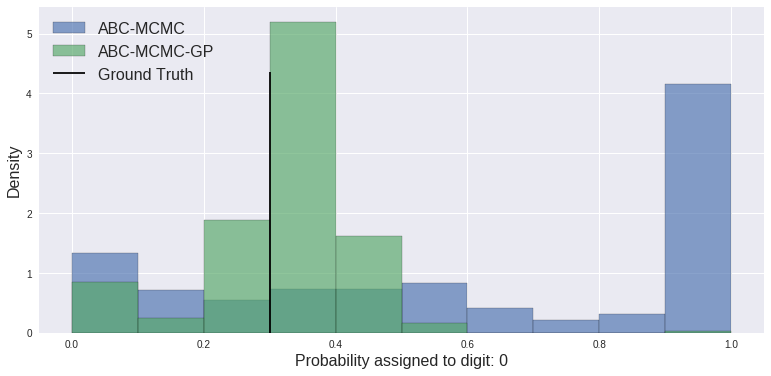

In [0]:
single_digit_result_histogram([two_digit_abc_mcmc_results,
                               gp_prior_two_digit_abc_mcmc_results],
                              ['ABC-MCMC', 'ABC-MCMC-GP'], top_k=1000)

The GP's single chain didn't produce the best overall result, or the best top-10, but fared substantially better on the top-100 or if evaluating the entire Chain. Let's give it four longer chains, and see if that makes any difference to the evaluation:

In [0]:
four_longer_chains_two_digit_abc_mcmc_results = abc_mcmc_simplex(
    default_digits, train_images, uniform_two_param_sampler, 
    distance_inv_temp=5.0, vae, metric, n_chains=4, n_iter=2000)


best_x = abc_mcmc_opt.best_x.view(-1, 1)

abc_mcmc_gp_param_prior = torch.distributions.Dirichlet(best_x[:-1])
def gp_param_prior_sampler(seed):
    return abc_mcmc_gp_param_prior.sample().cpu()

four_longer_chains_gp_prior_two_digit_abc_mcmc_results = abc_mcmc_simplex(
    default_digits, train_images, gp_param_prior_sampler,
    vae, metric, n_chains=4, n_iter=2000, 
    distance_inv_temp=best_x[-1].cpu().numpy(), salt_proposal_params=dict(h=0.2))



SyntaxError: ignored

In [0]:
compare_results((0.3, 0.7), four_longer_chains_two_digit_abc_mcmc_results, four_longer_chains_gp_prior_two_digit_abc_mcmc_results,
               'ABC_MCMC', 'ABC_MCMC_GP', (1, 10, 100, 1000, 2000, 4000))

╒═════════╤══════════════════╤══════════════════════╤═════════════════════╤═════════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC_MCMC score │   ABC_MCMC digit MAD │   ABC_MCMC_GP score │   ABC_MCMC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪══════════════════╪══════════════════════╪═════════════════════╪═════════════════════════╪══════════════╪═════════════════╡
│       1 │          2.85774 │            0.0426743 │             2.86274 │               0.0718226 │  -0.00499984 │     -0.0291483  │
├─────────┼──────────────────┼──────────────────────┼─────────────────────┼─────────────────────────┼──────────────┼─────────────────┤
│      10 │          2.88496 │            0.0331822 │             2.86572 │               0.0270027 │   0.0192322  │      0.00617944 │
├─────────┼──────────────────┼──────────────────────┼─────────────────────┼─────────────────────────┼──────────────┼─────────────────┤
│     100 │          2.91589 │            0.0681651 │  

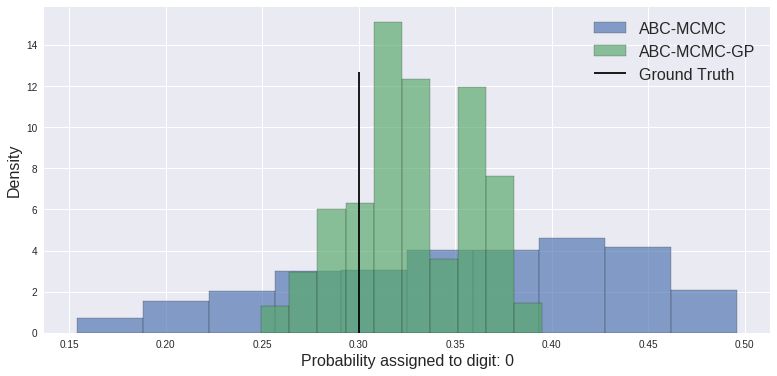

In [0]:
single_digit_result_histogram([four_longer_chains_two_digit_abc_mcmc_results,
                               four_longer_chains_gp_prior_two_digit_abc_mcmc_results],
                              ['ABC-MCMC', 'ABC-MCMC-GP'], top_k=1000)

In this setting, the learned parameters substantially outperform the original ones. This is nice.

## Final test

Let's evaluate this method on the four-digit problem, and allow learning in the length-scale for sampling as well. Since that length scale as usually been around 0.2, I will keep it constrained to [1,20] like the rest of the variables, and take the scale to be the reciprocal of the value:

In [0]:
torch.manual_seed(33)

def four_digit_abc_mcmc_prior_temp_scale_bayes_opt_wrapper(params, n_chains=1, n_iter=100, top_k=5):
    param_view = torch.squeeze(params)
    dirichlet_params = param_view[:-2]
    prior = torch.distributions.Dirichlet(dirichlet_params)
    def prior_sampler(seed):
        return prior.sample().cpu()
    
    results = abc_mcmc_simplex(default_four_digits, train_images, prior_sampler, 
                               vae, metric, n_chains=1, n_iter=n_iter, 
                               salt_proposal_params=dict(h=1.0 / param_view[-1].numpy()),
                               distance_inv_temp=param_view[-2].numpy())

    score = np.mean([tup[0] for tup in results[:top_k]])
    return torch.tensor(score)


dim = 6
n_initial_samples = 40


# naive_prior = torch.distributions.Uniform(1, 20)
# naive_prior = torch.distributions.Uniform(5, 15)
naive_prior = torch.distributions.Uniform(2, 18)

four_digit_abc_mcmc_opt = ABCBayesianOptimizer(four_digit_abc_mcmc_prior_temp_scale_bayes_opt_wrapper, 
                               naive_prior.sample((n_initial_samples, dim)), dim,
                               lambda: naive_prior.sample((1, dim)),
                               constraints.interval(1, 20), proposal_from_previous=False,
                               optimize_proposals=False, num_proposal_candidates=10,
                               abc_params=dict(n_iter=1000, top_k=50),
                               verbose=True)

four_digit_abc_mcmc_opt.optimize(40)

Evaluating initial values



Creating GP
After initial fitting, best f(tensor([ 5.6888, 10.0306,  7.0822, 16.4919, 12.6004, 14.9820])) = 2.6111032962799072


At iteration 1, proposed tensor([[13.5056, 17.7767, 15.2378,  3.8836, 16.5099,  6.3045]]) => tensor([2.6318])


At iteration 2, proposed tensor([[3.7193, 3.4869, 2.4819, 9.6655, 8.9944, 3.1422]]) => tensor([2.6298])


At iteration 3, proposed tensor([[17.2940, 16.5470, 16.2341,  3.2600,  3.4271, 10.4150]]) => tensor([2.6581])


At iteration 4, proposed tensor([[13.8295, 10.7951,  8.1399, 16.5582,  4.0143,  2.9774]]) => tensor([2.6442])


At iteration 5, proposed tensor([[ 2.8319,  6.3134, 16.3980, 15.8732,  9.3981,  4.0217]]) => tensor([2.6243])


At iteration 6, proposed tensor([[ 3.0099,  2.3035, 10.6928, 16.9249, 16.1205,  8.7841]]) => tensor([2.6462])


At iteration 7, proposed tensor([[ 5.1812, 16.6629,  4.0647, 15.1816, 17.4048, 17.0681]]) => tensor([2.6622])


At iteration 8, proposed tensor([[ 4.7988, 15.7365, 14.6747, 16.9623, 10.0346,  3.2877]]) => tensor([2.6313])


At iteration 9, proposed tensor([[13.2765,  9.7118, 15.1743, 11.7079, 14.4162,  6.2765]]) => tensor([2.6282])


At iteration 10, proposed tensor([[11.5637, 14.1157,  9.3537,  9.2558, 17.9590, 10.9741]]) => tensor([2.6306])


At iteration 11, proposed tensor([[15.6880,  3.3862, 10.7732, 16.9357, 17.5273,  2.0658]]) => tensor([2.6169])


At iteration 12, proposed tensor([[11.4990, 17.1256, 13.8812, 15.3456, 15.8434,  2.8399]]) => tensor([2.6221])


At iteration 13, proposed tensor([[11.9007, 14.1291,  3.0717, 13.5407, 11.3015,  3.3229]]) => tensor([2.6184])


At iteration 14, proposed tensor([[ 4.5219, 13.3198,  9.8692,  6.9175, 14.1205,  2.7696]]) => tensor([2.6127])


At iteration 15, proposed tensor([[ 2.9597, 16.3400, 11.0025, 14.5067, 10.6776,  4.0259]]) => tensor([2.6265])


At iteration 16, proposed tensor([[ 3.4659, 17.7067,  3.5843, 16.8331, 14.6812, 12.5944]]) => tensor([2.6263])


At iteration 17, proposed tensor([[17.2143, 17.3520, 12.4492, 13.5517, 14.5959,  7.8220]]) => tensor([2.6233])


At iteration 18, proposed tensor([[14.8860, 14.4038,  6.4838,  8.2590, 12.8934,  3.8224]]) => tensor([2.6212])


At iteration 19, proposed tensor([[ 4.6636, 17.7076,  8.0203, 12.5092, 11.2313,  2.7268]]) => tensor([2.6156])


At iteration 20, proposed tensor([[ 3.6696, 14.6074,  2.2395, 10.4821,  8.7630,  6.4545]]) => tensor([2.6243])


At iteration 21, proposed tensor([[ 6.6497,  3.9738, 11.9706, 17.1726, 16.3474,  2.5775]]) => tensor([2.6143])


At iteration 22, proposed tensor([[ 4.6152,  8.8563, 17.0778,  7.1048, 11.6655,  4.9997]]) => tensor([2.6300])


At iteration 23, proposed tensor([[ 4.6200,  8.1462, 14.4047,  2.5738, 17.3565,  4.4805]]) => tensor([2.6207])


At iteration 24, proposed tensor([[16.2724,  7.6573,  4.6370,  6.2883, 16.9573,  2.5711]]) => tensor([2.6106])
Found new best -- old: f(tensor([ 5.6888, 10.0306,  7.0822, 16.4919, 12.6004, 14.9820])) = 2.6111032962799072, new: f(tensor([[16.2724,  7.6573,  4.6370,  6.2883, 16.9573,  2.5711]])) = tensor([2.6106])


At iteration 25, proposed tensor([[ 6.1369, 13.3398, 17.3532, 17.4472, 16.0306,  2.9497]]) => tensor([2.6250])


At iteration 26, proposed tensor([[11.2726, 13.8077,  4.8428, 17.6382, 13.1188,  3.2273]]) => tensor([2.6170])


At iteration 27, proposed tensor([[ 4.7294, 10.4065,  3.7804, 12.5363, 16.5010,  3.0741]]) => tensor([2.6209])


At iteration 28, proposed tensor([[ 2.3135, 16.8523, 11.0865,  2.4061,  9.2859,  2.4398]]) => tensor([2.6214])


At iteration 29, proposed tensor([[ 7.9911, 17.1664, 16.6642, 13.9879,  7.9910,  6.4471]]) => tensor([2.6475])


At iteration 30, proposed tensor([[ 2.9603, 11.9891, 10.6181, 17.2304, 14.2787,  7.4243]]) => tensor([2.6454])


At iteration 31, proposed tensor([[12.8847, 12.3042,  4.0262,  7.4806, 15.9562, 11.4333]]) => tensor([2.6206])


At iteration 32, proposed tensor([[ 3.2634, 11.5377, 11.3531, 13.2087, 11.3899,  2.1875]]) => tensor([2.6216])


At iteration 33, proposed tensor([[ 9.9557, 16.5879,  3.2539,  7.7931, 17.3558, 13.4971]]) => tensor([2.6238])


At iteration 34, proposed tensor([[ 4.7374, 16.7179, 17.8434,  9.7990, 17.9927, 16.3883]]) => tensor([2.6545])


At iteration 35, proposed tensor([[13.3163, 17.9411,  2.3134,  7.2738, 17.4400,  8.2606]]) => tensor([2.6017])
Found new best -- old: f(tensor([[16.2724,  7.6573,  4.6370,  6.2883, 16.9573,  2.5711]])) = tensor([2.6106]), new: f(tensor([[13.3163, 17.9411,  2.3134,  7.2738, 17.4400,  8.2606]])) = tensor([2.6017])


At iteration 36, proposed tensor([[15.4315, 11.6378,  2.6098,  3.0106, 15.5118,  7.9025]]) => tensor([2.6253])


At iteration 37, proposed tensor([[ 7.5880, 11.0634,  6.7973, 17.5033, 12.4944,  7.0420]]) => tensor([2.6230])


At iteration 38, proposed tensor([[12.6038, 13.7785, 11.8546,  8.6959, 12.0385,  2.4157]]) => tensor([2.6304])


At iteration 39, proposed tensor([[12.5674, 14.7635, 14.0685, 17.3405, 17.4453, 10.3358]]) => tensor([2.6170])


At iteration 40, proposed tensor([[15.2548, 17.3955,  3.0085,  8.5348, 16.7151, 11.5413]]) => tensor([2.6405])



(tensor([[13.3163, 17.9411,  2.3134,  7.2738, 17.4400,  8.2606]]),
 tensor([2.6017]))

In [0]:
four_longer_chains_four_digit_abc_mcmc_raw, four_longer_chains_four_digit_abc_mcmc_results = abc_mcmc_simplex(
    default_four_digits, train_images, uniform_four_param_sampler, 
              vae, metric, n_chains=4, n_iter=2000, return_raw_results=True)


four_digit_best_x = torch.squeeze(four_digit_abc_mcmc_opt.best_x).cpu()

abc_mcmc_gp_param_prior = torch.distributions.Dirichlet(four_digit_best_x[:-2])
def gp_param_prior_sampler(seed):
    return abc_mcmc_gp_param_prior.sample().cpu()

four_longer_chains_gp_prior_four_digit_abc_mcmc_raw, four_longer_chains_gp_prior_four_digit_abc_mcmc_results = abc_mcmc_simplex(
    default_four_digits, train_images, gp_param_prior_sampler,
    vae, metric, n_chains=4, n_iter=2000, return_raw_results=True,
    distance_inv_temp=four_digit_best_x[-2].numpy(), salt_proposal_params=dict(h=1.0 / four_digit_best_x[-1].numpy()))



In [0]:
compare_results((0.3, 0.7, 0, 0), four_longer_chains_four_digit_abc_mcmc_results, 
               four_longer_chains_gp_prior_four_digit_abc_mcmc_results,
               'ABC_MCMC', 'ABC_MCMC_GP', (1, 10, 100, 1000, 2000, 4000))

╒═════════╤══════════════════╤══════════════════════╤═════════════════════╤═════════════════════════╤══════════════╤═════════════════╕
│   Top K │   ABC_MCMC score │   ABC_MCMC digit MAD │   ABC_MCMC_GP score │   ABC_MCMC_GP digit MAD │   Score diff │   Mean MAD diff │
╞═════════╪══════════════════╪══════════════════════╪═════════════════════╪═════════════════════════╪══════════════╪═════════════════╡
│       1 │          2.58806 │             0.584402 │             2.56309 │                0.50845  │    0.0249795 │       0.0759519 │
├─────────┼──────────────────┼──────────────────────┼─────────────────────┼─────────────────────────┼──────────────┼─────────────────┤
│      10 │          2.61002 │             0.552096 │             2.58139 │                0.560008 │    0.02863   │      -0.007912  │
├─────────┼──────────────────┼──────────────────────┼─────────────────────┼─────────────────────────┼──────────────┼─────────────────┤
│     100 │          2.63286 │             0.584452 │  

In [0]:
def results_to_ndarray(results):
    chain_results = [[x[1] for x in chain] for chain in results]
    
    return np.stack(chain_results)


four_longer_chains_four_digit_abc_mcmc_ndarray = results_to_ndarray(four_longer_chains_four_digit_abc_mcmc_raw)

print(pm.diagnostics.gelman_rubin(four_longer_chains_four_digit_abc_mcmc_ndarray))
print(pm.diagnostics.effective_n(four_longer_chains_four_digit_abc_mcmc_ndarray))

[1.00307213 1.00174292 1.0038017  1.00302175]
[221.66152244 237.68014114 249.40635413 257.86189043]


In [0]:
four_longer_chains_gp_prior_four_digit_abc_mcmc_ndarray = results_to_ndarray(four_longer_chains_gp_prior_four_digit_abc_mcmc_raw)
print(pm.diagnostics.gelman_rubin(four_longer_chains_gp_prior_four_digit_abc_mcmc_ndarray))
print(pm.diagnostics.effective_n(four_longer_chains_gp_prior_four_digit_abc_mcmc_ndarray))

[1.0075353 1.0694833 1.0892993 1.0502355]
[99.90239602 49.88256002 40.85741007 73.80047644]


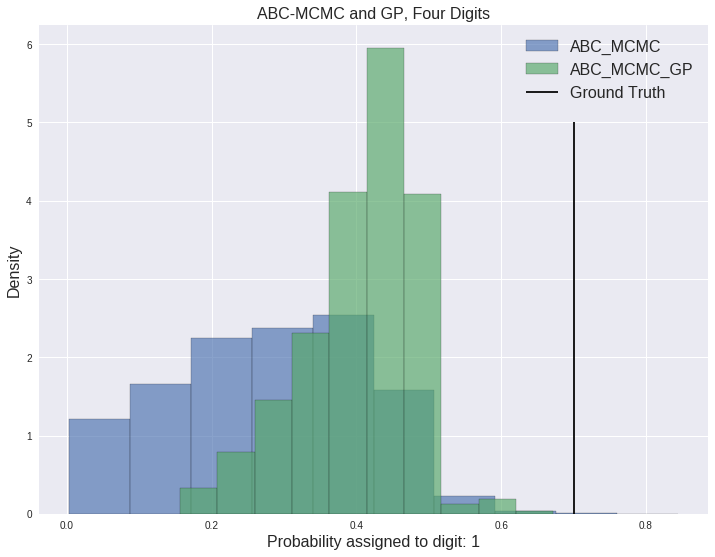

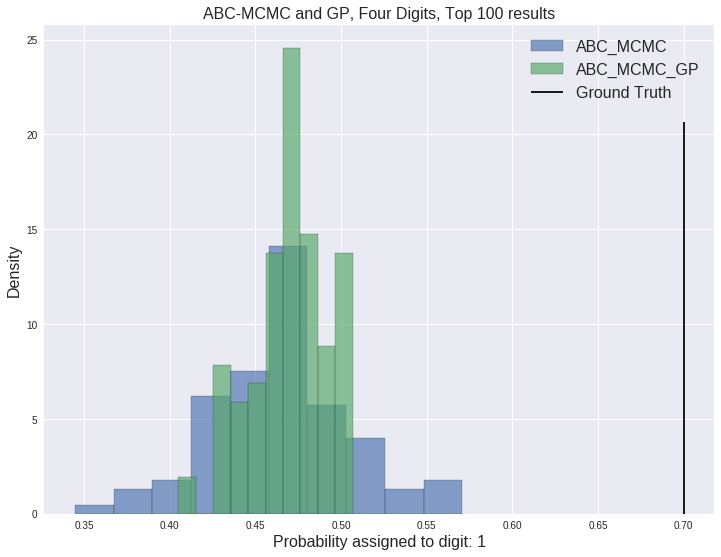

In [0]:
def single_digit_result_histogram(result_sets, labels, digit=0, ground_truth=0.3, top_k=None, 
                                  figsize=(12, 9), font_size=16, title=None):
    if top_k is None:
        top_k = len(result_sets[0])
    
    plt.figure(figsize=figsize)
    
    
    for result, label in zip(result_sets, labels):
        relevant_results = [x[1][digit] for x  in result][:top_k]
        plt.hist(relevant_results, alpha=0.66, edgecolor='black', label=label, density=True)
    
    plt.vlines(ground_truth, 0, plt.ylim()[1] * 0.8, label='Ground Truth')
    plt.legend(loc='best', fontsize=font_size)
    plt.xlabel(f'Probability assigned to digit: {digit}', fontsize=font_size)
    plt.ylabel(f'Density', fontsize=font_size)
    if title is not None:
        plt.title(title, fontsize=font_size)
    plt.show()
    
single_digit_result_histogram([four_longer_chains_four_digit_abc_mcmc_results,
                               four_longer_chains_gp_prior_four_digit_abc_mcmc_results],
                              ['ABC_MCMC', 'ABC_MCMC_GP'], 1, 0.7, title='ABC-MCMC and GP, Four Digits')

single_digit_result_histogram([four_longer_chains_four_digit_abc_mcmc_results, 
                               four_longer_chains_gp_prior_four_digit_abc_mcmc_results], 
                              ['ABC_MCMC', 'ABC_MCMC_GP'], 1, 0.7, top_k=100, title='ABC-MCMC and GP, Four Digits, Top 100 results')

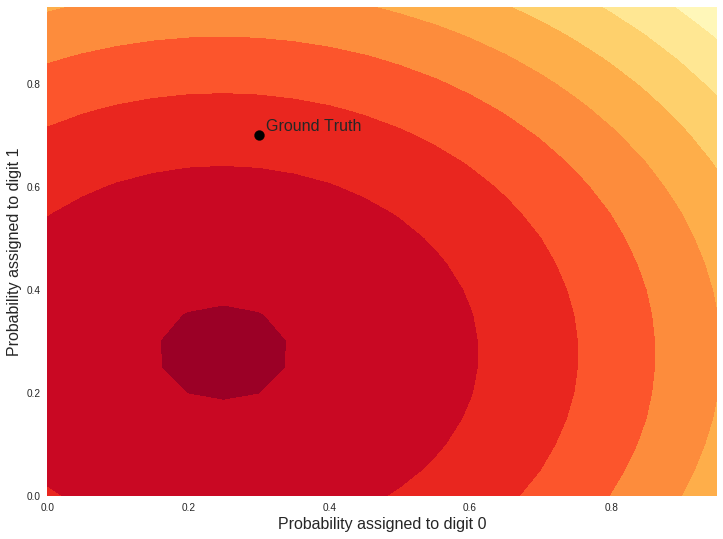

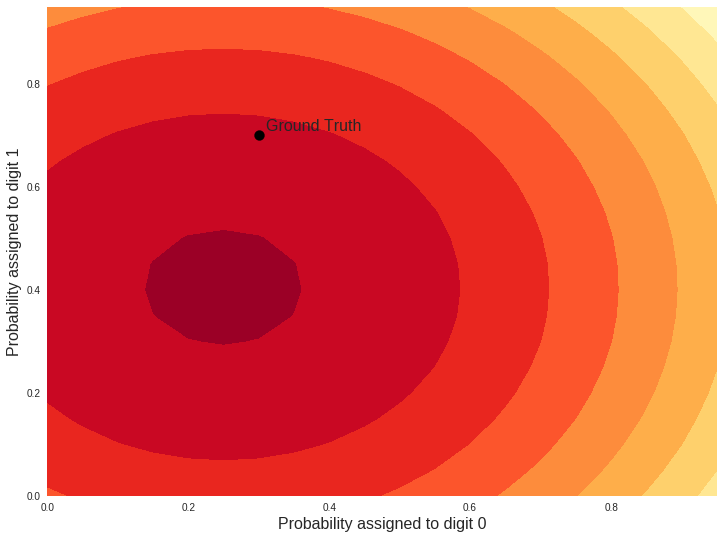

In [0]:
def two_digit_result_density(result, title=None, ground_truth=(0.3, 0.7), top_k=None, 
                                  figsize=(12, 9), font_size=16, step=0.05, cmap='YlOrRd'):
    if top_k is None:
        top_k = len(result)
    
    plt.figure(figsize=figsize)
    
    relevant_results = np.array([x[1][:2] for x in result][:top_k])
    kde = sklearn.neighbors.KernelDensity().fit(relevant_results)
    
    x = np.arange(0, 1, step)
    y = np.arange(0, 1, step)
    xx, yy = np.meshgrid(x, y)

    points = np.array(list(zip(xx.flat, yy.flat)))
    z = kde.score_samples(points).reshape((x.shape[0], y.shape[0]))
    h = plt.contourf(x, y, z, cmap=cmap)
    
    plt.scatter(*ground_truth, c='black', s=100)
    plt.text(ground_truth[0] + 0.01, ground_truth[1] + 0.01, 'Ground Truth', fontsize=font_size)
    plt.xlabel(f'Probability assigned to digit 0', fontsize=font_size)
    plt.ylabel(f'Probability assigned to digit 1', fontsize=font_size)
    if title is not None:
        plt.title(title, fontsize=font_size)
    plt.show()
    
    
two_digit_result_density(four_longer_chains_four_digit_abc_mcmc_results)
two_digit_result_density(four_longer_chains_gp_prior_four_digit_abc_mcmc_results)

In [0]:
bax = np.arange(0, 1, 0.1)
y = np.arange(0, 1, 0.1)
xx, yy = np.meshgrid(x, y)

out = np.array(list(zip(xx.flat, yy.flat)))
out.shape

(100, 2)

In [0]:
out

array(<zip object at 0x7fcb3fa08088>, dtype=object)

In [0]:
top_k = 100

rr = np.array([x[1][:2] for x in results][:top_k]).T

In [0]:
from sklearn.neighbors import KernelDensity
kde = sklearn.neighbors.KernelDensity().fit(rr)
kde

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

# MCMC Acceptance Investigation

In [0]:
test_two_digit_abc_mcmc_raw, test_two_digit_abc_mcmc_results = abc_mcmc_simplex(
    default_digits, train_images, uniform_two_param_sampler, 
              vae, metric, n_chains=1, n_iter=100, return_raw_results=True)

chain_results = test_two_digit_abc_mcmc_raw[0]

In [0]:
scores, coords, accepts = zip(*chain_results)
x, y = zip(*coords)

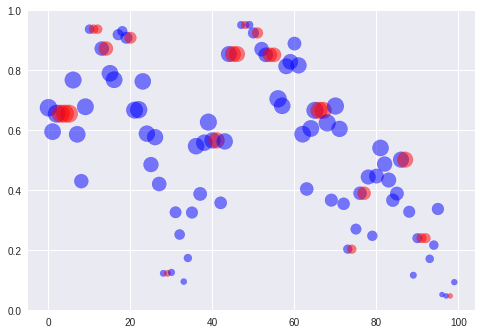

In [0]:
plt.plot(figsize=(12,8))
mapping = {False: 'red', True: 'blue'}

t = np.arange(len(x))

plt.scatter(t, y, color=[mapping[a] for a in accepts], 
            s=[(7 - s) ** 4 for s in scores], alpha=0.5)

plt.show()

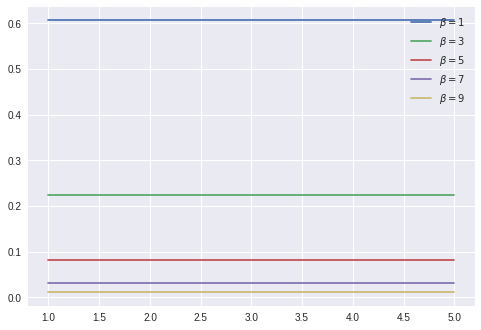

In [0]:
plt.plot(figsize=(12,8))
mapping = {False: 'red', True: 'blue'}

x_range = np.linspace(1.0, 5.0)
x_inc = 0.5
shifted_x_range = x_range + x_inc

for beta in range(1, 10, 2):
    plt.plot(x_range, np.exp(- shifted_x_range * beta) / np.exp(- x_range * beta), 
             label=f'$\\beta={beta}$')

plt.legend(loc='best')
plt.show()

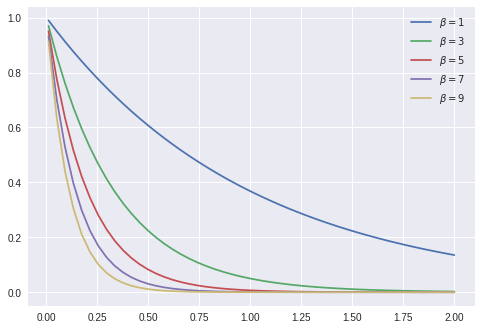

In [0]:
plt.plot(figsize=(12,8))
mapping = {False: 'red', True: 'blue'}

x_range = np.linspace(0.01, 2.0)

for beta in range(1, 10, 2):
    plt.plot(x_range, np.exp(- x_range * beta), 
             label=f'$\\beta={beta}$')

plt.legend(loc='best')
plt.show()

In [0]:
test_two_digit_abc_mcmc_results_with_temp = abc_mcmc_simplex(
    default_digits, train_images, uniform_two_param_sampler, 
    vae, metric, n_chains=1, n_iter=100, distance_inv_temp=5.0,
    return_raw_results=True)

chain_results_with_temp = test_two_digit_abc_mcmc_results_with_temp[0]

In [0]:
scores, coords, accepts = zip(*chain_results_with_temp)
x, y = zip(*coords)

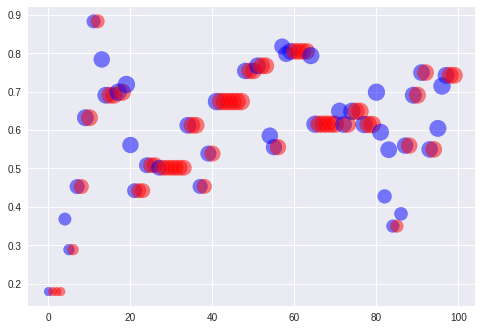

In [0]:
plt.plot(figsize=(12,8))
mapping = {False: 'red', True: 'blue'}

t = np.arange(len(x))

plt.scatter(t, y, color=[mapping[a] for a in accepts], 
            s=[(7 - s) ** 4 for s in scores], alpha=0.5)

plt.show()